### To note: Running this on different systems (i.e. local, SCW, server) will result in slight changes needing to the code

In [1]:
# Load libraries
import os
import numpy as np
import torch
import sys
import torchvision
import torchvision.transforms as T
import torchvision.models as models
from PIL import Image
from PIL import ImageEnhance
import matplotlib.pyplot as plt
import imagesize
import subprocess
sys.path
from IPython.core.debugger import set_trace
import scipy.ndimage
import matplotlib.patches as patches
# plt.rcParams['figure.figsize'] = [12,12]
# sys.path.append('/workspace/myFile/Mask_RCNN_Tutorial/')
from tqdm import tqdm
from torch import nn as nn
from torch import optim as optim
from torch.optim import lr_scheduler
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import re
import time
import copy
import pylab
from torch.utils.tensorboard import SummaryWriter
from tempfile import TemporaryDirectory
import torch.backends.cudnn as cudnn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sn
import pandas as pd
import glob
# Rather than have a messy notebook with a load of functions we can store them in separate .py files and import them

cudnn.benchmark = True
plt.ion()   # interactive mode

/opt/conda/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:

writer = SummaryWriter("Experiments/TENSORBOARD")    # This determines the tensorboard file name

In [3]:
class DNADataset(object):
    def __init__(self, root, transforms, labels, imDx = False):
        self.root, self.transforms, self.labels = root, transforms, labels
    
        # load all image files, sorting them to ensure they are aligned
        self.imgDir = glob.glob(root+"*/*.tiff")
        Damagednuclei= [x for x in self.imgDir if 'Damaged_nuclei_' in x]
        Undamagednuclei= [x for x in self.imgDir if "No_damage_nuclei" in x]
        np.random.shuffle(Undamagednuclei)
        Undamagednuclei=Undamagednuclei[:10000]
        self.imgDir= Damagednuclei+Undamagednuclei
        size80=[]
        for x in self.imgDir:
            img = Image.open(x) # Open image
            w,h=img.size
            if w<=80 and h<=80:
                size80.append(x)
        self.imgDir=size80              
        
        self.imgs = sorted(self.imgDir) # list of images

        

        
    def __getitem__(self, idx):
        img_path = self.imgs[idx]
       
        # Transform images into tensors
        img = Image.open(img_path) # Open image
        w,h=img.size
        img = np.array(img) # Convert image into an array
        img = np.float32(np.divide(img, 2**16)) # Ensure all values are floats
        
        result=np.zeros((80,80), dtype=np.float32)
        x_center = (80 - w) // 2
        y_center = (80 - h) // 2 # copy img image into center of result image
        result[y_center:y_center+h, x_center:x_center+w] = img
        img = result
        
        targetlab=""
        if img_path.find('No_damage_nuclei') != -1:
            targetlab= 'Undamaged'
        if img_path.find('Damaged_nuclei_') != -1:
            targetlab= 'Damaged'  # Find labels corresponding to image
        target = self.labels.index(targetlab) # Get the label and assign to a value
        
        # Convert label to tensor
        #torch.to
        
        if self.transforms is not None:
            img = self.transforms(img)
#             #print('In the transforms')
        imNo = idx
        return img, target, imNo
        
    def __len__(self):
        return len(self.imgs)
 

In [4]:
imDr = "/workspace/myFile/Output/17052023/"  # Image patches directory

labels = ['Damaged', 'Undamaged']  # Your labels

In [5]:
# For data augmentation
def get_transform(train):
    transforms = []

    transforms.append(T.ToTensor())
    transforms.append(T.Normalize([0.0019368887995516483], [0.00672996630111016]))
    #transforms.append(T.RandomHorizontalFlip(0.5))
    
    if train:
        transforms.append(T.RandomHorizontalFlip(p=1))
        transforms.append(T.RandomVerticalFlip(p=1))
        #transforms.append(T.RandomPerspective(p=1))
        transforms.append(T.RandomRotation(degrees=(-180,180)))
        transforms.append(T.RandomAutocontrast(p=1))
    
    return T.Compose(transforms)

In [6]:
def train_model(model, criterion, optimizer, scheduler, dataloaderTrain, dataloaderTest, num_epochs=25):
    since = time.time()
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                    dataloaders = dataloaderTrain
                else:
                    model.eval()   # Set model to evaluate mode
                    dataloaders = dataloaderTest

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels, imNo in dataloaders:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)    # Loss
                    running_corrects += torch.sum(preds == labels.data) # Accuracy

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]    # Loss metric per epoch
                epoch_acc = running_corrects.double() / dataset_sizes[phase]    # Accuracy metric per epoch

                if phase == "train":    # This is the tensorboard code that writes accuracy and loss metrics
                    writer.add_scalar("Train/Accuracy", epoch_acc, epoch)
                    writer.add_scalar("Train/Loss", epoch_loss, epoch)
                else:
                    writer.add_scalar("Validation/Accuracy", epoch_acc, epoch)
                    writer.add_scalar("Validation/Loss", epoch_loss, epoch)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc: 
                    # This compares validation accuracy to previous bests and adjusts model weights accordingly
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since  # Nice way to measure training time but info also stored (indirectly) by tensorboard
        print(
            f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')
        labels= labels.cpu().numpy()
        preds=preds.cpu().numpy()
        con_mat = confusion_matrix(labels, preds)   # Confusion matrix compares true class with predicted class
        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    writer.close()
    return model, con_mat   # We want to return the model because its the model, also confusion matrix for later analysis


In [7]:
# This is your RESNET
# Initialize CNN with kaiming
def init_cnn(m):
    # Set the weights of the RESNET
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d,nn.Linear)): nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)


# noop function for returning nothing
def noop(x): return x
# activation function(RELU)
act_fn = nn.ReLU(inplace=True)

# Flatten
class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)

# Make a convolution
def conv(ni, nf, ks=3, stride=1, bias=False):
    return nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, bias=bias)

# Create a convuolutional layer with convolution and batch norm
def conv_layer(ni, nf, ks=3, stride=1, zero_bn=False, act=True):
    bn = nn.BatchNorm2d(nf) # get a 2d batch norm from Pytorhc
    nn.init.constant_(bn.weight, 0. if zero_bn else 1.)
    layers = [conv(ni, nf, ks, stride=stride), bn]
    if act: layers.append(act_fn) # add in the activation function if act is true
    return nn.Sequential(*layers)


# Resblock
class ResBlock(nn.Module):
    def __init__(self, expansion, ni, nh, stride = 1):
        super().__init__()
        # ni - number of inputs channels, nf - number of filters
        # nh - number of filters in first conv
        # expansion is 1 for resnet 18, 34 and 4 for larger networks
        nf, ni = nh*expansion, ni*expansion
        layers = [conv_layer(ni, nh, 3, stride = stride), # for resnet < 34 2 convs per resblock
                 conv_layer(nh, nf, 3, zero_bn = True, act = False)
                 ] if expansion == 1 else [ # for RESNET > 34 then 3 convs per block with bottleneck
                            conv_layer(ni, nh, 1),
                            conv_layer(nh, nh, 3, stride = stride),
                            conv_layer(nh, nf, 1, zero_bn = True, act = False)
        ]
        self.convs = nn.Sequential(*layers) # Creates the conv layers
        self.idconv = noop if ni==nf else conv_layer(ni, nf, 1, act = False) # id convolution ()
        self.pool = noop if stride== 1 else nn.AvgPool2d(2, ceil_mode = True) # average pool on 
        
    def forward(self, x): 
        # Forward function adds the convolution part to the id part 
        #return act_fn(self.convs(x)) + self.idconv(self.pool(x))
        return act_fn(self.convs(x) + self.idconv(self.pool(x)))

# XResnet
class XResNet(nn.Sequential):
    @classmethod
    def create(cls, expansion, layers, c_in=3, c_out=1000):
        nfs = [c_in, (c_in + 1)*8, 64, 64] # number of filters in stem layer (c_in is number of image channels)
        stem = [conv_layer(nfs[i], nfs[i+1], stride=2 if i==0 else 1)
            for i in range(3)]

        nfs = [64//expansion,64,128,256,512]
        res_layers = [cls._make_layer(expansion, nfs[i], nfs[i+1],
                                      n_blocks=l, stride=1 if i==0 else 2)
                  for i,l in enumerate(layers)]
        res = cls(
        *stem,
        nn.MaxPool2d(kernel_size=3, stride = 2, padding = 1), # then a max pooling layer
        *res_layers,
        nn.AdaptiveAvgPool2d(1), Flatten(), 
        nn.Linear(nfs[-1]*expansion, c_out)
        )
        init_cnn(res)
        return res
        
    @staticmethod
    def _make_layer(expansion, ni, nf, n_blocks, stride): # returns a resblock
        return nn.Sequential(
        *[ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1)
         for i in range(n_blocks)])

In [8]:

def xresnet18 (**kwargs): return XResNet.create(1, [2, 2,  2, 2], **kwargs)
def xresnet34 (**kwargs): return XResNet.create(1, [3, 4,  6, 3], **kwargs)
def xresnet50 (**kwargs): return XResNet.create(4, [3, 4,  6, 3], **kwargs)
#model = xresnet18(c_in = 1, c_out = 2)
#model = xresnet34(c_in = 1, c_out = 2)
model = xresnet50(c_in = 1, c_out = 2)
model = model.to(device)

# Label smoothing cross entropy
import torch.nn.functional as F


def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction=='mean' else loss.sum() if reduction=='sum' else loss

class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, ε:float=0.1, reduction='mean'):
        super().__init__()
        self.ε,self.reduction = ε,reduction
    
    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction)
        return lin_comb(loss/c, nll, self.ε)

In [9]:
# Helper functions that shows the image, true class, predicted class and degree of prediction

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            labels[preds[idx]],
            probs[idx] * 100.0,
            labels[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

def matplotlib_imshow(img, one_channel=True):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [10]:
def confusion_matrix_calc(data_loader_test, classes, model_ft):       
        y_pred = []
        y_true = []
        for inputs, labels, imNo in data_loader_test:
                inputs = inputs.to(device)
                labels = labels.to(device)
                output = model_ft(inputs) # Feed Network

                output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
                y_pred.extend(output) # Save Prediction
                
                labels = labels.data.cpu().numpy()
                y_true.extend(labels) # Save Truth

        # constant for classes
        # classes = ('Alive', 'Dead')

        # Build confusion matrix
        cf_matrix = confusion_matrix(y_true, y_pred)
        return cf_matrix


In [11]:
torch.manual_seed(10)
imIdx = torch.randperm(101106).tolist()

## Create dataset
dataSetTrain = DNADataset(imDr, get_transform(train = True), labels, imDx=imIdx)
dataSetTest = DNADataset(imDr, get_transform(train = False), labels, imDx=imIdx)

# ## Create dataloaders
# Get subset
torch.manual_seed(10)
indices = torch.randperm(len(dataSetTrain)).tolist()

noTrain = int(len(dataSetTrain)*0.7)

dataset_train = torch.utils.data.Subset(dataSetTrain, indices[-noTrain:])
dataset_test = torch.utils.data.Subset(dataSetTest, indices[:-noTrain])
#len(indices), len(indices[:-50]), len(indices[-50:]), 50/191, type(dataset_test)

dataset_sizes = {'train': len(dataset_train), 'val': len(dataset_test)}

# define training and validation data loaders
data_loader_train = torch.utils.data.DataLoader(
    dataset_train, batch_size=20, shuffle=True, num_workers=0)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=20, shuffle=False, num_workers=0)


# Collate function (gathers together the outputs)
# def collate_fn(batch):
#     return tuple(zip(*batch))

len(indices[-noTrain:]), dataset_sizes
#dataset_test[0][1], dataset_test[3][1], dataset_test[-1][1], dataSetTrain.imgs

(13899, {'train': 13899, 'val': 5957})

In [12]:

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), weight_decay=1e-2) # standard ADAM optimiser

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [13]:
model_ft, con_mat = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       data_loader_train,data_loader_test,num_epochs=10)

Epoch 0/9
----------
train Loss: 0.6732 Acc: 0.6098
val Loss: 1.1461 Acc: 0.4982

Epoch 1/9
----------
train Loss: 0.6405 Acc: 0.6471
val Loss: 10.2822 Acc: 0.5018

Epoch 2/9
----------
train Loss: 0.6275 Acc: 0.6570
val Loss: 1.1270 Acc: 0.5018

Epoch 3/9
----------
train Loss: 0.5969 Acc: 0.6884
val Loss: 1.0842 Acc: 0.5014

Epoch 4/9
----------
train Loss: 0.5764 Acc: 0.7086
val Loss: 1.0756 Acc: 0.5018

Epoch 5/9
----------
train Loss: 0.5650 Acc: 0.7145
val Loss: 1.0288 Acc: 0.5321

Epoch 6/9
----------
train Loss: 0.5576 Acc: 0.7217
val Loss: 2.2750 Acc: 0.4982

Epoch 7/9
----------
train Loss: 0.5354 Acc: 0.7393
val Loss: 2.1400 Acc: 0.4982

Epoch 8/9
----------
train Loss: 0.5220 Acc: 0.7481
val Loss: 1.8426 Acc: 0.4950

Epoch 9/9
----------
train Loss: 0.5212 Acc: 0.7493
val Loss: 2.0338 Acc: 0.4982

Training complete in 13m 27s
Best val Acc: 0.532147


In [14]:
cf_matrix = confusion_matrix_calc(data_loader_test, labels, model_ft)

[Text(0.5, 42.0, 'Predicted Result'), Text(87.0, 0.5, 'True Result')]

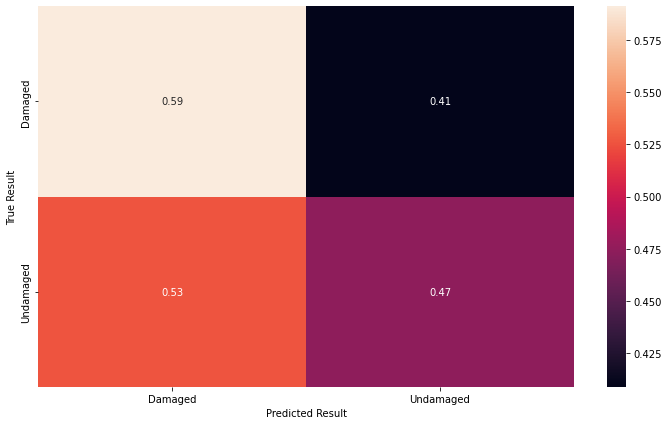

In [15]:
df_cm_ratio = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index=[i for i in labels],
                     columns=[i for i in labels])
plt.figure(figsize=(12, 7))
sn.heatmap(df_cm_ratio, annot=True).set(xlabel='Predicted Result', ylabel='True Result')
# plt.save("Confusion_matrix_ratio.png")

[Text(0.5, 42.0, 'Predicted Result'), Text(87.0, 0.5, 'True Result')]

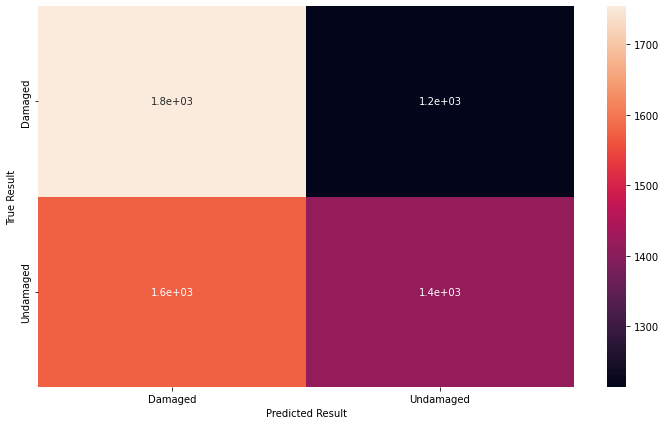

In [16]:
df_cm_raw = pd.DataFrame(cf_matrix, index=[i for i in labels],
                     columns=[i for i in labels])
plt.figure(figsize=(12, 7))
sn.heatmap(df_cm_raw, annot=True).set(xlabel='Predicted Result', ylabel='True Result')
# plt.save("Confusion_matrix_raw.png")

In [17]:
cf_matrix

array([[1754, 1214],
       [1573, 1416]])

In [18]:
len(data_loader_test) 
#for inputs in data_loader_test:

for inputs in data_loader_train:
    print(inputs)

[tensor([[[[0.0742, 0.0742, 0.0742,  ..., 0.0742, 0.0742, 0.0742],
          [0.0742, 0.0742, 0.0742,  ..., 0.0742, 0.0742, 0.0742],
          [0.0742, 0.0742, 0.0742,  ..., 0.0742, 0.0742, 0.0742],
          ...,
          [0.0742, 0.0742, 0.0742,  ..., 0.0742, 0.0742, 0.0742],
          [0.0742, 0.0742, 0.0742,  ..., 0.0742, 0.0742, 0.0742],
          [0.0742, 0.0742, 0.0742,  ..., 0.0742, 0.0742, 0.0742]]],


        [[[0.0461, 0.0461, 0.0461,  ..., 0.0461, 0.0461, 0.0461],
          [0.0461, 0.0461, 0.0461,  ..., 0.0461, 0.0461, 0.0461],
          [0.0461, 0.0461, 0.0461,  ..., 0.0461, 0.0461, 0.0461],
          ...,
          [0.0461, 0.0461, 0.0461,  ..., 0.0461, 0.0461, 0.0461],
          [0.0461, 0.0461, 0.0461,  ..., 0.0461, 0.0461, 0.0461],
          [0.0461, 0.0461, 0.0461,  ..., 0.0461, 0.0461, 0.0461]]],


        [[[0.0538, 0.0538, 0.0538,  ..., 0.0538, 0.0538, 0.0538],
          [0.0538, 0.0538, 0.0538,  ..., 0.0538, 0.0538, 0.0538],
          [0.0538, 0.0538, 0.0538,  .

[tensor([[[[0.0538, 0.0538, 0.0538,  ..., 0.0538, 0.0538, 0.0538],
          [0.0538, 0.0538, 0.0538,  ..., 0.0538, 0.0538, 0.0538],
          [0.0538, 0.0538, 0.0538,  ..., 0.0538, 0.0538, 0.0538],
          ...,
          [0.0538, 0.0538, 0.0538,  ..., 0.0538, 0.0538, 0.0538],
          [0.0538, 0.0538, 0.0538,  ..., 0.0538, 0.0538, 0.0538],
          [0.0538, 0.0538, 0.0538,  ..., 0.0538, 0.0538, 0.0538]]],


        [[[0.0790, 0.0790, 0.0790,  ..., 0.0790, 0.0790, 0.0790],
          [0.0790, 0.0790, 0.0790,  ..., 0.0790, 0.0790, 0.0790],
          [0.0790, 0.0790, 0.0790,  ..., 0.0790, 0.0790, 0.0790],
          ...,
          [0.0790, 0.0790, 0.0790,  ..., 0.0790, 0.0790, 0.0790],
          [0.0790, 0.0790, 0.0790,  ..., 0.0790, 0.0790, 0.0790],
          [0.0790, 0.0790, 0.0790,  ..., 0.0790, 0.0790, 0.0790]]],


        [[[0.0694, 0.0694, 0.0694,  ..., 0.0694, 0.0694, 0.0694],
          [0.0694, 0.0694, 0.0694,  ..., 0.0694, 0.0694, 0.0694],
          [0.0694, 0.0694, 0.0694,  .

[tensor([[[[0.0417, 0.0417, 0.0417,  ..., 0.0417, 0.0417, 0.0417],
          [0.0417, 0.0417, 0.0417,  ..., 0.0417, 0.0417, 0.0417],
          [0.0417, 0.0417, 0.0417,  ..., 0.0417, 0.0417, 0.0417],
          ...,
          [0.0417, 0.0417, 0.0417,  ..., 0.0417, 0.0417, 0.0417],
          [0.0417, 0.0417, 0.0417,  ..., 0.0417, 0.0417, 0.0417],
          [0.0417, 0.0417, 0.0417,  ..., 0.0417, 0.0417, 0.0417]]],


        [[[0.0706, 0.0706, 0.0706,  ..., 0.0706, 0.0706, 0.0706],
          [0.0706, 0.0706, 0.0706,  ..., 0.0706, 0.0706, 0.0706],
          [0.0706, 0.0706, 0.0706,  ..., 0.0706, 0.0706, 0.0706],
          ...,
          [0.0706, 0.0706, 0.0706,  ..., 0.0706, 0.0706, 0.0706],
          [0.0706, 0.0706, 0.0706,  ..., 0.0706, 0.0706, 0.0706],
          [0.0706, 0.0706, 0.0706,  ..., 0.0706, 0.0706, 0.0706]]],


        [[[0.0583, 0.0583, 0.0583,  ..., 0.0583, 0.0583, 0.0583],
          [0.0583, 0.0583, 0.0583,  ..., 0.0583, 0.0583, 0.0583],
          [0.0583, 0.0583, 0.0583,  .

[tensor([[[[0.0239, 0.0239, 0.0239,  ..., 0.0239, 0.0239, 0.0239],
          [0.0239, 0.0239, 0.0239,  ..., 0.0239, 0.0239, 0.0239],
          [0.0239, 0.0239, 0.0239,  ..., 0.0239, 0.0239, 0.0239],
          ...,
          [0.0239, 0.0239, 0.0239,  ..., 0.0239, 0.0239, 0.0239],
          [0.0239, 0.0239, 0.0239,  ..., 0.0239, 0.0239, 0.0239],
          [0.0239, 0.0239, 0.0239,  ..., 0.0239, 0.0239, 0.0239]]],


        [[[0.0671, 0.0671, 0.0671,  ..., 0.0671, 0.0671, 0.0671],
          [0.0671, 0.0671, 0.0671,  ..., 0.0671, 0.0671, 0.0671],
          [0.0671, 0.0671, 0.0671,  ..., 0.0671, 0.0671, 0.0671],
          ...,
          [0.0671, 0.0671, 0.0671,  ..., 0.0671, 0.0671, 0.0671],
          [0.0671, 0.0671, 0.0671,  ..., 0.0671, 0.0671, 0.0671],
          [0.0671, 0.0671, 0.0671,  ..., 0.0671, 0.0671, 0.0671]]],


        [[[0.1234, 0.1234, 0.1234,  ..., 0.1234, 0.1234, 0.1234],
          [0.1234, 0.1234, 0.1234,  ..., 0.1234, 0.1234, 0.1234],
          [0.1234, 0.1234, 0.1234,  .

[tensor([[[[0.0632, 0.0632, 0.0632,  ..., 0.0632, 0.0632, 0.0632],
          [0.0632, 0.0632, 0.0632,  ..., 0.0632, 0.0632, 0.0632],
          [0.0632, 0.0632, 0.0632,  ..., 0.0632, 0.0632, 0.0632],
          ...,
          [0.0632, 0.0632, 0.0632,  ..., 0.0632, 0.0632, 0.0632],
          [0.0632, 0.0632, 0.0632,  ..., 0.0632, 0.0632, 0.0632],
          [0.0632, 0.0632, 0.0632,  ..., 0.0632, 0.0632, 0.0632]]],


        [[[0.0619, 0.0619, 0.0619,  ..., 0.0619, 0.0619, 0.0619],
          [0.0619, 0.0619, 0.0619,  ..., 0.0619, 0.0619, 0.0619],
          [0.0619, 0.0619, 0.0619,  ..., 0.0619, 0.0619, 0.0619],
          ...,
          [0.0619, 0.0619, 0.0619,  ..., 0.0619, 0.0619, 0.0619],
          [0.0619, 0.0619, 0.0619,  ..., 0.0619, 0.0619, 0.0619],
          [0.0619, 0.0619, 0.0619,  ..., 0.0619, 0.0619, 0.0619]]],


        [[[0.0268, 0.0268, 0.0268,  ..., 0.0268, 0.0268, 0.0268],
          [0.0268, 0.0268, 0.0268,  ..., 0.0268, 0.0268, 0.0268],
          [0.0268, 0.0268, 0.0268,  .

[tensor([[[[0.0515, 0.0515, 0.0515,  ..., 0.0515, 0.0515, 0.0515],
          [0.0515, 0.0515, 0.0515,  ..., 0.0515, 0.0515, 0.0515],
          [0.0515, 0.0515, 0.0515,  ..., 0.0515, 0.0515, 0.0515],
          ...,
          [0.0515, 0.0515, 0.0515,  ..., 0.0515, 0.0515, 0.0515],
          [0.0515, 0.0515, 0.0515,  ..., 0.0515, 0.0515, 0.0515],
          [0.0515, 0.0515, 0.0515,  ..., 0.0515, 0.0515, 0.0515]]],


        [[[0.0651, 0.0651, 0.0651,  ..., 0.0651, 0.0651, 0.0651],
          [0.0651, 0.0651, 0.0651,  ..., 0.0651, 0.0651, 0.0651],
          [0.0651, 0.0651, 0.0651,  ..., 0.0651, 0.0651, 0.0651],
          ...,
          [0.0651, 0.0651, 0.0651,  ..., 0.0651, 0.0651, 0.0651],
          [0.0651, 0.0651, 0.0651,  ..., 0.0651, 0.0651, 0.0651],
          [0.0651, 0.0651, 0.0651,  ..., 0.0651, 0.0651, 0.0651]]],


        [[[0.0649, 0.0649, 0.0649,  ..., 0.0649, 0.0649, 0.0649],
          [0.0649, 0.0649, 0.0649,  ..., 0.0649, 0.0649, 0.0649],
          [0.0649, 0.0649, 0.0649,  .

[tensor([[[[0.0271, 0.0271, 0.0271,  ..., 0.0271, 0.0271, 0.0271],
          [0.0271, 0.0271, 0.0271,  ..., 0.0271, 0.0271, 0.0271],
          [0.0271, 0.0271, 0.0271,  ..., 0.0271, 0.0271, 0.0271],
          ...,
          [0.0271, 0.0271, 0.0271,  ..., 0.0271, 0.0271, 0.0271],
          [0.0271, 0.0271, 0.0271,  ..., 0.0271, 0.0271, 0.0271],
          [0.0271, 0.0271, 0.0271,  ..., 0.0271, 0.0271, 0.0271]]],


        [[[0.0632, 0.0632, 0.0632,  ..., 0.0632, 0.0632, 0.0632],
          [0.0632, 0.0632, 0.0632,  ..., 0.0632, 0.0632, 0.0632],
          [0.0632, 0.0632, 0.0632,  ..., 0.0632, 0.0632, 0.0632],
          ...,
          [0.0632, 0.0632, 0.0632,  ..., 0.0632, 0.0632, 0.0632],
          [0.0632, 0.0632, 0.0632,  ..., 0.0632, 0.0632, 0.0632],
          [0.0632, 0.0632, 0.0632,  ..., 0.0632, 0.0632, 0.0632]]],


        [[[0.0781, 0.0781, 0.0781,  ..., 0.0781, 0.0781, 0.0781],
          [0.0781, 0.0781, 0.0781,  ..., 0.0781, 0.0781, 0.0781],
          [0.0781, 0.0781, 0.0781,  .

[tensor([[[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]]],


        [[[0.0764, 0.0764, 0.0764,  ..., 0.0764, 0.0764, 0.0764],
          [0.0764, 0.0764, 0.0764,  ..., 0.0764, 0.0764, 0.0764],
          [0.0764, 0.0764, 0.0764,  ..., 0.0764, 0.0764, 0.0764],
          ...,
          [0.0764, 0.0764, 0.0764,  ..., 0.0764, 0.0764, 0.0764],
          [0.0764, 0.0764, 0.0764,  ..., 0.0764, 0.0764, 0.0764],
          [0.0764, 0.0764, 0.0764,  ..., 0.0764, 0.0764, 0.0764]]],


        [[[0.0288, 0.0288, 0.0288,  ..., 0.0288, 0.0288, 0.0288],
          [0.0288, 0.0288, 0.0288,  ..., 0.0288, 0.0288, 0.0288],
          [0.0288, 0.0288, 0.0288,  .

[tensor([[[[0.0868, 0.0868, 0.0868,  ..., 0.0868, 0.0868, 0.0868],
          [0.0868, 0.0868, 0.0868,  ..., 0.0868, 0.0868, 0.0868],
          [0.0868, 0.0868, 0.0868,  ..., 0.0868, 0.0868, 0.0868],
          ...,
          [0.0868, 0.0868, 0.0868,  ..., 0.0868, 0.0868, 0.0868],
          [0.0868, 0.0868, 0.0868,  ..., 0.0868, 0.0868, 0.0868],
          [0.0868, 0.0868, 0.0868,  ..., 0.0868, 0.0868, 0.0868]]],


        [[[0.0650, 0.0650, 0.0650,  ..., 0.0650, 0.0650, 0.0650],
          [0.0650, 0.0650, 0.0650,  ..., 0.0650, 0.0650, 0.0650],
          [0.0650, 0.0650, 0.0650,  ..., 0.0650, 0.0650, 0.0650],
          ...,
          [0.0650, 0.0650, 0.0650,  ..., 0.0650, 0.0650, 0.0650],
          [0.0650, 0.0650, 0.0650,  ..., 0.0650, 0.0650, 0.0650],
          [0.0650, 0.0650, 0.0650,  ..., 0.0650, 0.0650, 0.0650]]],


        [[[0.0528, 0.0528, 0.0528,  ..., 0.0528, 0.0528, 0.0528],
          [0.0528, 0.0528, 0.0528,  ..., 0.0528, 0.0528, 0.0528],
          [0.0528, 0.0528, 0.0528,  .

[tensor([[[[0.1002, 0.1002, 0.1002,  ..., 0.1002, 0.1002, 0.1002],
          [0.1002, 0.1002, 0.1002,  ..., 0.1002, 0.1002, 0.1002],
          [0.1002, 0.1002, 0.1002,  ..., 0.1002, 0.1002, 0.1002],
          ...,
          [0.1002, 0.1002, 0.1002,  ..., 0.1002, 0.1002, 0.1002],
          [0.1002, 0.1002, 0.1002,  ..., 0.1002, 0.1002, 0.1002],
          [0.1002, 0.1002, 0.1002,  ..., 0.1002, 0.1002, 0.1002]]],


        [[[0.0779, 0.0779, 0.0779,  ..., 0.0779, 0.0779, 0.0779],
          [0.0779, 0.0779, 0.0779,  ..., 0.0779, 0.0779, 0.0779],
          [0.0779, 0.0779, 0.0779,  ..., 0.0779, 0.0779, 0.0779],
          ...,
          [0.0779, 0.0779, 0.0779,  ..., 0.0779, 0.0779, 0.0779],
          [0.0779, 0.0779, 0.0779,  ..., 0.0779, 0.0779, 0.0779],
          [0.0779, 0.0779, 0.0779,  ..., 0.0779, 0.0779, 0.0779]]],


        [[[0.0599, 0.0599, 0.0599,  ..., 0.0599, 0.0599, 0.0599],
          [0.0599, 0.0599, 0.0599,  ..., 0.0599, 0.0599, 0.0599],
          [0.0599, 0.0599, 0.0599,  .

[tensor([[[[0.0578, 0.0578, 0.0578,  ..., 0.0578, 0.0578, 0.0578],
          [0.0578, 0.0578, 0.0578,  ..., 0.0578, 0.0578, 0.0578],
          [0.0578, 0.0578, 0.0578,  ..., 0.0578, 0.0578, 0.0578],
          ...,
          [0.0578, 0.0578, 0.0578,  ..., 0.0578, 0.0578, 0.0578],
          [0.0578, 0.0578, 0.0578,  ..., 0.0578, 0.0578, 0.0578],
          [0.0578, 0.0578, 0.0578,  ..., 0.0578, 0.0578, 0.0578]]],


        [[[0.0754, 0.0754, 0.0754,  ..., 0.0754, 0.0754, 0.0754],
          [0.0754, 0.0754, 0.0754,  ..., 0.0754, 0.0754, 0.0754],
          [0.0754, 0.0754, 0.0754,  ..., 0.0754, 0.0754, 0.0754],
          ...,
          [0.0754, 0.0754, 0.0754,  ..., 0.0754, 0.0754, 0.0754],
          [0.0754, 0.0754, 0.0754,  ..., 0.0754, 0.0754, 0.0754],
          [0.0754, 0.0754, 0.0754,  ..., 0.0754, 0.0754, 0.0754]]],


        [[[0.0638, 0.0638, 0.0638,  ..., 0.0638, 0.0638, 0.0638],
          [0.0638, 0.0638, 0.0638,  ..., 0.0638, 0.0638, 0.0638],
          [0.0638, 0.0638, 0.0638,  .

[tensor([[[[0.0616, 0.0616, 0.0616,  ..., 0.0616, 0.0616, 0.0616],
          [0.0616, 0.0616, 0.0616,  ..., 0.0616, 0.0616, 0.0616],
          [0.0616, 0.0616, 0.0616,  ..., 0.0616, 0.0616, 0.0616],
          ...,
          [0.0616, 0.0616, 0.0616,  ..., 0.0616, 0.0616, 0.0616],
          [0.0616, 0.0616, 0.0616,  ..., 0.0616, 0.0616, 0.0616],
          [0.0616, 0.0616, 0.0616,  ..., 0.0616, 0.0616, 0.0616]]],


        [[[0.0841, 0.0841, 0.0841,  ..., 0.0841, 0.0841, 0.0841],
          [0.0841, 0.0841, 0.0841,  ..., 0.0841, 0.0841, 0.0841],
          [0.0841, 0.0841, 0.0841,  ..., 0.0841, 0.0841, 0.0841],
          ...,
          [0.0841, 0.0841, 0.0841,  ..., 0.0841, 0.0841, 0.0841],
          [0.0841, 0.0841, 0.0841,  ..., 0.0841, 0.0841, 0.0841],
          [0.0841, 0.0841, 0.0841,  ..., 0.0841, 0.0841, 0.0841]]],


        [[[0.0595, 0.0595, 0.0000,  ..., 0.0595, 0.0595, 0.0595],
          [0.0595, 0.0595, 0.0000,  ..., 0.0595, 0.0595, 0.0595],
          [0.0595, 0.0595, 0.0000,  .

[tensor([[[[0.1361, 0.1361, 0.1361,  ..., 0.1361, 0.1361, 0.1361],
          [0.1361, 0.1361, 0.1361,  ..., 0.1361, 0.1361, 0.1361],
          [0.1361, 0.1361, 0.1361,  ..., 0.1361, 0.1361, 0.1361],
          ...,
          [0.1361, 0.1361, 0.1361,  ..., 0.1361, 0.1361, 0.1361],
          [0.1361, 0.1361, 0.1361,  ..., 0.1361, 0.1361, 0.1361],
          [0.1361, 0.1361, 0.1361,  ..., 0.1361, 0.1361, 0.1361]]],


        [[[0.0725, 0.0725, 0.0725,  ..., 0.0725, 0.0725, 0.0725],
          [0.0725, 0.0725, 0.0725,  ..., 0.0725, 0.0725, 0.0725],
          [0.0725, 0.0725, 0.0725,  ..., 0.0725, 0.0725, 0.0725],
          ...,
          [0.0725, 0.0725, 0.0725,  ..., 0.0725, 0.0725, 0.0725],
          [0.0725, 0.0725, 0.0725,  ..., 0.0725, 0.0725, 0.0725],
          [0.0725, 0.0725, 0.0725,  ..., 0.0725, 0.0725, 0.0725]]],


        [[[0.0428, 0.0428, 0.0428,  ..., 0.0428, 0.0428, 0.0428],
          [0.0428, 0.0428, 0.0428,  ..., 0.0428, 0.0428, 0.0428],
          [0.0428, 0.0428, 0.0428,  .

[tensor([[[[0.0677, 0.0677, 0.0677,  ..., 0.0677, 0.0677, 0.0677],
          [0.0677, 0.0677, 0.0677,  ..., 0.0677, 0.0677, 0.0677],
          [0.0677, 0.0677, 0.0677,  ..., 0.0677, 0.0677, 0.0677],
          ...,
          [0.0677, 0.0677, 0.0677,  ..., 0.0677, 0.0677, 0.0677],
          [0.0677, 0.0677, 0.0677,  ..., 0.0677, 0.0677, 0.0677],
          [0.0677, 0.0677, 0.0677,  ..., 0.0677, 0.0677, 0.0677]]],


        [[[0.0536, 0.0536, 0.0536,  ..., 0.0536, 0.0536, 0.0536],
          [0.0536, 0.0536, 0.0536,  ..., 0.0536, 0.0536, 0.0536],
          [0.0536, 0.0536, 0.0536,  ..., 0.0536, 0.0536, 0.0536],
          ...,
          [0.0536, 0.0536, 0.0536,  ..., 0.0536, 0.0536, 0.0536],
          [0.0536, 0.0536, 0.0536,  ..., 0.0536, 0.0536, 0.0536],
          [0.0536, 0.0536, 0.0536,  ..., 0.0536, 0.0536, 0.0536]]],


        [[[0.0824, 0.0824, 0.0824,  ..., 0.0824, 0.0824, 0.0824],
          [0.0824, 0.0824, 0.0824,  ..., 0.0824, 0.0824, 0.0824],
          [0.0824, 0.0824, 0.0824,  .

[tensor([[[[0.0468, 0.0468, 0.0468,  ..., 0.0468, 0.0468, 0.0468],
          [0.0468, 0.0468, 0.0468,  ..., 0.0468, 0.0468, 0.0468],
          [0.0468, 0.0468, 0.0468,  ..., 0.0468, 0.0468, 0.0468],
          ...,
          [0.0468, 0.0468, 0.0468,  ..., 0.0468, 0.0468, 0.0468],
          [0.0468, 0.0468, 0.0468,  ..., 0.0468, 0.0468, 0.0468],
          [0.0468, 0.0468, 0.0468,  ..., 0.0468, 0.0468, 0.0468]]],


        [[[0.0583, 0.0583, 0.0583,  ..., 0.0583, 0.0583, 0.0583],
          [0.0583, 0.0583, 0.0583,  ..., 0.0583, 0.0583, 0.0583],
          [0.0583, 0.0583, 0.0583,  ..., 0.0583, 0.0583, 0.0583],
          ...,
          [0.0583, 0.0583, 0.0583,  ..., 0.0583, 0.0583, 0.0583],
          [0.0583, 0.0583, 0.0583,  ..., 0.0583, 0.0583, 0.0583],
          [0.0583, 0.0583, 0.0583,  ..., 0.0583, 0.0583, 0.0583]]],


        [[[0.0381, 0.0381, 0.0381,  ..., 0.0381, 0.0381, 0.0381],
          [0.0381, 0.0381, 0.0381,  ..., 0.0381, 0.0381, 0.0381],
          [0.0381, 0.0381, 0.0381,  .

[tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0726, 0.0726, 0.0726,  ..., 0.0726, 0.0726, 0.0726],
          [0.0726, 0.0726, 0.0726,  ..., 0.0726, 0.0726, 0.0726],
          [0.0726, 0.0726, 0.0726,  ..., 0.0726, 0.0726, 0.0726],
          ...,
          [0.0726, 0.0726, 0.0726,  ..., 0.0726, 0.0726, 0.0726],
          [0.0726, 0.0726, 0.0726,  ..., 0.0726, 0.0726, 0.0726],
          [0.0726, 0.0726, 0.0726,  ..., 0.0726, 0.0726, 0.0726]]],


        [[[0.0519, 0.0519, 0.0519,  ..., 0.0519, 0.0519, 0.0519],
          [0.0519, 0.0519, 0.0519,  ..., 0.0519, 0.0519, 0.0519],
          [0.0519, 0.0519, 0.0519,  .

[tensor([[[[0.0565, 0.0565, 0.0565,  ..., 0.0565, 0.0565, 0.0565],
          [0.0565, 0.0565, 0.0565,  ..., 0.0565, 0.0565, 0.0565],
          [0.0565, 0.0565, 0.0565,  ..., 0.0565, 0.0565, 0.0565],
          ...,
          [0.0565, 0.0565, 0.0565,  ..., 0.0565, 0.0565, 0.0565],
          [0.0565, 0.0565, 0.0565,  ..., 0.0565, 0.0565, 0.0565],
          [0.0565, 0.0565, 0.0565,  ..., 0.0565, 0.0565, 0.0565]]],


        [[[0.0444, 0.0444, 0.0444,  ..., 0.0444, 0.0444, 0.0444],
          [0.0444, 0.0444, 0.0444,  ..., 0.0444, 0.0444, 0.0444],
          [0.0444, 0.0444, 0.0444,  ..., 0.0444, 0.0444, 0.0444],
          ...,
          [0.0444, 0.0444, 0.0444,  ..., 0.0444, 0.0444, 0.0444],
          [0.0444, 0.0444, 0.0444,  ..., 0.0444, 0.0444, 0.0444],
          [0.0444, 0.0444, 0.0444,  ..., 0.0444, 0.0444, 0.0444]]],


        [[[0.1140, 0.1140, 0.1140,  ..., 0.1140, 0.1140, 0.1140],
          [0.1140, 0.1140, 0.1140,  ..., 0.1140, 0.1140, 0.1140],
          [0.1140, 0.1140, 0.1140,  .

[tensor([[[[0.0202, 0.0202, 0.0202,  ..., 0.0202, 0.0202, 0.0202],
          [0.0202, 0.0202, 0.0202,  ..., 0.0202, 0.0202, 0.0202],
          [0.0202, 0.0202, 0.0202,  ..., 0.0202, 0.0202, 0.0202],
          ...,
          [0.0202, 0.0202, 0.0202,  ..., 0.0202, 0.0202, 0.0202],
          [0.0202, 0.0202, 0.0202,  ..., 0.0202, 0.0202, 0.0202],
          [0.0202, 0.0202, 0.0202,  ..., 0.0202, 0.0202, 0.0202]]],


        [[[0.0710, 0.0710, 0.0710,  ..., 0.0710, 0.0710, 0.0710],
          [0.0710, 0.0710, 0.0710,  ..., 0.0710, 0.0710, 0.0710],
          [0.0710, 0.0710, 0.0710,  ..., 0.0710, 0.0710, 0.0710],
          ...,
          [0.0710, 0.0710, 0.0710,  ..., 0.0710, 0.0710, 0.0710],
          [0.0710, 0.0710, 0.0710,  ..., 0.0710, 0.0710, 0.0710],
          [0.0710, 0.0710, 0.0710,  ..., 0.0710, 0.0710, 0.0710]]],


        [[[0.0672, 0.0672, 0.0672,  ..., 0.0672, 0.0672, 0.0672],
          [0.0672, 0.0672, 0.0672,  ..., 0.0672, 0.0672, 0.0672],
          [0.0672, 0.0672, 0.0672,  .

[tensor([[[[0.0383, 0.0383, 0.0383,  ..., 0.0383, 0.0383, 0.0383],
          [0.0383, 0.0383, 0.0383,  ..., 0.0383, 0.0383, 0.0383],
          [0.0383, 0.0383, 0.0383,  ..., 0.0383, 0.0383, 0.0383],
          ...,
          [0.0383, 0.0383, 0.0383,  ..., 0.0383, 0.0383, 0.0383],
          [0.0383, 0.0383, 0.0383,  ..., 0.0383, 0.0383, 0.0383],
          [0.0383, 0.0383, 0.0383,  ..., 0.0383, 0.0383, 0.0383]]],


        [[[0.0269, 0.0269, 0.0269,  ..., 0.0269, 0.0269, 0.0269],
          [0.0269, 0.0269, 0.0269,  ..., 0.0269, 0.0269, 0.0269],
          [0.0269, 0.0269, 0.0269,  ..., 0.0269, 0.0269, 0.0269],
          ...,
          [0.0269, 0.0269, 0.0269,  ..., 0.0269, 0.0269, 0.0269],
          [0.0269, 0.0269, 0.0269,  ..., 0.0269, 0.0269, 0.0269],
          [0.0269, 0.0269, 0.0269,  ..., 0.0269, 0.0269, 0.0269]]],


        [[[0.0378, 0.0378, 0.0378,  ..., 0.0378, 0.0378, 0.0378],
          [0.0378, 0.0378, 0.0378,  ..., 0.0378, 0.0378, 0.0378],
          [0.0378, 0.0378, 0.0378,  .

[tensor([[[[0.0895, 0.0895, 0.0895,  ..., 0.0895, 0.0895, 0.0895],
          [0.0895, 0.0895, 0.0895,  ..., 0.0895, 0.0895, 0.0895],
          [0.0895, 0.0895, 0.0895,  ..., 0.0895, 0.0895, 0.0895],
          ...,
          [0.0895, 0.0895, 0.0895,  ..., 0.0895, 0.0895, 0.0895],
          [0.0895, 0.0895, 0.0895,  ..., 0.0895, 0.0895, 0.0895],
          [0.0895, 0.0895, 0.0895,  ..., 0.0895, 0.0895, 0.0895]]],


        [[[0.0633, 0.0633, 0.0633,  ..., 0.0633, 0.0633, 0.0633],
          [0.0633, 0.0633, 0.0633,  ..., 0.0633, 0.0633, 0.0633],
          [0.0633, 0.0633, 0.0633,  ..., 0.0633, 0.0633, 0.0633],
          ...,
          [0.0633, 0.0633, 0.0633,  ..., 0.0633, 0.0633, 0.0633],
          [0.0633, 0.0633, 0.0633,  ..., 0.0633, 0.0633, 0.0633],
          [0.0633, 0.0633, 0.0633,  ..., 0.0633, 0.0633, 0.0633]]],


        [[[0.0924, 0.0924, 0.0924,  ..., 0.0924, 0.0924, 0.0924],
          [0.0924, 0.0924, 0.0924,  ..., 0.0924, 0.0924, 0.0924],
          [0.0924, 0.0924, 0.0924,  .

[tensor([[[[0.0796, 0.0796, 0.0796,  ..., 0.0796, 0.0796, 0.0796],
          [0.0796, 0.0796, 0.0796,  ..., 0.0796, 0.0796, 0.0796],
          [0.0796, 0.0796, 0.0796,  ..., 0.0796, 0.0796, 0.0796],
          ...,
          [0.0796, 0.0796, 0.0796,  ..., 0.0796, 0.0796, 0.0796],
          [0.0796, 0.0796, 0.0796,  ..., 0.0796, 0.0796, 0.0796],
          [0.0796, 0.0796, 0.0796,  ..., 0.0796, 0.0796, 0.0796]]],


        [[[0.0262, 0.0262, 0.0262,  ..., 0.0262, 0.0262, 0.0262],
          [0.0262, 0.0262, 0.0262,  ..., 0.0262, 0.0262, 0.0262],
          [0.0262, 0.0262, 0.0262,  ..., 0.0262, 0.0262, 0.0262],
          ...,
          [0.0262, 0.0262, 0.0262,  ..., 0.0262, 0.0262, 0.0262],
          [0.0262, 0.0262, 0.0262,  ..., 0.0262, 0.0262, 0.0262],
          [0.0262, 0.0262, 0.0262,  ..., 0.0262, 0.0262, 0.0262]]],


        [[[0.0680, 0.0000, 0.0000,  ..., 0.0680, 0.0680, 0.0680],
          [0.0680, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0680, 0.0000, 0.0000,  .

[tensor([[[[0.0545, 0.0545, 0.0545,  ..., 0.0545, 0.0545, 0.0545],
          [0.0545, 0.0545, 0.0545,  ..., 0.0545, 0.0545, 0.0545],
          [0.0545, 0.0545, 0.0545,  ..., 0.0545, 0.0545, 0.0545],
          ...,
          [0.0545, 0.0545, 0.0545,  ..., 0.0545, 0.0545, 0.0545],
          [0.0545, 0.0545, 0.0545,  ..., 0.0545, 0.0545, 0.0545],
          [0.0545, 0.0545, 0.0545,  ..., 0.0545, 0.0545, 0.0545]]],


        [[[0.0550, 0.0550, 0.0550,  ..., 0.0550, 0.0550, 0.0550],
          [0.0550, 0.0550, 0.0550,  ..., 0.0550, 0.0550, 0.0550],
          [0.0550, 0.0550, 0.0550,  ..., 0.0550, 0.0550, 0.0550],
          ...,
          [0.0550, 0.0550, 0.0550,  ..., 0.0550, 0.0550, 0.0550],
          [0.0550, 0.0550, 0.0550,  ..., 0.0550, 0.0550, 0.0550],
          [0.0550, 0.0550, 0.0550,  ..., 0.0550, 0.0550, 0.0550]]],


        [[[0.0476, 0.0476, 0.0476,  ..., 0.0476, 0.0476, 0.0476],
          [0.0476, 0.0476, 0.0476,  ..., 0.0476, 0.0476, 0.0476],
          [0.0476, 0.0476, 0.0476,  .

[tensor([[[[0.0895, 0.0895, 0.0895,  ..., 0.0895, 0.0895, 0.0895],
          [0.0895, 0.0895, 0.0895,  ..., 0.0895, 0.0895, 0.0895],
          [0.0895, 0.0895, 0.0895,  ..., 0.0895, 0.0895, 0.0895],
          ...,
          [0.0895, 0.0895, 0.0895,  ..., 0.0895, 0.0895, 0.0895],
          [0.0895, 0.0895, 0.0895,  ..., 0.0895, 0.0895, 0.0895],
          [0.0895, 0.0895, 0.0895,  ..., 0.0895, 0.0895, 0.0895]]],


        [[[0.0778, 0.0778, 0.0778,  ..., 0.0778, 0.0778, 0.0778],
          [0.0778, 0.0778, 0.0778,  ..., 0.0778, 0.0778, 0.0778],
          [0.0778, 0.0778, 0.0778,  ..., 0.0778, 0.0778, 0.0778],
          ...,
          [0.0778, 0.0778, 0.0778,  ..., 0.0778, 0.0778, 0.0778],
          [0.0778, 0.0778, 0.0778,  ..., 0.0778, 0.0778, 0.0778],
          [0.0778, 0.0778, 0.0778,  ..., 0.0778, 0.0778, 0.0778]]],


        [[[0.0461, 0.0461, 0.0461,  ..., 0.0461, 0.0461, 0.0461],
          [0.0461, 0.0461, 0.0461,  ..., 0.0461, 0.0461, 0.0461],
          [0.0461, 0.0461, 0.0461,  .

[tensor([[[[0.0636, 0.0636, 0.0636,  ..., 0.0636, 0.0636, 0.0636],
          [0.0636, 0.0636, 0.0636,  ..., 0.0636, 0.0636, 0.0636],
          [0.0636, 0.0636, 0.0636,  ..., 0.0636, 0.0636, 0.0636],
          ...,
          [0.0636, 0.0636, 0.0636,  ..., 0.0636, 0.0636, 0.0636],
          [0.0636, 0.0636, 0.0636,  ..., 0.0636, 0.0636, 0.0636],
          [0.0636, 0.0636, 0.0636,  ..., 0.0636, 0.0636, 0.0636]]],


        [[[0.0257, 0.0257, 0.0257,  ..., 0.0257, 0.0257, 0.0257],
          [0.0257, 0.0257, 0.0257,  ..., 0.0257, 0.0257, 0.0257],
          [0.0257, 0.0257, 0.0257,  ..., 0.0257, 0.0257, 0.0257],
          ...,
          [0.0257, 0.0257, 0.0257,  ..., 0.0257, 0.0257, 0.0257],
          [0.0257, 0.0257, 0.0257,  ..., 0.0257, 0.0257, 0.0257],
          [0.0257, 0.0257, 0.0257,  ..., 0.0257, 0.0257, 0.0257]]],


        [[[0.0386, 0.0386, 0.0386,  ..., 0.0386, 0.0386, 0.0386],
          [0.0386, 0.0386, 0.0386,  ..., 0.0386, 0.0386, 0.0386],
          [0.0386, 0.0386, 0.0386,  .

[tensor([[[[0.0313, 0.0313, 0.0313,  ..., 0.0313, 0.0313, 0.0313],
          [0.0313, 0.0313, 0.0313,  ..., 0.0313, 0.0313, 0.0313],
          [0.0313, 0.0313, 0.0313,  ..., 0.0313, 0.0313, 0.0313],
          ...,
          [0.0313, 0.0313, 0.0313,  ..., 0.0313, 0.0313, 0.0313],
          [0.0313, 0.0313, 0.0313,  ..., 0.0313, 0.0313, 0.0313],
          [0.0313, 0.0313, 0.0313,  ..., 0.0313, 0.0313, 0.0313]]],


        [[[0.0735, 0.0735, 0.0735,  ..., 0.0735, 0.0735, 0.0735],
          [0.0735, 0.0735, 0.0735,  ..., 0.0735, 0.0735, 0.0735],
          [0.0735, 0.0735, 0.0735,  ..., 0.0735, 0.0735, 0.0735],
          ...,
          [0.0735, 0.0735, 0.0735,  ..., 0.0735, 0.0735, 0.0735],
          [0.0735, 0.0735, 0.0735,  ..., 0.0735, 0.0735, 0.0735],
          [0.0735, 0.0735, 0.0735,  ..., 0.0735, 0.0735, 0.0735]]],


        [[[0.0479, 0.0479, 0.0479,  ..., 0.0479, 0.0479, 0.0479],
          [0.0479, 0.0479, 0.0479,  ..., 0.0479, 0.0479, 0.0479],
          [0.0479, 0.0479, 0.0479,  .

[tensor([[[[0.0716, 0.0716, 0.0716,  ..., 0.0716, 0.0716, 0.0716],
          [0.0716, 0.0716, 0.0716,  ..., 0.0716, 0.0716, 0.0716],
          [0.0716, 0.0716, 0.0716,  ..., 0.0716, 0.0716, 0.0716],
          ...,
          [0.0716, 0.0716, 0.0716,  ..., 0.0716, 0.0716, 0.0716],
          [0.0716, 0.0716, 0.0716,  ..., 0.0716, 0.0716, 0.0716],
          [0.0716, 0.0716, 0.0716,  ..., 0.0716, 0.0716, 0.0716]]],


        [[[0.0350, 0.0350, 0.0350,  ..., 0.0350, 0.0350, 0.0350],
          [0.0350, 0.0350, 0.0350,  ..., 0.0350, 0.0350, 0.0350],
          [0.0350, 0.0350, 0.0350,  ..., 0.0350, 0.0350, 0.0350],
          ...,
          [0.0350, 0.0350, 0.0350,  ..., 0.0350, 0.0350, 0.0350],
          [0.0350, 0.0350, 0.0350,  ..., 0.0350, 0.0350, 0.0350],
          [0.0350, 0.0350, 0.0350,  ..., 0.0350, 0.0350, 0.0350]]],


        [[[0.0508, 0.0508, 0.0508,  ..., 0.0508, 0.0508, 0.0508],
          [0.0508, 0.0508, 0.0508,  ..., 0.0508, 0.0508, 0.0508],
          [0.0508, 0.0508, 0.0508,  .

[tensor([[[[0.0509, 0.0509, 0.0509,  ..., 0.0509, 0.0509, 0.0509],
          [0.0509, 0.0509, 0.0509,  ..., 0.0509, 0.0509, 0.0509],
          [0.0509, 0.0509, 0.0509,  ..., 0.0509, 0.0509, 0.0509],
          ...,
          [0.0509, 0.0509, 0.0509,  ..., 0.0509, 0.0509, 0.0509],
          [0.0509, 0.0509, 0.0509,  ..., 0.0509, 0.0509, 0.0509],
          [0.0509, 0.0509, 0.0509,  ..., 0.0509, 0.0509, 0.0509]]],


        [[[0.0351, 0.0351, 0.0000,  ..., 0.0351, 0.0351, 0.0351],
          [0.0351, 0.0351, 0.0000,  ..., 0.0351, 0.0351, 0.0351],
          [0.0351, 0.0351, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0351, 0.0351],
          [0.0351, 0.0351, 0.0351,  ..., 0.0000, 0.0351, 0.0351],
          [0.0351, 0.0351, 0.0351,  ..., 0.0000, 0.0351, 0.0351]]],


        [[[0.0497, 0.0497, 0.0497,  ..., 0.0497, 0.0497, 0.0497],
          [0.0497, 0.0497, 0.0497,  ..., 0.0497, 0.0497, 0.0497],
          [0.0497, 0.0497, 0.0497,  .

[tensor([[[[0.0197, 0.0197, 0.0197,  ..., 0.0197, 0.0197, 0.0197],
          [0.0197, 0.0197, 0.0197,  ..., 0.0197, 0.0197, 0.0197],
          [0.0197, 0.0197, 0.0197,  ..., 0.0197, 0.0197, 0.0197],
          ...,
          [0.0197, 0.0197, 0.0197,  ..., 0.0197, 0.0197, 0.0197],
          [0.0197, 0.0197, 0.0197,  ..., 0.0197, 0.0197, 0.0197],
          [0.0197, 0.0197, 0.0197,  ..., 0.0197, 0.0197, 0.0197]]],


        [[[0.0526, 0.0526, 0.0526,  ..., 0.0526, 0.0526, 0.0526],
          [0.0526, 0.0526, 0.0526,  ..., 0.0526, 0.0526, 0.0526],
          [0.0526, 0.0526, 0.0526,  ..., 0.0526, 0.0526, 0.0526],
          ...,
          [0.0526, 0.0526, 0.0526,  ..., 0.0526, 0.0526, 0.0526],
          [0.0526, 0.0526, 0.0526,  ..., 0.0526, 0.0526, 0.0526],
          [0.0526, 0.0526, 0.0526,  ..., 0.0526, 0.0526, 0.0526]]],


        [[[0.0458, 0.0458, 0.0458,  ..., 0.0000, 0.0458, 0.0458],
          [0.0458, 0.0458, 0.0458,  ..., 0.0000, 0.0458, 0.0458],
          [0.0000, 0.0000, 0.0000,  .

[tensor([[[[0.0315, 0.0315, 0.0315,  ..., 0.0315, 0.0315, 0.0315],
          [0.0315, 0.0315, 0.0315,  ..., 0.0315, 0.0315, 0.0315],
          [0.0315, 0.0315, 0.0315,  ..., 0.0315, 0.0315, 0.0315],
          ...,
          [0.0315, 0.0315, 0.0315,  ..., 0.0315, 0.0315, 0.0315],
          [0.0315, 0.0315, 0.0315,  ..., 0.0315, 0.0315, 0.0315],
          [0.0315, 0.0315, 0.0315,  ..., 0.0315, 0.0315, 0.0315]]],


        [[[0.0290, 0.0290, 0.0290,  ..., 0.0290, 0.0290, 0.0290],
          [0.0290, 0.0290, 0.0290,  ..., 0.0290, 0.0290, 0.0290],
          [0.0290, 0.0290, 0.0290,  ..., 0.0290, 0.0290, 0.0290],
          ...,
          [0.0290, 0.0290, 0.0290,  ..., 0.0290, 0.0290, 0.0290],
          [0.0290, 0.0290, 0.0290,  ..., 0.0290, 0.0290, 0.0290],
          [0.0290, 0.0290, 0.0290,  ..., 0.0290, 0.0290, 0.0290]]],


        [[[0.0509, 0.0509, 0.0509,  ..., 0.0509, 0.0509, 0.0509],
          [0.0509, 0.0509, 0.0509,  ..., 0.0509, 0.0509, 0.0509],
          [0.0509, 0.0509, 0.0509,  .

[tensor([[[[0.0528, 0.0528, 0.0528,  ..., 0.0528, 0.0528, 0.0528],
          [0.0528, 0.0528, 0.0528,  ..., 0.0528, 0.0528, 0.0528],
          [0.0528, 0.0528, 0.0528,  ..., 0.0528, 0.0528, 0.0528],
          ...,
          [0.0528, 0.0528, 0.0528,  ..., 0.0528, 0.0528, 0.0528],
          [0.0528, 0.0528, 0.0528,  ..., 0.0528, 0.0528, 0.0528],
          [0.0528, 0.0528, 0.0528,  ..., 0.0528, 0.0528, 0.0528]]],


        [[[0.0441, 0.0441, 0.0441,  ..., 0.0441, 0.0441, 0.0441],
          [0.0441, 0.0441, 0.0441,  ..., 0.0441, 0.0441, 0.0441],
          [0.0441, 0.0441, 0.0441,  ..., 0.0441, 0.0441, 0.0441],
          ...,
          [0.0441, 0.0441, 0.0441,  ..., 0.0441, 0.0441, 0.0441],
          [0.0441, 0.0441, 0.0441,  ..., 0.0441, 0.0441, 0.0441],
          [0.0441, 0.0441, 0.0441,  ..., 0.0441, 0.0441, 0.0441]]],


        [[[0.0327, 0.0327, 0.0327,  ..., 0.0327, 0.0327, 0.0327],
          [0.0327, 0.0327, 0.0327,  ..., 0.0327, 0.0327, 0.0327],
          [0.0327, 0.0327, 0.0327,  .

[tensor([[[[0.0407, 0.0407, 0.0407,  ..., 0.0407, 0.0407, 0.0407],
          [0.0407, 0.0407, 0.0407,  ..., 0.0407, 0.0407, 0.0407],
          [0.0407, 0.0407, 0.0407,  ..., 0.0407, 0.0407, 0.0407],
          ...,
          [0.0407, 0.0407, 0.0407,  ..., 0.0407, 0.0407, 0.0407],
          [0.0407, 0.0407, 0.0407,  ..., 0.0407, 0.0407, 0.0407],
          [0.0407, 0.0407, 0.0407,  ..., 0.0407, 0.0407, 0.0407]]],


        [[[0.0794, 0.0794, 0.0794,  ..., 0.0000, 0.0000, 0.0794],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0794],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0794],
          ...,
          [0.0794, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0794, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0794, 0.0000, 0.0000,  ..., 0.0794, 0.0794, 0.0794]]],


        [[[0.0612, 0.0612, 0.0612,  ..., 0.0612, 0.0612, 0.0612],
          [0.0612, 0.0612, 0.0612,  ..., 0.0612, 0.0612, 0.0612],
          [0.0612, 0.0612, 0.0612,  .

[tensor([[[[0.0595, 0.0595, 0.0595,  ..., 0.0595, 0.0595, 0.0595],
          [0.0595, 0.0595, 0.0595,  ..., 0.0595, 0.0595, 0.0595],
          [0.0595, 0.0595, 0.0595,  ..., 0.0595, 0.0595, 0.0595],
          ...,
          [0.0595, 0.0595, 0.0595,  ..., 0.0595, 0.0595, 0.0595],
          [0.0595, 0.0595, 0.0595,  ..., 0.0595, 0.0595, 0.0595],
          [0.0595, 0.0595, 0.0595,  ..., 0.0595, 0.0595, 0.0595]]],


        [[[0.0472, 0.0472, 0.0472,  ..., 0.0472, 0.0472, 0.0472],
          [0.0472, 0.0472, 0.0472,  ..., 0.0472, 0.0472, 0.0472],
          [0.0472, 0.0472, 0.0472,  ..., 0.0472, 0.0472, 0.0472],
          ...,
          [0.0472, 0.0472, 0.0472,  ..., 0.0472, 0.0472, 0.0472],
          [0.0472, 0.0472, 0.0472,  ..., 0.0472, 0.0472, 0.0472],
          [0.0472, 0.0472, 0.0472,  ..., 0.0472, 0.0472, 0.0472]]],


        [[[0.0396, 0.0396, 0.0396,  ..., 0.0396, 0.0396, 0.0396],
          [0.0396, 0.0396, 0.0396,  ..., 0.0396, 0.0396, 0.0396],
          [0.0396, 0.0396, 0.0396,  .

[tensor([[[[0.0699, 0.0699, 0.0699,  ..., 0.0699, 0.0699, 0.0699],
          [0.0699, 0.0699, 0.0699,  ..., 0.0699, 0.0699, 0.0699],
          [0.0699, 0.0699, 0.0699,  ..., 0.0699, 0.0699, 0.0699],
          ...,
          [0.0699, 0.0699, 0.0699,  ..., 0.0699, 0.0699, 0.0699],
          [0.0699, 0.0699, 0.0699,  ..., 0.0699, 0.0699, 0.0699],
          [0.0699, 0.0699, 0.0699,  ..., 0.0699, 0.0699, 0.0699]]],


        [[[0.0483, 0.0483, 0.0483,  ..., 0.0483, 0.0483, 0.0483],
          [0.0483, 0.0483, 0.0483,  ..., 0.0483, 0.0483, 0.0483],
          [0.0483, 0.0483, 0.0483,  ..., 0.0483, 0.0483, 0.0483],
          ...,
          [0.0483, 0.0483, 0.0483,  ..., 0.0483, 0.0483, 0.0483],
          [0.0483, 0.0483, 0.0483,  ..., 0.0483, 0.0483, 0.0483],
          [0.0483, 0.0483, 0.0483,  ..., 0.0483, 0.0483, 0.0483]]],


        [[[0.0612, 0.0612, 0.0612,  ..., 0.0000, 0.0000, 0.0612],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0612],
          [0.0000, 0.0000, 0.0000,  .

[tensor([[[[0.0471, 0.0471, 0.0471,  ..., 0.0471, 0.0471, 0.0471],
          [0.0471, 0.0471, 0.0471,  ..., 0.0471, 0.0471, 0.0471],
          [0.0471, 0.0471, 0.0471,  ..., 0.0471, 0.0471, 0.0471],
          ...,
          [0.0471, 0.0471, 0.0471,  ..., 0.0471, 0.0471, 0.0471],
          [0.0471, 0.0471, 0.0471,  ..., 0.0471, 0.0471, 0.0471],
          [0.0471, 0.0471, 0.0471,  ..., 0.0471, 0.0471, 0.0471]]],


        [[[0.0947, 0.0947, 0.0947,  ..., 0.0947, 0.0947, 0.0947],
          [0.0947, 0.0947, 0.0947,  ..., 0.0947, 0.0947, 0.0947],
          [0.0947, 0.0947, 0.0947,  ..., 0.0947, 0.0947, 0.0947],
          ...,
          [0.0947, 0.0947, 0.0947,  ..., 0.0947, 0.0947, 0.0947],
          [0.0947, 0.0947, 0.0947,  ..., 0.0947, 0.0947, 0.0947],
          [0.0947, 0.0947, 0.0947,  ..., 0.0947, 0.0947, 0.0947]]],


        [[[0.0389, 0.0389, 0.0389,  ..., 0.0389, 0.0389, 0.0389],
          [0.0389, 0.0389, 0.0389,  ..., 0.0389, 0.0389, 0.0389],
          [0.0389, 0.0389, 0.0389,  .

[tensor([[[[0.0725, 0.0725, 0.0725,  ..., 0.0725, 0.0725, 0.0725],
          [0.0725, 0.0725, 0.0725,  ..., 0.0725, 0.0725, 0.0725],
          [0.0725, 0.0725, 0.0725,  ..., 0.0725, 0.0725, 0.0725],
          ...,
          [0.0725, 0.0725, 0.0725,  ..., 0.0725, 0.0725, 0.0725],
          [0.0725, 0.0725, 0.0725,  ..., 0.0725, 0.0725, 0.0725],
          [0.0725, 0.0725, 0.0725,  ..., 0.0725, 0.0725, 0.0725]]],


        [[[0.0763, 0.0763, 0.0763,  ..., 0.0763, 0.0763, 0.0763],
          [0.0763, 0.0763, 0.0763,  ..., 0.0763, 0.0763, 0.0763],
          [0.0763, 0.0763, 0.0763,  ..., 0.0763, 0.0763, 0.0763],
          ...,
          [0.0763, 0.0763, 0.0763,  ..., 0.0763, 0.0763, 0.0763],
          [0.0763, 0.0763, 0.0763,  ..., 0.0763, 0.0763, 0.0763],
          [0.0763, 0.0763, 0.0763,  ..., 0.0763, 0.0763, 0.0763]]],


        [[[0.0252, 0.0252, 0.0252,  ..., 0.0252, 0.0252, 0.0252],
          [0.0252, 0.0252, 0.0252,  ..., 0.0252, 0.0252, 0.0252],
          [0.0252, 0.0252, 0.0252,  .

[tensor([[[[0.0824, 0.0824, 0.0824,  ..., 0.0824, 0.0824, 0.0824],
          [0.0824, 0.0824, 0.0824,  ..., 0.0824, 0.0824, 0.0824],
          [0.0824, 0.0824, 0.0824,  ..., 0.0824, 0.0824, 0.0824],
          ...,
          [0.0824, 0.0824, 0.0824,  ..., 0.0824, 0.0824, 0.0824],
          [0.0824, 0.0824, 0.0824,  ..., 0.0824, 0.0824, 0.0824],
          [0.0824, 0.0824, 0.0824,  ..., 0.0824, 0.0824, 0.0824]]],


        [[[0.1179, 0.1179, 0.1179,  ..., 0.1179, 0.1179, 0.1179],
          [0.1179, 0.1179, 0.1179,  ..., 0.1179, 0.1179, 0.1179],
          [0.1179, 0.1179, 0.1179,  ..., 0.1179, 0.1179, 0.1179],
          ...,
          [0.1179, 0.1179, 0.1179,  ..., 0.1179, 0.1179, 0.1179],
          [0.1179, 0.1179, 0.1179,  ..., 0.1179, 0.1179, 0.1179],
          [0.1179, 0.1179, 0.1179,  ..., 0.1179, 0.1179, 0.1179]]],


        [[[0.0864, 0.0864, 0.0864,  ..., 0.0864, 0.0864, 0.0864],
          [0.0864, 0.0864, 0.0864,  ..., 0.0864, 0.0864, 0.0864],
          [0.0864, 0.0864, 0.0864,  .

[tensor([[[[0.0478, 0.0478, 0.0478,  ..., 0.0478, 0.0478, 0.0478],
          [0.0478, 0.0478, 0.0478,  ..., 0.0478, 0.0478, 0.0478],
          [0.0478, 0.0478, 0.0478,  ..., 0.0478, 0.0478, 0.0478],
          ...,
          [0.0478, 0.0478, 0.0478,  ..., 0.0478, 0.0478, 0.0478],
          [0.0478, 0.0478, 0.0478,  ..., 0.0478, 0.0478, 0.0478],
          [0.0478, 0.0478, 0.0478,  ..., 0.0478, 0.0478, 0.0478]]],


        [[[0.0506, 0.0506, 0.0506,  ..., 0.0506, 0.0506, 0.0506],
          [0.0506, 0.0506, 0.0506,  ..., 0.0506, 0.0506, 0.0506],
          [0.0506, 0.0506, 0.0506,  ..., 0.0506, 0.0506, 0.0506],
          ...,
          [0.0506, 0.0506, 0.0506,  ..., 0.0506, 0.0506, 0.0506],
          [0.0506, 0.0506, 0.0506,  ..., 0.0506, 0.0506, 0.0506],
          [0.0506, 0.0506, 0.0506,  ..., 0.0506, 0.0506, 0.0506]]],


        [[[0.1095, 0.1095, 0.1095,  ..., 0.1095, 0.1095, 0.1095],
          [0.1095, 0.1095, 0.1095,  ..., 0.1095, 0.1095, 0.1095],
          [0.1095, 0.1095, 0.1095,  .

[tensor([[[[0.0849, 0.0849, 0.0849,  ..., 0.0849, 0.0849, 0.0849],
          [0.0849, 0.0849, 0.0849,  ..., 0.0849, 0.0849, 0.0849],
          [0.0849, 0.0849, 0.0849,  ..., 0.0849, 0.0849, 0.0849],
          ...,
          [0.0849, 0.0849, 0.0849,  ..., 0.0849, 0.0849, 0.0849],
          [0.0849, 0.0849, 0.0849,  ..., 0.0849, 0.0849, 0.0849],
          [0.0849, 0.0849, 0.0849,  ..., 0.0849, 0.0849, 0.0849]]],


        [[[0.0703, 0.0703, 0.0703,  ..., 0.0703, 0.0703, 0.0703],
          [0.0703, 0.0703, 0.0703,  ..., 0.0703, 0.0703, 0.0703],
          [0.0703, 0.0703, 0.0703,  ..., 0.0703, 0.0703, 0.0703],
          ...,
          [0.0703, 0.0703, 0.0703,  ..., 0.0703, 0.0703, 0.0703],
          [0.0703, 0.0703, 0.0703,  ..., 0.0703, 0.0703, 0.0703],
          [0.0703, 0.0703, 0.0703,  ..., 0.0703, 0.0703, 0.0703]]],


        [[[0.1149, 0.1149, 0.1149,  ..., 0.1149, 0.1149, 0.1149],
          [0.1149, 0.1149, 0.1149,  ..., 0.1149, 0.1149, 0.1149],
          [0.1149, 0.1149, 0.1149,  .

[tensor([[[[0.0424, 0.0424, 0.0424,  ..., 0.0424, 0.0424, 0.0424],
          [0.0424, 0.0424, 0.0424,  ..., 0.0424, 0.0424, 0.0424],
          [0.0424, 0.0424, 0.0424,  ..., 0.0424, 0.0424, 0.0424],
          ...,
          [0.0424, 0.0424, 0.0424,  ..., 0.0424, 0.0424, 0.0424],
          [0.0424, 0.0424, 0.0424,  ..., 0.0424, 0.0424, 0.0424],
          [0.0424, 0.0424, 0.0424,  ..., 0.0424, 0.0424, 0.0424]]],


        [[[0.0717, 0.0717, 0.0717,  ..., 0.0000, 0.0000, 0.0717],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0717],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0717],
          ...,
          [0.0717, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0717, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0717, 0.0000, 0.0000,  ..., 0.0717, 0.0717, 0.0717]]],


        [[[0.0813, 0.0813, 0.0813,  ..., 0.0813, 0.0813, 0.0813],
          [0.0813, 0.0813, 0.0813,  ..., 0.0813, 0.0813, 0.0813],
          [0.0813, 0.0813, 0.0813,  .

[tensor([[[[0.0701, 0.0701, 0.0701,  ..., 0.0701, 0.0701, 0.0701],
          [0.0701, 0.0701, 0.0701,  ..., 0.0701, 0.0701, 0.0701],
          [0.0701, 0.0701, 0.0701,  ..., 0.0701, 0.0701, 0.0701],
          ...,
          [0.0701, 0.0701, 0.0701,  ..., 0.0701, 0.0701, 0.0701],
          [0.0701, 0.0701, 0.0701,  ..., 0.0701, 0.0701, 0.0701],
          [0.0701, 0.0701, 0.0701,  ..., 0.0701, 0.0701, 0.0701]]],


        [[[0.0434, 0.0434, 0.0434,  ..., 0.0434, 0.0434, 0.0434],
          [0.0434, 0.0434, 0.0434,  ..., 0.0434, 0.0434, 0.0434],
          [0.0434, 0.0434, 0.0434,  ..., 0.0434, 0.0434, 0.0434],
          ...,
          [0.0434, 0.0434, 0.0434,  ..., 0.0434, 0.0434, 0.0434],
          [0.0434, 0.0434, 0.0434,  ..., 0.0434, 0.0434, 0.0434],
          [0.0434, 0.0434, 0.0434,  ..., 0.0434, 0.0434, 0.0434]]],


        [[[0.0594, 0.0594, 0.0594,  ..., 0.0594, 0.0594, 0.0594],
          [0.0594, 0.0594, 0.0594,  ..., 0.0594, 0.0594, 0.0594],
          [0.0594, 0.0594, 0.0594,  .

[tensor([[[[0.0560, 0.0560, 0.0560,  ..., 0.0560, 0.0560, 0.0560],
          [0.0560, 0.0560, 0.0560,  ..., 0.0560, 0.0560, 0.0560],
          [0.0560, 0.0560, 0.0560,  ..., 0.0560, 0.0560, 0.0560],
          ...,
          [0.0560, 0.0560, 0.0560,  ..., 0.0560, 0.0560, 0.0560],
          [0.0560, 0.0560, 0.0560,  ..., 0.0560, 0.0560, 0.0560],
          [0.0560, 0.0560, 0.0560,  ..., 0.0560, 0.0560, 0.0560]]],


        [[[0.0698, 0.0698, 0.0698,  ..., 0.0698, 0.0698, 0.0698],
          [0.0698, 0.0698, 0.0698,  ..., 0.0698, 0.0698, 0.0698],
          [0.0698, 0.0698, 0.0698,  ..., 0.0698, 0.0698, 0.0698],
          ...,
          [0.0698, 0.0698, 0.0698,  ..., 0.0698, 0.0698, 0.0698],
          [0.0698, 0.0698, 0.0698,  ..., 0.0698, 0.0698, 0.0698],
          [0.0698, 0.0698, 0.0698,  ..., 0.0698, 0.0698, 0.0698]]],


        [[[0.0957, 0.0957, 0.0957,  ..., 0.0957, 0.0957, 0.0957],
          [0.0957, 0.0957, 0.0957,  ..., 0.0957, 0.0957, 0.0957],
          [0.0957, 0.0957, 0.0957,  .

[tensor([[[[0.0512, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0512],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0512, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0512]]],


        [[[0.6788, 0.6788, 0.6788,  ..., 0.6788, 0.6788, 0.6788],
          [0.6788, 0.6788, 0.6788,  ..., 0.6788, 0.6788, 0.6788],
          [0.6788, 0.6788, 0.6788,  ..., 0.6788, 0.6788, 0.6788],
          ...,
          [0.6788, 0.6788, 0.6788,  ..., 0.6788, 0.6788, 0.6788],
          [0.6788, 0.6788, 0.6788,  ..., 0.6788, 0.6788, 0.6788],
          [0.6788, 0.6788, 0.6788,  ..., 0.6788, 0.6788, 0.6788]]],


        [[[0.0667, 0.0667, 0.0667,  ..., 0.0667, 0.0667, 0.0667],
          [0.0667, 0.0667, 0.0667,  ..., 0.0667, 0.0667, 0.0667],
          [0.0667, 0.0667, 0.0667,  .

[tensor([[[[0.0539, 0.0539, 0.0539,  ..., 0.0539, 0.0539, 0.0539],
          [0.0539, 0.0539, 0.0539,  ..., 0.0539, 0.0539, 0.0539],
          [0.0539, 0.0539, 0.0539,  ..., 0.0539, 0.0539, 0.0539],
          ...,
          [0.0539, 0.0539, 0.0539,  ..., 0.0539, 0.0539, 0.0539],
          [0.0539, 0.0539, 0.0539,  ..., 0.0539, 0.0539, 0.0539],
          [0.0539, 0.0539, 0.0539,  ..., 0.0539, 0.0539, 0.0539]]],


        [[[0.0974, 0.0974, 0.0974,  ..., 0.0974, 0.0974, 0.0974],
          [0.0974, 0.0974, 0.0974,  ..., 0.0974, 0.0974, 0.0974],
          [0.0974, 0.0974, 0.0974,  ..., 0.0974, 0.0974, 0.0974],
          ...,
          [0.0974, 0.0974, 0.0974,  ..., 0.0974, 0.0974, 0.0974],
          [0.0974, 0.0974, 0.0974,  ..., 0.0974, 0.0974, 0.0974],
          [0.0974, 0.0974, 0.0974,  ..., 0.0974, 0.0974, 0.0974]]],


        [[[0.0347, 0.0347, 0.0347,  ..., 0.0347, 0.0347, 0.0347],
          [0.0347, 0.0347, 0.0347,  ..., 0.0347, 0.0347, 0.0347],
          [0.0347, 0.0347, 0.0347,  .

[tensor([[[[0.1101, 0.1101, 0.1101,  ..., 0.1101, 0.1101, 0.1101],
          [0.1101, 0.1101, 0.1101,  ..., 0.1101, 0.1101, 0.1101],
          [0.1101, 0.1101, 0.1101,  ..., 0.1101, 0.1101, 0.1101],
          ...,
          [0.1101, 0.1101, 0.1101,  ..., 0.1101, 0.1101, 0.1101],
          [0.1101, 0.1101, 0.1101,  ..., 0.1101, 0.1101, 0.1101],
          [0.1101, 0.1101, 0.1101,  ..., 0.1101, 0.1101, 0.1101]]],


        [[[0.0675, 0.0000, 0.0000,  ..., 0.0675, 0.0675, 0.0675],
          [0.0675, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0675, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0675],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0675],
          [0.0675, 0.0675, 0.0675,  ..., 0.0000, 0.0000, 0.0675]]],


        [[[0.0532, 0.0532, 0.0532,  ..., 0.0532, 0.0532, 0.0532],
          [0.0532, 0.0532, 0.0532,  ..., 0.0532, 0.0532, 0.0532],
          [0.0532, 0.0532, 0.0532,  .

[tensor([[[[0.0685, 0.0685, 0.0685,  ..., 0.0685, 0.0685, 0.0685],
          [0.0685, 0.0685, 0.0685,  ..., 0.0685, 0.0685, 0.0685],
          [0.0685, 0.0685, 0.0685,  ..., 0.0685, 0.0685, 0.0685],
          ...,
          [0.0685, 0.0685, 0.0685,  ..., 0.0685, 0.0685, 0.0685],
          [0.0685, 0.0685, 0.0685,  ..., 0.0685, 0.0685, 0.0685],
          [0.0685, 0.0685, 0.0685,  ..., 0.0685, 0.0685, 0.0685]]],


        [[[0.0578, 0.0578, 0.0578,  ..., 0.0578, 0.0578, 0.0578],
          [0.0578, 0.0578, 0.0578,  ..., 0.0578, 0.0578, 0.0578],
          [0.0578, 0.0578, 0.0578,  ..., 0.0578, 0.0578, 0.0578],
          ...,
          [0.0578, 0.0578, 0.0578,  ..., 0.0578, 0.0578, 0.0578],
          [0.0578, 0.0578, 0.0578,  ..., 0.0578, 0.0578, 0.0578],
          [0.0578, 0.0578, 0.0578,  ..., 0.0578, 0.0578, 0.0578]]],


        [[[0.0691, 0.0691, 0.0691,  ..., 0.0691, 0.0691, 0.0691],
          [0.0691, 0.0691, 0.0691,  ..., 0.0691, 0.0691, 0.0691],
          [0.0691, 0.0691, 0.0691,  .

[tensor([[[[0.0866, 0.0866, 0.0866,  ..., 0.0866, 0.0866, 0.0866],
          [0.0866, 0.0866, 0.0866,  ..., 0.0866, 0.0866, 0.0866],
          [0.0866, 0.0866, 0.0866,  ..., 0.0866, 0.0866, 0.0866],
          ...,
          [0.0866, 0.0866, 0.0866,  ..., 0.0866, 0.0866, 0.0866],
          [0.0866, 0.0866, 0.0866,  ..., 0.0866, 0.0866, 0.0866],
          [0.0866, 0.0866, 0.0866,  ..., 0.0866, 0.0866, 0.0866]]],


        [[[0.0572, 0.0572, 0.0572,  ..., 0.0572, 0.0572, 0.0572],
          [0.0572, 0.0572, 0.0572,  ..., 0.0572, 0.0572, 0.0572],
          [0.0572, 0.0572, 0.0572,  ..., 0.0572, 0.0572, 0.0572],
          ...,
          [0.0572, 0.0572, 0.0572,  ..., 0.0572, 0.0572, 0.0572],
          [0.0572, 0.0572, 0.0572,  ..., 0.0572, 0.0572, 0.0572],
          [0.0572, 0.0572, 0.0572,  ..., 0.0572, 0.0572, 0.0572]]],


        [[[0.0494, 0.0494, 0.0494,  ..., 0.0494, 0.0494, 0.0494],
          [0.0494, 0.0494, 0.0494,  ..., 0.0494, 0.0494, 0.0494],
          [0.0494, 0.0494, 0.0494,  .

[tensor([[[[0.0515, 0.0515, 0.0515,  ..., 0.0000, 0.0515, 0.0515],
          [0.0515, 0.0515, 0.0515,  ..., 0.0000, 0.0515, 0.0515],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0515, 0.0515],
          ...,
          [0.0515, 0.0515, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0515, 0.0515, 0.0000,  ..., 0.0515, 0.0515, 0.0515],
          [0.0515, 0.0515, 0.0000,  ..., 0.0515, 0.0515, 0.0515]]],


        [[[0.0497, 0.0497, 0.0497,  ..., 0.0497, 0.0497, 0.0497],
          [0.0497, 0.0497, 0.0497,  ..., 0.0497, 0.0497, 0.0497],
          [0.0497, 0.0497, 0.0497,  ..., 0.0497, 0.0497, 0.0497],
          ...,
          [0.0497, 0.0497, 0.0497,  ..., 0.0497, 0.0497, 0.0497],
          [0.0497, 0.0497, 0.0497,  ..., 0.0497, 0.0497, 0.0497],
          [0.0497, 0.0497, 0.0497,  ..., 0.0497, 0.0497, 0.0497]]],


        [[[0.0321, 0.0321, 0.0321,  ..., 0.0321, 0.0321, 0.0321],
          [0.0321, 0.0321, 0.0321,  ..., 0.0321, 0.0321, 0.0321],
          [0.0321, 0.0321, 0.0321,  .

[tensor([[[[0.0631, 0.0631, 0.0631,  ..., 0.0631, 0.0631, 0.0631],
          [0.0631, 0.0631, 0.0631,  ..., 0.0631, 0.0631, 0.0631],
          [0.0631, 0.0631, 0.0631,  ..., 0.0631, 0.0631, 0.0631],
          ...,
          [0.0631, 0.0631, 0.0631,  ..., 0.0631, 0.0631, 0.0631],
          [0.0631, 0.0631, 0.0631,  ..., 0.0631, 0.0631, 0.0631],
          [0.0631, 0.0631, 0.0631,  ..., 0.0631, 0.0631, 0.0631]]],


        [[[0.0280, 0.0280, 0.0280,  ..., 0.0280, 0.0280, 0.0280],
          [0.0280, 0.0280, 0.0280,  ..., 0.0280, 0.0280, 0.0280],
          [0.0280, 0.0280, 0.0280,  ..., 0.0280, 0.0280, 0.0280],
          ...,
          [0.0280, 0.0280, 0.0280,  ..., 0.0280, 0.0280, 0.0280],
          [0.0280, 0.0280, 0.0280,  ..., 0.0280, 0.0280, 0.0280],
          [0.0280, 0.0280, 0.0280,  ..., 0.0280, 0.0280, 0.0280]]],


        [[[0.0744, 0.0744, 0.0744,  ..., 0.0744, 0.0744, 0.0744],
          [0.0744, 0.0744, 0.0744,  ..., 0.0744, 0.0744, 0.0744],
          [0.0744, 0.0744, 0.0744,  .

[tensor([[[[1.0000, 1.0000, 1.0000,  ..., 0.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.0000, 1.0000, 1.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [1.0000, 1.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000]]],


        [[[0.0794, 0.0794, 0.0794,  ..., 0.0794, 0.0794, 0.0794],
          [0.0794, 0.0794, 0.0794,  ..., 0.0794, 0.0794, 0.0794],
          [0.0794, 0.0794, 0.0794,  ..., 0.0794, 0.0794, 0.0794],
          ...,
          [0.0794, 0.0794, 0.0794,  ..., 0.0794, 0.0794, 0.0794],
          [0.0794, 0.0794, 0.0794,  ..., 0.0794, 0.0794, 0.0794],
          [0.0794, 0.0794, 0.0794,  ..., 0.0794, 0.0794, 0.0794]]],


        [[[0.0893, 0.0893, 0.0893,  ..., 0.0893, 0.0893, 0.0893],
          [0.0893, 0.0893, 0.0893,  ..., 0.0893, 0.0893, 0.0893],
          [0.0893, 0.0893, 0.0893,  .

[tensor([[[[0.0394, 0.0394, 0.0394,  ..., 0.0394, 0.0394, 0.0394],
          [0.0394, 0.0394, 0.0394,  ..., 0.0394, 0.0394, 0.0394],
          [0.0394, 0.0394, 0.0394,  ..., 0.0394, 0.0394, 0.0394],
          ...,
          [0.0394, 0.0394, 0.0394,  ..., 0.0394, 0.0394, 0.0394],
          [0.0394, 0.0394, 0.0394,  ..., 0.0394, 0.0394, 0.0394],
          [0.0394, 0.0394, 0.0394,  ..., 0.0394, 0.0394, 0.0394]]],


        [[[0.0685, 0.0685, 0.0685,  ..., 0.0685, 0.0685, 0.0685],
          [0.0685, 0.0685, 0.0685,  ..., 0.0685, 0.0685, 0.0685],
          [0.0685, 0.0685, 0.0685,  ..., 0.0685, 0.0685, 0.0685],
          ...,
          [0.0685, 0.0685, 0.0685,  ..., 0.0685, 0.0685, 0.0685],
          [0.0685, 0.0685, 0.0685,  ..., 0.0685, 0.0685, 0.0685],
          [0.0685, 0.0685, 0.0685,  ..., 0.0685, 0.0685, 0.0685]]],


        [[[0.0813, 0.0813, 0.0813,  ..., 0.0813, 0.0813, 0.0813],
          [0.0813, 0.0813, 0.0813,  ..., 0.0813, 0.0813, 0.0813],
          [0.0813, 0.0813, 0.0813,  .

[tensor([[[[0.0521, 0.0521, 0.0521,  ..., 0.0521, 0.0521, 0.0521],
          [0.0521, 0.0521, 0.0521,  ..., 0.0521, 0.0521, 0.0521],
          [0.0521, 0.0521, 0.0521,  ..., 0.0521, 0.0521, 0.0521],
          ...,
          [0.0521, 0.0521, 0.0521,  ..., 0.0521, 0.0521, 0.0521],
          [0.0521, 0.0521, 0.0521,  ..., 0.0521, 0.0521, 0.0521],
          [0.0521, 0.0521, 0.0521,  ..., 0.0521, 0.0521, 0.0521]]],


        [[[0.0536, 0.0536, 0.0536,  ..., 0.0536, 0.0536, 0.0536],
          [0.0536, 0.0536, 0.0536,  ..., 0.0536, 0.0536, 0.0536],
          [0.0536, 0.0536, 0.0536,  ..., 0.0536, 0.0536, 0.0536],
          ...,
          [0.0536, 0.0536, 0.0536,  ..., 0.0536, 0.0536, 0.0536],
          [0.0536, 0.0536, 0.0536,  ..., 0.0536, 0.0536, 0.0536],
          [0.0536, 0.0536, 0.0536,  ..., 0.0536, 0.0536, 0.0536]]],


        [[[0.0429, 0.0429, 0.0429,  ..., 0.0429, 0.0429, 0.0429],
          [0.0429, 0.0429, 0.0429,  ..., 0.0429, 0.0429, 0.0429],
          [0.0429, 0.0429, 0.0429,  .

[tensor([[[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]]],


        [[[0.0607, 0.0607, 0.0607,  ..., 0.0607, 0.0607, 0.0607],
          [0.0607, 0.0607, 0.0607,  ..., 0.0607, 0.0607, 0.0607],
          [0.0607, 0.0607, 0.0607,  ..., 0.0607, 0.0607, 0.0607],
          ...,
          [0.0607, 0.0607, 0.0607,  ..., 0.0607, 0.0607, 0.0607],
          [0.0607, 0.0607, 0.0607,  ..., 0.0607, 0.0607, 0.0607],
          [0.0607, 0.0607, 0.0607,  ..., 0.0607, 0.0607, 0.0607]]],


        [[[0.0559, 0.0559, 0.0559,  ..., 0.0559, 0.0559, 0.0559],
          [0.0559, 0.0559, 0.0559,  ..., 0.0559, 0.0559, 0.0559],
          [0.0559, 0.0559, 0.0559,  .

[tensor([[[[0.0580, 0.0580, 0.0580,  ..., 0.0580, 0.0580, 0.0580],
          [0.0580, 0.0580, 0.0580,  ..., 0.0580, 0.0580, 0.0580],
          [0.0580, 0.0580, 0.0580,  ..., 0.0580, 0.0580, 0.0580],
          ...,
          [0.0580, 0.0580, 0.0580,  ..., 0.0580, 0.0580, 0.0580],
          [0.0580, 0.0580, 0.0580,  ..., 0.0580, 0.0580, 0.0580],
          [0.0580, 0.0580, 0.0580,  ..., 0.0580, 0.0580, 0.0580]]],


        [[[0.0872, 0.0872, 0.0872,  ..., 0.0872, 0.0872, 0.0872],
          [0.0872, 0.0872, 0.0872,  ..., 0.0872, 0.0872, 0.0872],
          [0.0872, 0.0872, 0.0872,  ..., 0.0872, 0.0872, 0.0872],
          ...,
          [0.0872, 0.0872, 0.0872,  ..., 0.0872, 0.0872, 0.0872],
          [0.0872, 0.0872, 0.0872,  ..., 0.0872, 0.0872, 0.0872],
          [0.0872, 0.0872, 0.0872,  ..., 0.0872, 0.0872, 0.0872]]],


        [[[0.0622, 0.0622, 0.0622,  ..., 0.0622, 0.0622, 0.0622],
          [0.0622, 0.0622, 0.0622,  ..., 0.0622, 0.0622, 0.0622],
          [0.0622, 0.0622, 0.0622,  .

[tensor([[[[0.0720, 0.0720, 0.0720,  ..., 0.0720, 0.0720, 0.0720],
          [0.0720, 0.0720, 0.0720,  ..., 0.0720, 0.0720, 0.0720],
          [0.0720, 0.0720, 0.0720,  ..., 0.0720, 0.0720, 0.0720],
          ...,
          [0.0720, 0.0720, 0.0720,  ..., 0.0720, 0.0720, 0.0720],
          [0.0720, 0.0720, 0.0720,  ..., 0.0720, 0.0720, 0.0720],
          [0.0720, 0.0720, 0.0720,  ..., 0.0720, 0.0720, 0.0720]]],


        [[[0.0803, 0.0803, 0.0803,  ..., 0.0803, 0.0803, 0.0803],
          [0.0803, 0.0803, 0.0803,  ..., 0.0803, 0.0803, 0.0803],
          [0.0803, 0.0803, 0.0803,  ..., 0.0803, 0.0803, 0.0803],
          ...,
          [0.0803, 0.0803, 0.0803,  ..., 0.0803, 0.0803, 0.0803],
          [0.0803, 0.0803, 0.0803,  ..., 0.0803, 0.0803, 0.0803],
          [0.0803, 0.0803, 0.0803,  ..., 0.0803, 0.0803, 0.0803]]],


        [[[0.0449, 0.0449, 0.0449,  ..., 0.0449, 0.0449, 0.0449],
          [0.0449, 0.0449, 0.0449,  ..., 0.0449, 0.0449, 0.0449],
          [0.0449, 0.0449, 0.0449,  .

[tensor([[[[0.0579, 0.0579, 0.0579,  ..., 0.0579, 0.0579, 0.0579],
          [0.0579, 0.0579, 0.0579,  ..., 0.0579, 0.0579, 0.0579],
          [0.0579, 0.0579, 0.0579,  ..., 0.0579, 0.0579, 0.0579],
          ...,
          [0.0579, 0.0579, 0.0579,  ..., 0.0579, 0.0579, 0.0579],
          [0.0579, 0.0579, 0.0579,  ..., 0.0579, 0.0579, 0.0579],
          [0.0579, 0.0579, 0.0579,  ..., 0.0579, 0.0579, 0.0579]]],


        [[[0.0987, 0.0987, 0.0987,  ..., 0.0987, 0.0987, 0.0987],
          [0.0987, 0.0987, 0.0987,  ..., 0.0987, 0.0987, 0.0987],
          [0.0987, 0.0987, 0.0987,  ..., 0.0987, 0.0987, 0.0987],
          ...,
          [0.0987, 0.0987, 0.0987,  ..., 0.0987, 0.0987, 0.0987],
          [0.0987, 0.0987, 0.0987,  ..., 0.0987, 0.0987, 0.0987],
          [0.0987, 0.0987, 0.0987,  ..., 0.0987, 0.0987, 0.0987]]],


        [[[0.0503, 0.0503, 0.0503,  ..., 0.0503, 0.0503, 0.0503],
          [0.0503, 0.0503, 0.0503,  ..., 0.0503, 0.0503, 0.0503],
          [0.0503, 0.0503, 0.0503,  .

[tensor([[[[0.0531, 0.0531, 0.0531,  ..., 0.0531, 0.0531, 0.0531],
          [0.0531, 0.0531, 0.0531,  ..., 0.0531, 0.0531, 0.0531],
          [0.0531, 0.0531, 0.0531,  ..., 0.0531, 0.0531, 0.0531],
          ...,
          [0.0531, 0.0531, 0.0531,  ..., 0.0531, 0.0531, 0.0531],
          [0.0531, 0.0531, 0.0531,  ..., 0.0531, 0.0531, 0.0531],
          [0.0531, 0.0531, 0.0531,  ..., 0.0531, 0.0531, 0.0531]]],


        [[[0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
          [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
          [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
          ...,
          [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
          [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
          [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392]]],


        [[[0.0382, 0.0382, 0.0382,  ..., 0.0000, 0.0382, 0.0382],
          [0.0382, 0.0382, 0.0382,  ..., 0.0000, 0.0382, 0.0382],
          [0.0000, 0.0000, 0.0000,  .

[tensor([[[[0.0596, 0.0596, 0.0596,  ..., 0.0596, 0.0596, 0.0596],
          [0.0596, 0.0596, 0.0596,  ..., 0.0596, 0.0596, 0.0596],
          [0.0596, 0.0596, 0.0596,  ..., 0.0596, 0.0596, 0.0596],
          ...,
          [0.0596, 0.0596, 0.0596,  ..., 0.0596, 0.0596, 0.0596],
          [0.0596, 0.0596, 0.0596,  ..., 0.0596, 0.0596, 0.0596],
          [0.0596, 0.0596, 0.0596,  ..., 0.0596, 0.0596, 0.0596]]],


        [[[0.0707, 0.0707, 0.0707,  ..., 0.0707, 0.0707, 0.0707],
          [0.0707, 0.0707, 0.0707,  ..., 0.0707, 0.0707, 0.0707],
          [0.0707, 0.0707, 0.0707,  ..., 0.0707, 0.0707, 0.0707],
          ...,
          [0.0707, 0.0707, 0.0707,  ..., 0.0707, 0.0707, 0.0707],
          [0.0707, 0.0707, 0.0707,  ..., 0.0707, 0.0707, 0.0707],
          [0.0707, 0.0707, 0.0707,  ..., 0.0707, 0.0707, 0.0707]]],


        [[[0.0184, 0.0184, 0.0184,  ..., 0.0184, 0.0184, 0.0184],
          [0.0184, 0.0184, 0.0184,  ..., 0.0184, 0.0184, 0.0184],
          [0.0184, 0.0184, 0.0184,  .

[tensor([[[[0.0596, 0.0596, 0.0596,  ..., 0.0596, 0.0596, 0.0596],
          [0.0596, 0.0596, 0.0596,  ..., 0.0596, 0.0596, 0.0596],
          [0.0596, 0.0596, 0.0596,  ..., 0.0596, 0.0596, 0.0596],
          ...,
          [0.0596, 0.0596, 0.0596,  ..., 0.0596, 0.0596, 0.0596],
          [0.0596, 0.0596, 0.0596,  ..., 0.0596, 0.0596, 0.0596],
          [0.0596, 0.0596, 0.0596,  ..., 0.0596, 0.0596, 0.0596]]],


        [[[0.0620, 0.0620, 0.0620,  ..., 0.0620, 0.0620, 0.0620],
          [0.0620, 0.0620, 0.0620,  ..., 0.0620, 0.0620, 0.0620],
          [0.0620, 0.0620, 0.0620,  ..., 0.0620, 0.0620, 0.0620],
          ...,
          [0.0620, 0.0620, 0.0620,  ..., 0.0620, 0.0620, 0.0620],
          [0.0620, 0.0620, 0.0620,  ..., 0.0620, 0.0620, 0.0620],
          [0.0620, 0.0620, 0.0620,  ..., 0.0620, 0.0620, 0.0620]]],


        [[[0.0429, 0.0429, 0.0429,  ..., 0.0429, 0.0429, 0.0429],
          [0.0429, 0.0429, 0.0429,  ..., 0.0429, 0.0429, 0.0429],
          [0.0429, 0.0429, 0.0429,  .

[tensor([[[[0.1175, 0.1175, 0.1175,  ..., 0.1175, 0.1175, 0.1175],
          [0.1175, 0.1175, 0.1175,  ..., 0.1175, 0.1175, 0.1175],
          [0.1175, 0.1175, 0.1175,  ..., 0.1175, 0.1175, 0.1175],
          ...,
          [0.1175, 0.1175, 0.1175,  ..., 0.1175, 0.1175, 0.1175],
          [0.1175, 0.1175, 0.1175,  ..., 0.1175, 0.1175, 0.1175],
          [0.1175, 0.1175, 0.1175,  ..., 0.1175, 0.1175, 0.1175]]],


        [[[0.0353, 0.0353, 0.0353,  ..., 0.0353, 0.0353, 0.0353],
          [0.0353, 0.0353, 0.0353,  ..., 0.0353, 0.0353, 0.0353],
          [0.0353, 0.0353, 0.0353,  ..., 0.0353, 0.0353, 0.0353],
          ...,
          [0.0353, 0.0353, 0.0353,  ..., 0.0353, 0.0353, 0.0353],
          [0.0353, 0.0353, 0.0353,  ..., 0.0353, 0.0353, 0.0353],
          [0.0353, 0.0353, 0.0353,  ..., 0.0353, 0.0353, 0.0353]]],


        [[[0.0719, 0.0719, 0.0719,  ..., 0.0719, 0.0719, 0.0719],
          [0.0719, 0.0719, 0.0719,  ..., 0.0719, 0.0719, 0.0719],
          [0.0719, 0.0719, 0.0719,  .

[tensor([[[[0.0582, 0.0582, 0.0582,  ..., 0.0582, 0.0582, 0.0582],
          [0.0582, 0.0582, 0.0582,  ..., 0.0582, 0.0582, 0.0582],
          [0.0582, 0.0582, 0.0582,  ..., 0.0582, 0.0582, 0.0582],
          ...,
          [0.0582, 0.0582, 0.0582,  ..., 0.0582, 0.0582, 0.0582],
          [0.0582, 0.0582, 0.0582,  ..., 0.0582, 0.0582, 0.0582],
          [0.0582, 0.0582, 0.0582,  ..., 0.0582, 0.0582, 0.0582]]],


        [[[0.0541, 0.0541, 0.0541,  ..., 0.0541, 0.0541, 0.0541],
          [0.0541, 0.0541, 0.0541,  ..., 0.0541, 0.0541, 0.0541],
          [0.0541, 0.0541, 0.0541,  ..., 0.0541, 0.0541, 0.0541],
          ...,
          [0.0541, 0.0541, 0.0541,  ..., 0.0541, 0.0541, 0.0541],
          [0.0541, 0.0541, 0.0541,  ..., 0.0541, 0.0541, 0.0541],
          [0.0541, 0.0541, 0.0541,  ..., 0.0541, 0.0541, 0.0541]]],


        [[[0.0525, 0.0525, 0.0525,  ..., 0.0525, 0.0525, 0.0525],
          [0.0525, 0.0525, 0.0525,  ..., 0.0525, 0.0525, 0.0525],
          [0.0525, 0.0525, 0.0525,  .

[tensor([[[[0.0622, 0.0622, 0.0622,  ..., 0.0622, 0.0622, 0.0622],
          [0.0622, 0.0622, 0.0622,  ..., 0.0622, 0.0622, 0.0622],
          [0.0622, 0.0622, 0.0622,  ..., 0.0622, 0.0622, 0.0622],
          ...,
          [0.0622, 0.0622, 0.0622,  ..., 0.0622, 0.0622, 0.0622],
          [0.0622, 0.0622, 0.0622,  ..., 0.0622, 0.0622, 0.0622],
          [0.0622, 0.0622, 0.0622,  ..., 0.0622, 0.0622, 0.0622]]],


        [[[0.0379, 0.0379, 0.0379,  ..., 0.0379, 0.0379, 0.0379],
          [0.0379, 0.0379, 0.0379,  ..., 0.0379, 0.0379, 0.0379],
          [0.0379, 0.0379, 0.0379,  ..., 0.0379, 0.0379, 0.0379],
          ...,
          [0.0379, 0.0379, 0.0379,  ..., 0.0379, 0.0379, 0.0379],
          [0.0379, 0.0379, 0.0379,  ..., 0.0379, 0.0379, 0.0379],
          [0.0379, 0.0379, 0.0379,  ..., 0.0379, 0.0379, 0.0379]]],


        [[[0.0861, 0.0861, 0.0861,  ..., 0.0861, 0.0861, 0.0861],
          [0.0861, 0.0861, 0.0861,  ..., 0.0861, 0.0861, 0.0861],
          [0.0861, 0.0861, 0.0861,  .

[tensor([[[[0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
          [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
          [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
          ...,
          [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
          [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
          [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588]]],


        [[[0.0428, 0.0428, 0.0428,  ..., 0.0428, 0.0428, 0.0428],
          [0.0428, 0.0428, 0.0428,  ..., 0.0428, 0.0428, 0.0428],
          [0.0428, 0.0428, 0.0428,  ..., 0.0428, 0.0428, 0.0428],
          ...,
          [0.0428, 0.0428, 0.0428,  ..., 0.0428, 0.0428, 0.0428],
          [0.0428, 0.0428, 0.0428,  ..., 0.0428, 0.0428, 0.0428],
          [0.0428, 0.0428, 0.0428,  ..., 0.0428, 0.0428, 0.0428]]],


        [[[0.0510, 0.0510, 0.0510,  ..., 0.0510, 0.0510, 0.0510],
          [0.0510, 0.0510, 0.0510,  ..., 0.0510, 0.0510, 0.0510],
          [0.0510, 0.0510, 0.0510,  .

[tensor([[[[0.0857, 0.0857, 0.0857,  ..., 0.0857, 0.0857, 0.0857],
          [0.0857, 0.0857, 0.0857,  ..., 0.0857, 0.0857, 0.0857],
          [0.0857, 0.0857, 0.0857,  ..., 0.0857, 0.0857, 0.0857],
          ...,
          [0.0857, 0.0857, 0.0857,  ..., 0.0857, 0.0857, 0.0857],
          [0.0857, 0.0857, 0.0857,  ..., 0.0857, 0.0857, 0.0857],
          [0.0857, 0.0857, 0.0857,  ..., 0.0857, 0.0857, 0.0857]]],


        [[[0.0728, 0.0728, 0.0728,  ..., 0.0728, 0.0728, 0.0728],
          [0.0728, 0.0728, 0.0728,  ..., 0.0728, 0.0728, 0.0728],
          [0.0728, 0.0728, 0.0728,  ..., 0.0728, 0.0728, 0.0728],
          ...,
          [0.0728, 0.0728, 0.0728,  ..., 0.0728, 0.0728, 0.0728],
          [0.0728, 0.0728, 0.0728,  ..., 0.0728, 0.0728, 0.0728],
          [0.0728, 0.0728, 0.0728,  ..., 0.0728, 0.0728, 0.0728]]],


        [[[0.0510, 0.0510, 0.0510,  ..., 0.0510, 0.0510, 0.0510],
          [0.0510, 0.0510, 0.0510,  ..., 0.0510, 0.0510, 0.0510],
          [0.0510, 0.0510, 0.0510,  .

[tensor([[[[0.0158, 0.0158, 0.0158,  ..., 0.0158, 0.0158, 0.0158],
          [0.0158, 0.0158, 0.0158,  ..., 0.0158, 0.0158, 0.0158],
          [0.0158, 0.0158, 0.0158,  ..., 0.0158, 0.0158, 0.0158],
          ...,
          [0.0158, 0.0158, 0.0158,  ..., 0.0158, 0.0158, 0.0158],
          [0.0158, 0.0158, 0.0158,  ..., 0.0158, 0.0158, 0.0158],
          [0.0158, 0.0158, 0.0158,  ..., 0.0158, 0.0158, 0.0158]]],


        [[[0.0313, 0.0313, 0.0313,  ..., 0.0313, 0.0313, 0.0313],
          [0.0313, 0.0313, 0.0313,  ..., 0.0313, 0.0313, 0.0313],
          [0.0313, 0.0313, 0.0313,  ..., 0.0313, 0.0313, 0.0313],
          ...,
          [0.0313, 0.0313, 0.0313,  ..., 0.0313, 0.0313, 0.0313],
          [0.0313, 0.0313, 0.0313,  ..., 0.0313, 0.0313, 0.0313],
          [0.0313, 0.0313, 0.0313,  ..., 0.0313, 0.0313, 0.0313]]],


        [[[0.0620, 0.0620, 0.0620,  ..., 0.0620, 0.0620, 0.0620],
          [0.0620, 0.0620, 0.0620,  ..., 0.0620, 0.0620, 0.0620],
          [0.0620, 0.0620, 0.0620,  .

[tensor([[[[0.1125, 0.1125, 0.1125,  ..., 0.1125, 0.1125, 0.1125],
          [0.1125, 0.1125, 0.1125,  ..., 0.1125, 0.1125, 0.1125],
          [0.1125, 0.1125, 0.1125,  ..., 0.1125, 0.1125, 0.1125],
          ...,
          [0.1125, 0.1125, 0.1125,  ..., 0.1125, 0.1125, 0.1125],
          [0.1125, 0.1125, 0.1125,  ..., 0.1125, 0.1125, 0.1125],
          [0.1125, 0.1125, 0.1125,  ..., 0.1125, 0.1125, 0.1125]]],


        [[[0.0637, 0.0637, 0.0637,  ..., 0.0637, 0.0637, 0.0637],
          [0.0637, 0.0637, 0.0637,  ..., 0.0637, 0.0637, 0.0637],
          [0.0637, 0.0637, 0.0637,  ..., 0.0637, 0.0637, 0.0637],
          ...,
          [0.0637, 0.0637, 0.0637,  ..., 0.0637, 0.0637, 0.0637],
          [0.0637, 0.0637, 0.0637,  ..., 0.0637, 0.0637, 0.0637],
          [0.0637, 0.0637, 0.0637,  ..., 0.0637, 0.0637, 0.0637]]],


        [[[0.0404, 0.0404, 0.0404,  ..., 0.0404, 0.0404, 0.0404],
          [0.0404, 0.0404, 0.0404,  ..., 0.0404, 0.0404, 0.0404],
          [0.0404, 0.0404, 0.0404,  .

[tensor([[[[0.0718, 0.0718, 0.0718,  ..., 0.0718, 0.0718, 0.0718],
          [0.0718, 0.0718, 0.0718,  ..., 0.0718, 0.0718, 0.0718],
          [0.0718, 0.0718, 0.0718,  ..., 0.0718, 0.0718, 0.0718],
          ...,
          [0.0718, 0.0718, 0.0718,  ..., 0.0718, 0.0718, 0.0718],
          [0.0718, 0.0718, 0.0718,  ..., 0.0718, 0.0718, 0.0718],
          [0.0718, 0.0718, 0.0718,  ..., 0.0718, 0.0718, 0.0718]]],


        [[[0.0568, 0.0568, 0.0568,  ..., 0.0568, 0.0568, 0.0568],
          [0.0568, 0.0568, 0.0568,  ..., 0.0568, 0.0568, 0.0568],
          [0.0568, 0.0568, 0.0568,  ..., 0.0568, 0.0568, 0.0568],
          ...,
          [0.0568, 0.0568, 0.0568,  ..., 0.0568, 0.0568, 0.0568],
          [0.0568, 0.0568, 0.0568,  ..., 0.0568, 0.0568, 0.0568],
          [0.0568, 0.0568, 0.0568,  ..., 0.0568, 0.0568, 0.0568]]],


        [[[0.0787, 0.0787, 0.0787,  ..., 0.0787, 0.0787, 0.0787],
          [0.0787, 0.0787, 0.0787,  ..., 0.0787, 0.0787, 0.0787],
          [0.0787, 0.0787, 0.0787,  .

[tensor([[[[0.0894, 0.0894, 0.0894,  ..., 0.0894, 0.0894, 0.0894],
          [0.0894, 0.0894, 0.0894,  ..., 0.0894, 0.0894, 0.0894],
          [0.0894, 0.0894, 0.0894,  ..., 0.0894, 0.0894, 0.0894],
          ...,
          [0.0894, 0.0894, 0.0894,  ..., 0.0894, 0.0894, 0.0894],
          [0.0894, 0.0894, 0.0894,  ..., 0.0894, 0.0894, 0.0894],
          [0.0894, 0.0894, 0.0894,  ..., 0.0894, 0.0894, 0.0894]]],


        [[[0.0417, 0.0417, 0.0417,  ..., 0.0417, 0.0417, 0.0417],
          [0.0417, 0.0417, 0.0417,  ..., 0.0417, 0.0417, 0.0417],
          [0.0417, 0.0417, 0.0417,  ..., 0.0417, 0.0417, 0.0417],
          ...,
          [0.0417, 0.0417, 0.0417,  ..., 0.0417, 0.0417, 0.0417],
          [0.0417, 0.0417, 0.0417,  ..., 0.0417, 0.0417, 0.0417],
          [0.0417, 0.0417, 0.0417,  ..., 0.0417, 0.0417, 0.0417]]],


        [[[0.0717, 0.0717, 0.0717,  ..., 0.0717, 0.0717, 0.0717],
          [0.0717, 0.0717, 0.0717,  ..., 0.0717, 0.0717, 0.0717],
          [0.0717, 0.0717, 0.0717,  .

[tensor([[[[0.0362, 0.0362, 0.0362,  ..., 0.0362, 0.0362, 0.0362],
          [0.0362, 0.0362, 0.0362,  ..., 0.0362, 0.0362, 0.0362],
          [0.0362, 0.0362, 0.0362,  ..., 0.0362, 0.0362, 0.0362],
          ...,
          [0.0362, 0.0362, 0.0362,  ..., 0.0362, 0.0362, 0.0362],
          [0.0362, 0.0362, 0.0362,  ..., 0.0362, 0.0362, 0.0362],
          [0.0362, 0.0362, 0.0362,  ..., 0.0362, 0.0362, 0.0362]]],


        [[[0.0286, 0.0286, 0.0286,  ..., 0.0286, 0.0286, 0.0286],
          [0.0286, 0.0286, 0.0286,  ..., 0.0286, 0.0286, 0.0286],
          [0.0286, 0.0286, 0.0286,  ..., 0.0286, 0.0286, 0.0286],
          ...,
          [0.0286, 0.0286, 0.0286,  ..., 0.0286, 0.0286, 0.0286],
          [0.0286, 0.0286, 0.0286,  ..., 0.0286, 0.0286, 0.0286],
          [0.0286, 0.0286, 0.0286,  ..., 0.0286, 0.0286, 0.0286]]],


        [[[0.0661, 0.0661, 0.0661,  ..., 0.0661, 0.0661, 0.0661],
          [0.0661, 0.0661, 0.0661,  ..., 0.0661, 0.0661, 0.0661],
          [0.0661, 0.0661, 0.0661,  .

[tensor([[[[0.1485, 0.1485, 0.1485,  ..., 0.1485, 0.1485, 0.1485],
          [0.1485, 0.1485, 0.1485,  ..., 0.1485, 0.1485, 0.1485],
          [0.1485, 0.1485, 0.1485,  ..., 0.1485, 0.1485, 0.1485],
          ...,
          [0.1485, 0.1485, 0.1485,  ..., 0.1485, 0.1485, 0.1485],
          [0.1485, 0.1485, 0.1485,  ..., 0.1485, 0.1485, 0.1485],
          [0.1485, 0.1485, 0.1485,  ..., 0.1485, 0.1485, 0.1485]]],


        [[[0.0760, 0.0760, 0.0760,  ..., 0.0760, 0.0760, 0.0760],
          [0.0760, 0.0760, 0.0760,  ..., 0.0760, 0.0760, 0.0760],
          [0.0760, 0.0760, 0.0760,  ..., 0.0760, 0.0760, 0.0760],
          ...,
          [0.0760, 0.0760, 0.0760,  ..., 0.0760, 0.0760, 0.0760],
          [0.0760, 0.0760, 0.0760,  ..., 0.0760, 0.0760, 0.0760],
          [0.0760, 0.0760, 0.0760,  ..., 0.0760, 0.0760, 0.0760]]],


        [[[0.0576, 0.0576, 0.0576,  ..., 0.0000, 0.0576, 0.0576],
          [0.0576, 0.0576, 0.0576,  ..., 0.0000, 0.0576, 0.0576],
          [0.0000, 0.0000, 0.0000,  .

[tensor([[[[0.0592, 0.0592, 0.0592,  ..., 0.0592, 0.0592, 0.0592],
          [0.0592, 0.0592, 0.0592,  ..., 0.0592, 0.0592, 0.0592],
          [0.0592, 0.0592, 0.0592,  ..., 0.0592, 0.0592, 0.0592],
          ...,
          [0.0592, 0.0592, 0.0592,  ..., 0.0592, 0.0592, 0.0592],
          [0.0592, 0.0592, 0.0592,  ..., 0.0592, 0.0592, 0.0592],
          [0.0592, 0.0592, 0.0592,  ..., 0.0592, 0.0592, 0.0592]]],


        [[[0.0671, 0.0671, 0.0671,  ..., 0.0671, 0.0671, 0.0671],
          [0.0671, 0.0671, 0.0671,  ..., 0.0671, 0.0671, 0.0671],
          [0.0671, 0.0671, 0.0671,  ..., 0.0671, 0.0671, 0.0671],
          ...,
          [0.0671, 0.0671, 0.0671,  ..., 0.0671, 0.0671, 0.0671],
          [0.0671, 0.0671, 0.0671,  ..., 0.0671, 0.0671, 0.0671],
          [0.0671, 0.0671, 0.0671,  ..., 0.0671, 0.0671, 0.0671]]],


        [[[0.0565, 0.0565, 0.0565,  ..., 0.0565, 0.0565, 0.0565],
          [0.0565, 0.0565, 0.0565,  ..., 0.0565, 0.0565, 0.0565],
          [0.0565, 0.0565, 0.0565,  .

[tensor([[[[0.0732, 0.0732, 0.0732,  ..., 0.0732, 0.0732, 0.0732],
          [0.0732, 0.0732, 0.0732,  ..., 0.0732, 0.0732, 0.0732],
          [0.0732, 0.0732, 0.0732,  ..., 0.0732, 0.0732, 0.0732],
          ...,
          [0.0732, 0.0732, 0.0732,  ..., 0.0732, 0.0732, 0.0732],
          [0.0732, 0.0732, 0.0732,  ..., 0.0732, 0.0732, 0.0732],
          [0.0732, 0.0732, 0.0732,  ..., 0.0732, 0.0732, 0.0732]]],


        [[[0.0775, 0.0775, 0.0775,  ..., 0.0775, 0.0775, 0.0775],
          [0.0775, 0.0775, 0.0775,  ..., 0.0775, 0.0775, 0.0775],
          [0.0775, 0.0775, 0.0775,  ..., 0.0775, 0.0775, 0.0775],
          ...,
          [0.0775, 0.0775, 0.0775,  ..., 0.0775, 0.0775, 0.0775],
          [0.0775, 0.0775, 0.0775,  ..., 0.0775, 0.0775, 0.0775],
          [0.0775, 0.0775, 0.0775,  ..., 0.0775, 0.0775, 0.0775]]],


        [[[0.0936, 0.0936, 0.0936,  ..., 0.0936, 0.0936, 0.0936],
          [0.0936, 0.0936, 0.0936,  ..., 0.0936, 0.0936, 0.0936],
          [0.0936, 0.0936, 0.0936,  .

[tensor([[[[0.0464, 0.0464, 0.0464,  ..., 0.0464, 0.0464, 0.0464],
          [0.0464, 0.0464, 0.0464,  ..., 0.0464, 0.0464, 0.0464],
          [0.0464, 0.0464, 0.0464,  ..., 0.0464, 0.0464, 0.0464],
          ...,
          [0.0464, 0.0464, 0.0464,  ..., 0.0464, 0.0464, 0.0464],
          [0.0464, 0.0464, 0.0464,  ..., 0.0464, 0.0464, 0.0464],
          [0.0464, 0.0464, 0.0464,  ..., 0.0464, 0.0464, 0.0464]]],


        [[[0.0321, 0.0321, 0.0321,  ..., 0.0321, 0.0321, 0.0321],
          [0.0321, 0.0321, 0.0321,  ..., 0.0321, 0.0321, 0.0321],
          [0.0321, 0.0321, 0.0321,  ..., 0.0321, 0.0321, 0.0321],
          ...,
          [0.0321, 0.0321, 0.0321,  ..., 0.0321, 0.0321, 0.0321],
          [0.0321, 0.0321, 0.0321,  ..., 0.0321, 0.0321, 0.0321],
          [0.0321, 0.0321, 0.0321,  ..., 0.0321, 0.0321, 0.0321]]],


        [[[0.0598, 0.0598, 0.0598,  ..., 0.0598, 0.0598, 0.0598],
          [0.0598, 0.0598, 0.0598,  ..., 0.0598, 0.0598, 0.0598],
          [0.0598, 0.0598, 0.0598,  .

[tensor([[[[0.0684, 0.0000, 0.0000,  ..., 0.0684, 0.0684, 0.0684],
          [0.0684, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0684, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0684],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0684],
          [0.0684, 0.0684, 0.0684,  ..., 0.0000, 0.0000, 0.0684]]],


        [[[0.0819, 0.0819, 0.0819,  ..., 0.0819, 0.0819, 0.0819],
          [0.0819, 0.0819, 0.0819,  ..., 0.0819, 0.0819, 0.0819],
          [0.0819, 0.0819, 0.0819,  ..., 0.0819, 0.0819, 0.0819],
          ...,
          [0.0819, 0.0819, 0.0819,  ..., 0.0819, 0.0819, 0.0819],
          [0.0819, 0.0819, 0.0819,  ..., 0.0819, 0.0819, 0.0819],
          [0.0819, 0.0819, 0.0819,  ..., 0.0819, 0.0819, 0.0819]]],


        [[[0.0776, 0.0776, 0.0776,  ..., 0.0776, 0.0776, 0.0776],
          [0.0776, 0.0776, 0.0776,  ..., 0.0776, 0.0776, 0.0776],
          [0.0776, 0.0776, 0.0776,  .

[tensor([[[[0.0450, 0.0450, 0.0450,  ..., 0.0450, 0.0450, 0.0450],
          [0.0450, 0.0450, 0.0450,  ..., 0.0450, 0.0450, 0.0450],
          [0.0450, 0.0450, 0.0450,  ..., 0.0450, 0.0450, 0.0450],
          ...,
          [0.0450, 0.0450, 0.0450,  ..., 0.0450, 0.0450, 0.0450],
          [0.0450, 0.0450, 0.0450,  ..., 0.0450, 0.0450, 0.0450],
          [0.0450, 0.0450, 0.0450,  ..., 0.0450, 0.0450, 0.0450]]],


        [[[0.0861, 0.0000, 0.0000,  ..., 0.0861, 0.0861, 0.0861],
          [0.0861, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0861, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0861],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0861],
          [0.0861, 0.0861, 0.0861,  ..., 0.0000, 0.0000, 0.0861]]],


        [[[0.0543, 0.0543, 0.0543,  ..., 0.0543, 0.0543, 0.0543],
          [0.0543, 0.0543, 0.0543,  ..., 0.0543, 0.0543, 0.0543],
          [0.0543, 0.0543, 0.0543,  .

[tensor([[[[0.0655, 0.0655, 0.0655,  ..., 0.0655, 0.0655, 0.0655],
          [0.0655, 0.0655, 0.0655,  ..., 0.0655, 0.0655, 0.0655],
          [0.0655, 0.0655, 0.0655,  ..., 0.0655, 0.0655, 0.0655],
          ...,
          [0.0655, 0.0655, 0.0655,  ..., 0.0655, 0.0655, 0.0655],
          [0.0655, 0.0655, 0.0655,  ..., 0.0655, 0.0655, 0.0655],
          [0.0655, 0.0655, 0.0655,  ..., 0.0655, 0.0655, 0.0655]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0577, 0.0577, 0.0577,  ..., 0.0577, 0.0577, 0.0577],
          [0.0577, 0.0577, 0.0577,  ..., 0.0577, 0.0577, 0.0577],
          [0.0577, 0.0577, 0.0577,  .

[tensor([[[[0.0362, 0.0362, 0.0362,  ..., 0.0362, 0.0362, 0.0362],
          [0.0362, 0.0362, 0.0362,  ..., 0.0362, 0.0362, 0.0362],
          [0.0362, 0.0362, 0.0362,  ..., 0.0362, 0.0362, 0.0362],
          ...,
          [0.0362, 0.0362, 0.0362,  ..., 0.0362, 0.0362, 0.0362],
          [0.0362, 0.0362, 0.0362,  ..., 0.0362, 0.0362, 0.0362],
          [0.0362, 0.0362, 0.0362,  ..., 0.0362, 0.0362, 0.0362]]],


        [[[0.0896, 0.0896, 0.0896,  ..., 0.0896, 0.0896, 0.0896],
          [0.0896, 0.0896, 0.0896,  ..., 0.0896, 0.0896, 0.0896],
          [0.0896, 0.0896, 0.0896,  ..., 0.0896, 0.0896, 0.0896],
          ...,
          [0.0896, 0.0896, 0.0896,  ..., 0.0896, 0.0896, 0.0896],
          [0.0896, 0.0896, 0.0896,  ..., 0.0896, 0.0896, 0.0896],
          [0.0896, 0.0896, 0.0896,  ..., 0.0896, 0.0896, 0.0896]]],


        [[[0.0318, 0.0318, 0.0318,  ..., 0.0318, 0.0318, 0.0318],
          [0.0318, 0.0318, 0.0318,  ..., 0.0318, 0.0318, 0.0318],
          [0.0318, 0.0318, 0.0318,  .

[tensor([[[[0.0880, 0.0880, 0.0880,  ..., 0.0880, 0.0880, 0.0880],
          [0.0880, 0.0880, 0.0880,  ..., 0.0880, 0.0880, 0.0880],
          [0.0880, 0.0880, 0.0880,  ..., 0.0880, 0.0880, 0.0880],
          ...,
          [0.0880, 0.0880, 0.0880,  ..., 0.0880, 0.0880, 0.0880],
          [0.0880, 0.0880, 0.0880,  ..., 0.0880, 0.0880, 0.0880],
          [0.0880, 0.0880, 0.0880,  ..., 0.0880, 0.0880, 0.0880]]],


        [[[0.0520, 0.0520, 0.0520,  ..., 0.0520, 0.0520, 0.0520],
          [0.0520, 0.0520, 0.0520,  ..., 0.0520, 0.0520, 0.0520],
          [0.0520, 0.0520, 0.0520,  ..., 0.0520, 0.0520, 0.0520],
          ...,
          [0.0520, 0.0520, 0.0520,  ..., 0.0520, 0.0520, 0.0520],
          [0.0520, 0.0520, 0.0520,  ..., 0.0520, 0.0520, 0.0520],
          [0.0520, 0.0520, 0.0520,  ..., 0.0520, 0.0520, 0.0520]]],


        [[[0.0569, 0.0569, 0.0569,  ..., 0.0000, 0.0000, 0.0569],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0569],
          [0.0000, 0.0000, 0.0000,  .

[tensor([[[[0.0348, 0.0348, 0.0348,  ..., 0.0348, 0.0348, 0.0348],
          [0.0348, 0.0348, 0.0348,  ..., 0.0348, 0.0348, 0.0348],
          [0.0348, 0.0348, 0.0348,  ..., 0.0348, 0.0348, 0.0348],
          ...,
          [0.0348, 0.0348, 0.0348,  ..., 0.0348, 0.0348, 0.0348],
          [0.0348, 0.0348, 0.0348,  ..., 0.0348, 0.0348, 0.0348],
          [0.0348, 0.0348, 0.0348,  ..., 0.0348, 0.0348, 0.0348]]],


        [[[0.0586, 0.0586, 0.0586,  ..., 0.0586, 0.0586, 0.0586],
          [0.0586, 0.0586, 0.0586,  ..., 0.0586, 0.0586, 0.0586],
          [0.0586, 0.0586, 0.0586,  ..., 0.0586, 0.0586, 0.0586],
          ...,
          [0.0586, 0.0586, 0.0586,  ..., 0.0586, 0.0586, 0.0586],
          [0.0586, 0.0586, 0.0586,  ..., 0.0586, 0.0586, 0.0586],
          [0.0586, 0.0586, 0.0586,  ..., 0.0586, 0.0586, 0.0586]]],


        [[[0.0737, 0.0737, 0.0737,  ..., 0.0737, 0.0737, 0.0737],
          [0.0737, 0.0737, 0.0737,  ..., 0.0737, 0.0737, 0.0737],
          [0.0737, 0.0737, 0.0737,  .

[tensor([[[[0.0125, 0.0125, 0.0125,  ..., 0.0125, 0.0125, 0.0125],
          [0.0125, 0.0125, 0.0125,  ..., 0.0125, 0.0125, 0.0125],
          [0.0125, 0.0125, 0.0125,  ..., 0.0125, 0.0125, 0.0125],
          ...,
          [0.0125, 0.0125, 0.0125,  ..., 0.0125, 0.0125, 0.0125],
          [0.0125, 0.0125, 0.0125,  ..., 0.0125, 0.0125, 0.0125],
          [0.0125, 0.0125, 0.0125,  ..., 0.0125, 0.0125, 0.0125]]],


        [[[0.0591, 0.0591, 0.0591,  ..., 0.0591, 0.0591, 0.0591],
          [0.0591, 0.0591, 0.0591,  ..., 0.0591, 0.0591, 0.0591],
          [0.0591, 0.0591, 0.0591,  ..., 0.0591, 0.0591, 0.0591],
          ...,
          [0.0591, 0.0591, 0.0591,  ..., 0.0591, 0.0591, 0.0591],
          [0.0591, 0.0591, 0.0591,  ..., 0.0591, 0.0591, 0.0591],
          [0.0591, 0.0591, 0.0591,  ..., 0.0591, 0.0591, 0.0591]]],


        [[[0.0417, 0.0417, 0.0417,  ..., 0.0417, 0.0417, 0.0417],
          [0.0417, 0.0417, 0.0417,  ..., 0.0417, 0.0417, 0.0417],
          [0.0417, 0.0417, 0.0417,  .

[tensor([[[[0.0497, 0.0497, 0.0497,  ..., 0.0497, 0.0497, 0.0497],
          [0.0497, 0.0497, 0.0497,  ..., 0.0497, 0.0497, 0.0497],
          [0.0497, 0.0497, 0.0497,  ..., 0.0497, 0.0497, 0.0497],
          ...,
          [0.0497, 0.0497, 0.0497,  ..., 0.0497, 0.0497, 0.0497],
          [0.0497, 0.0497, 0.0497,  ..., 0.0497, 0.0497, 0.0497],
          [0.0497, 0.0497, 0.0497,  ..., 0.0497, 0.0497, 0.0497]]],


        [[[0.0800, 0.0800, 0.0800,  ..., 0.0800, 0.0800, 0.0800],
          [0.0800, 0.0800, 0.0800,  ..., 0.0800, 0.0800, 0.0800],
          [0.0800, 0.0800, 0.0800,  ..., 0.0800, 0.0800, 0.0800],
          ...,
          [0.0800, 0.0800, 0.0800,  ..., 0.0800, 0.0800, 0.0800],
          [0.0800, 0.0800, 0.0800,  ..., 0.0800, 0.0800, 0.0800],
          [0.0800, 0.0800, 0.0800,  ..., 0.0800, 0.0800, 0.0800]]],


        [[[0.0962, 0.0962, 0.0000,  ..., 0.0962, 0.0962, 0.0962],
          [0.0962, 0.0962, 0.0000,  ..., 0.0962, 0.0962, 0.0962],
          [0.0962, 0.0962, 0.0000,  .

[tensor([[[[0.0969, 0.0969, 0.0969,  ..., 0.0969, 0.0969, 0.0969],
          [0.0969, 0.0969, 0.0969,  ..., 0.0969, 0.0969, 0.0969],
          [0.0969, 0.0969, 0.0969,  ..., 0.0969, 0.0969, 0.0969],
          ...,
          [0.0969, 0.0969, 0.0969,  ..., 0.0969, 0.0969, 0.0969],
          [0.0969, 0.0969, 0.0969,  ..., 0.0969, 0.0969, 0.0969],
          [0.0969, 0.0969, 0.0969,  ..., 0.0969, 0.0969, 0.0969]]],


        [[[0.0602, 0.0602, 0.0602,  ..., 0.0602, 0.0602, 0.0602],
          [0.0602, 0.0602, 0.0602,  ..., 0.0602, 0.0602, 0.0602],
          [0.0602, 0.0602, 0.0602,  ..., 0.0602, 0.0602, 0.0602],
          ...,
          [0.0602, 0.0602, 0.0602,  ..., 0.0602, 0.0602, 0.0602],
          [0.0602, 0.0602, 0.0602,  ..., 0.0602, 0.0602, 0.0602],
          [0.0602, 0.0602, 0.0602,  ..., 0.0602, 0.0602, 0.0602]]],


        [[[0.0361, 0.0361, 0.0361,  ..., 0.0361, 0.0361, 0.0361],
          [0.0361, 0.0361, 0.0361,  ..., 0.0361, 0.0361, 0.0361],
          [0.0361, 0.0361, 0.0361,  .

[tensor([[[[0.0653, 0.0653, 0.0653,  ..., 0.0653, 0.0653, 0.0653],
          [0.0653, 0.0653, 0.0653,  ..., 0.0653, 0.0653, 0.0653],
          [0.0653, 0.0653, 0.0653,  ..., 0.0653, 0.0653, 0.0653],
          ...,
          [0.0653, 0.0653, 0.0653,  ..., 0.0653, 0.0653, 0.0653],
          [0.0653, 0.0653, 0.0653,  ..., 0.0653, 0.0653, 0.0653],
          [0.0653, 0.0653, 0.0653,  ..., 0.0653, 0.0653, 0.0653]]],


        [[[0.0645, 0.0645, 0.0645,  ..., 0.0645, 0.0645, 0.0645],
          [0.0645, 0.0645, 0.0645,  ..., 0.0645, 0.0645, 0.0645],
          [0.0645, 0.0645, 0.0645,  ..., 0.0645, 0.0645, 0.0645],
          ...,
          [0.0645, 0.0645, 0.0645,  ..., 0.0645, 0.0645, 0.0645],
          [0.0645, 0.0645, 0.0645,  ..., 0.0645, 0.0645, 0.0645],
          [0.0645, 0.0645, 0.0645,  ..., 0.0645, 0.0645, 0.0645]]],


        [[[0.0718, 0.0718, 0.0718,  ..., 0.0718, 0.0718, 0.0718],
          [0.0718, 0.0718, 0.0718,  ..., 0.0718, 0.0718, 0.0718],
          [0.0718, 0.0718, 0.0718,  .

[tensor([[[[0.0356, 0.0356, 0.0356,  ..., 0.0356, 0.0356, 0.0356],
          [0.0356, 0.0356, 0.0356,  ..., 0.0356, 0.0356, 0.0356],
          [0.0356, 0.0356, 0.0356,  ..., 0.0356, 0.0356, 0.0356],
          ...,
          [0.0356, 0.0356, 0.0356,  ..., 0.0356, 0.0356, 0.0356],
          [0.0356, 0.0356, 0.0356,  ..., 0.0356, 0.0356, 0.0356],
          [0.0356, 0.0356, 0.0356,  ..., 0.0356, 0.0356, 0.0356]]],


        [[[0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
          [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
          [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
          ...,
          [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
          [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
          [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588]]],


        [[[0.0567, 0.0567, 0.0567,  ..., 0.0567, 0.0567, 0.0567],
          [0.0567, 0.0567, 0.0567,  ..., 0.0567, 0.0567, 0.0567],
          [0.0567, 0.0567, 0.0567,  .

[tensor([[[[0.1091, 0.1091, 0.1091,  ..., 0.1091, 0.1091, 0.1091],
          [0.1091, 0.1091, 0.1091,  ..., 0.1091, 0.1091, 0.1091],
          [0.1091, 0.1091, 0.1091,  ..., 0.1091, 0.1091, 0.1091],
          ...,
          [0.1091, 0.1091, 0.1091,  ..., 0.1091, 0.1091, 0.1091],
          [0.1091, 0.1091, 0.1091,  ..., 0.1091, 0.1091, 0.1091],
          [0.1091, 0.1091, 0.1091,  ..., 0.1091, 0.1091, 0.1091]]],


        [[[0.0222, 0.0222, 0.0222,  ..., 0.0222, 0.0222, 0.0222],
          [0.0222, 0.0222, 0.0222,  ..., 0.0222, 0.0222, 0.0222],
          [0.0222, 0.0222, 0.0222,  ..., 0.0222, 0.0222, 0.0222],
          ...,
          [0.0222, 0.0222, 0.0222,  ..., 0.0222, 0.0222, 0.0222],
          [0.0222, 0.0222, 0.0222,  ..., 0.0222, 0.0222, 0.0222],
          [0.0222, 0.0222, 0.0222,  ..., 0.0222, 0.0222, 0.0222]]],


        [[[0.0881, 0.0881, 0.0881,  ..., 0.0881, 0.0881, 0.0881],
          [0.0881, 0.0881, 0.0881,  ..., 0.0881, 0.0881, 0.0881],
          [0.0881, 0.0881, 0.0881,  .

[tensor([[[[0.0236, 0.0236, 0.0236,  ..., 0.0236, 0.0236, 0.0236],
          [0.0236, 0.0236, 0.0236,  ..., 0.0236, 0.0236, 0.0236],
          [0.0236, 0.0236, 0.0236,  ..., 0.0236, 0.0236, 0.0236],
          ...,
          [0.0236, 0.0236, 0.0236,  ..., 0.0236, 0.0236, 0.0236],
          [0.0236, 0.0236, 0.0236,  ..., 0.0236, 0.0236, 0.0236],
          [0.0236, 0.0236, 0.0236,  ..., 0.0236, 0.0236, 0.0236]]],


        [[[0.0910, 0.0910, 0.0910,  ..., 0.0910, 0.0910, 0.0910],
          [0.0910, 0.0910, 0.0910,  ..., 0.0910, 0.0910, 0.0910],
          [0.0910, 0.0910, 0.0910,  ..., 0.0910, 0.0910, 0.0910],
          ...,
          [0.0910, 0.0910, 0.0910,  ..., 0.0910, 0.0910, 0.0910],
          [0.0910, 0.0910, 0.0910,  ..., 0.0910, 0.0910, 0.0910],
          [0.0910, 0.0910, 0.0910,  ..., 0.0910, 0.0910, 0.0910]]],


        [[[0.0520, 0.0520, 0.0520,  ..., 0.0520, 0.0520, 0.0520],
          [0.0520, 0.0520, 0.0520,  ..., 0.0520, 0.0520, 0.0520],
          [0.0520, 0.0520, 0.0520,  .

[tensor([[[[0.0743, 0.0743, 0.0743,  ..., 0.0743, 0.0743, 0.0743],
          [0.0743, 0.0743, 0.0743,  ..., 0.0743, 0.0743, 0.0743],
          [0.0743, 0.0743, 0.0743,  ..., 0.0743, 0.0743, 0.0743],
          ...,
          [0.0743, 0.0743, 0.0743,  ..., 0.0743, 0.0743, 0.0743],
          [0.0743, 0.0743, 0.0743,  ..., 0.0743, 0.0743, 0.0743],
          [0.0743, 0.0743, 0.0743,  ..., 0.0743, 0.0743, 0.0743]]],


        [[[0.0474, 0.0474, 0.0474,  ..., 0.0474, 0.0474, 0.0474],
          [0.0474, 0.0474, 0.0474,  ..., 0.0474, 0.0474, 0.0474],
          [0.0474, 0.0474, 0.0474,  ..., 0.0474, 0.0474, 0.0474],
          ...,
          [0.0474, 0.0474, 0.0474,  ..., 0.0474, 0.0474, 0.0474],
          [0.0474, 0.0474, 0.0474,  ..., 0.0474, 0.0474, 0.0474],
          [0.0474, 0.0474, 0.0474,  ..., 0.0474, 0.0474, 0.0474]]],


        [[[0.0297, 0.0297, 0.0297,  ..., 0.0297, 0.0297, 0.0297],
          [0.0297, 0.0297, 0.0297,  ..., 0.0297, 0.0297, 0.0297],
          [0.0297, 0.0297, 0.0297,  .

[tensor([[[[0.0555, 0.0555, 0.0555,  ..., 0.0555, 0.0555, 0.0555],
          [0.0555, 0.0555, 0.0555,  ..., 0.0555, 0.0555, 0.0555],
          [0.0555, 0.0555, 0.0555,  ..., 0.0555, 0.0555, 0.0555],
          ...,
          [0.0555, 0.0555, 0.0555,  ..., 0.0555, 0.0555, 0.0555],
          [0.0555, 0.0555, 0.0555,  ..., 0.0555, 0.0555, 0.0555],
          [0.0555, 0.0555, 0.0555,  ..., 0.0555, 0.0555, 0.0555]]],


        [[[0.0397, 0.0397, 0.0397,  ..., 0.0397, 0.0397, 0.0397],
          [0.0397, 0.0397, 0.0397,  ..., 0.0397, 0.0397, 0.0397],
          [0.0397, 0.0397, 0.0397,  ..., 0.0397, 0.0397, 0.0397],
          ...,
          [0.0397, 0.0397, 0.0397,  ..., 0.0397, 0.0397, 0.0397],
          [0.0397, 0.0397, 0.0397,  ..., 0.0397, 0.0397, 0.0397],
          [0.0397, 0.0397, 0.0397,  ..., 0.0397, 0.0397, 0.0397]]],


        [[[0.1069, 0.1069, 0.1069,  ..., 0.1069, 0.1069, 0.1069],
          [0.1069, 0.1069, 0.1069,  ..., 0.1069, 0.1069, 0.1069],
          [0.1069, 0.1069, 0.1069,  .

[tensor([[[[0.0629, 0.0629, 0.0629,  ..., 0.0629, 0.0629, 0.0629],
          [0.0629, 0.0629, 0.0629,  ..., 0.0629, 0.0629, 0.0629],
          [0.0629, 0.0629, 0.0629,  ..., 0.0629, 0.0629, 0.0629],
          ...,
          [0.0629, 0.0629, 0.0629,  ..., 0.0629, 0.0629, 0.0629],
          [0.0629, 0.0629, 0.0629,  ..., 0.0629, 0.0629, 0.0629],
          [0.0629, 0.0629, 0.0629,  ..., 0.0629, 0.0629, 0.0629]]],


        [[[0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500],
          [0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500],
          [0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500],
          ...,
          [0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500],
          [0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500],
          [0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500]]],


        [[[0.0387, 0.0387, 0.0387,  ..., 0.0387, 0.0387, 0.0387],
          [0.0387, 0.0387, 0.0387,  ..., 0.0387, 0.0387, 0.0387],
          [0.0387, 0.0387, 0.0387,  .

[tensor([[[[0.0632, 0.0632, 0.0632,  ..., 0.0632, 0.0632, 0.0632],
          [0.0632, 0.0632, 0.0632,  ..., 0.0632, 0.0632, 0.0632],
          [0.0632, 0.0632, 0.0632,  ..., 0.0632, 0.0632, 0.0632],
          ...,
          [0.0632, 0.0632, 0.0632,  ..., 0.0632, 0.0632, 0.0632],
          [0.0632, 0.0632, 0.0632,  ..., 0.0632, 0.0632, 0.0632],
          [0.0632, 0.0632, 0.0632,  ..., 0.0632, 0.0632, 0.0632]]],


        [[[0.0782, 0.0782, 0.0782,  ..., 0.0782, 0.0782, 0.0782],
          [0.0782, 0.0782, 0.0782,  ..., 0.0782, 0.0782, 0.0782],
          [0.0782, 0.0782, 0.0782,  ..., 0.0782, 0.0782, 0.0782],
          ...,
          [0.0782, 0.0782, 0.0782,  ..., 0.0782, 0.0782, 0.0782],
          [0.0782, 0.0782, 0.0782,  ..., 0.0782, 0.0782, 0.0782],
          [0.0782, 0.0782, 0.0782,  ..., 0.0782, 0.0782, 0.0782]]],


        [[[0.0359, 0.0359, 0.0359,  ..., 0.0359, 0.0359, 0.0359],
          [0.0359, 0.0359, 0.0359,  ..., 0.0359, 0.0359, 0.0359],
          [0.0359, 0.0359, 0.0359,  .

[tensor([[[[0.0359, 0.0359, 0.0359,  ..., 0.0359, 0.0359, 0.0359],
          [0.0359, 0.0359, 0.0359,  ..., 0.0359, 0.0359, 0.0359],
          [0.0359, 0.0359, 0.0359,  ..., 0.0359, 0.0359, 0.0359],
          ...,
          [0.0359, 0.0359, 0.0359,  ..., 0.0359, 0.0359, 0.0359],
          [0.0359, 0.0359, 0.0359,  ..., 0.0359, 0.0359, 0.0359],
          [0.0359, 0.0359, 0.0359,  ..., 0.0359, 0.0359, 0.0359]]],


        [[[0.0725, 0.0725, 0.0725,  ..., 0.0725, 0.0725, 0.0725],
          [0.0725, 0.0725, 0.0725,  ..., 0.0725, 0.0725, 0.0725],
          [0.0725, 0.0725, 0.0725,  ..., 0.0725, 0.0725, 0.0725],
          ...,
          [0.0725, 0.0725, 0.0725,  ..., 0.0725, 0.0725, 0.0725],
          [0.0725, 0.0725, 0.0725,  ..., 0.0725, 0.0725, 0.0725],
          [0.0725, 0.0725, 0.0725,  ..., 0.0725, 0.0725, 0.0725]]],


        [[[0.0289, 0.0289, 0.0289,  ..., 0.0289, 0.0289, 0.0289],
          [0.0289, 0.0289, 0.0289,  ..., 0.0289, 0.0289, 0.0289],
          [0.0289, 0.0289, 0.0289,  .

[tensor([[[[0.0750, 0.0750, 0.0750,  ..., 0.0750, 0.0750, 0.0750],
          [0.0750, 0.0750, 0.0750,  ..., 0.0750, 0.0750, 0.0750],
          [0.0750, 0.0750, 0.0750,  ..., 0.0750, 0.0750, 0.0750],
          ...,
          [0.0750, 0.0750, 0.0750,  ..., 0.0750, 0.0750, 0.0750],
          [0.0750, 0.0750, 0.0750,  ..., 0.0750, 0.0750, 0.0750],
          [0.0750, 0.0750, 0.0750,  ..., 0.0750, 0.0750, 0.0750]]],


        [[[0.0718, 0.0718, 0.0718,  ..., 0.0718, 0.0718, 0.0718],
          [0.0718, 0.0718, 0.0718,  ..., 0.0718, 0.0718, 0.0718],
          [0.0718, 0.0718, 0.0718,  ..., 0.0718, 0.0718, 0.0718],
          ...,
          [0.0718, 0.0718, 0.0718,  ..., 0.0718, 0.0718, 0.0718],
          [0.0718, 0.0718, 0.0718,  ..., 0.0718, 0.0718, 0.0718],
          [0.0718, 0.0718, 0.0718,  ..., 0.0718, 0.0718, 0.0718]]],


        [[[0.1088, 0.1088, 0.1088,  ..., 0.1088, 0.1088, 0.1088],
          [0.1088, 0.1088, 0.1088,  ..., 0.1088, 0.1088, 0.1088],
          [0.1088, 0.1088, 0.1088,  .

[tensor([[[[0.0695, 0.0695, 0.0695,  ..., 0.0695, 0.0695, 0.0695],
          [0.0695, 0.0695, 0.0695,  ..., 0.0695, 0.0695, 0.0695],
          [0.0695, 0.0695, 0.0695,  ..., 0.0695, 0.0695, 0.0695],
          ...,
          [0.0695, 0.0695, 0.0695,  ..., 0.0695, 0.0695, 0.0695],
          [0.0695, 0.0695, 0.0695,  ..., 0.0695, 0.0695, 0.0695],
          [0.0695, 0.0695, 0.0695,  ..., 0.0695, 0.0695, 0.0695]]],


        [[[0.0801, 0.0801, 0.0801,  ..., 0.0801, 0.0801, 0.0801],
          [0.0801, 0.0801, 0.0801,  ..., 0.0801, 0.0801, 0.0801],
          [0.0801, 0.0801, 0.0801,  ..., 0.0801, 0.0801, 0.0801],
          ...,
          [0.0801, 0.0801, 0.0801,  ..., 0.0801, 0.0801, 0.0801],
          [0.0801, 0.0801, 0.0801,  ..., 0.0801, 0.0801, 0.0801],
          [0.0801, 0.0801, 0.0801,  ..., 0.0801, 0.0801, 0.0801]]],


        [[[0.0941, 0.0941, 0.0941,  ..., 0.0941, 0.0941, 0.0941],
          [0.0941, 0.0941, 0.0941,  ..., 0.0941, 0.0941, 0.0941],
          [0.0941, 0.0941, 0.0941,  .

[tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0693, 0.0693, 0.0693,  ..., 0.0693, 0.0693, 0.0693],
          [0.0693, 0.0693, 0.0693,  ..., 0.0693, 0.0693, 0.0693],
          [0.0693, 0.0693, 0.0693,  ..., 0.0693, 0.0693, 0.0693],
          ...,
          [0.0693, 0.0693, 0.0693,  ..., 0.0693, 0.0693, 0.0693],
          [0.0693, 0.0693, 0.0693,  ..., 0.0693, 0.0693, 0.0693],
          [0.0693, 0.0693, 0.0693,  ..., 0.0693, 0.0693, 0.0693]]],


        [[[0.0656, 0.0656, 0.0656,  ..., 0.0656, 0.0656, 0.0656],
          [0.0656, 0.0656, 0.0656,  ..., 0.0656, 0.0656, 0.0656],
          [0.0656, 0.0656, 0.0656,  .

[tensor([[[[0.0183, 0.0183, 0.0183,  ..., 0.0183, 0.0183, 0.0183],
          [0.0183, 0.0183, 0.0183,  ..., 0.0183, 0.0183, 0.0183],
          [0.0183, 0.0183, 0.0183,  ..., 0.0183, 0.0183, 0.0183],
          ...,
          [0.0183, 0.0183, 0.0183,  ..., 0.0183, 0.0183, 0.0183],
          [0.0183, 0.0183, 0.0183,  ..., 0.0183, 0.0183, 0.0183],
          [0.0183, 0.0183, 0.0183,  ..., 0.0183, 0.0183, 0.0183]]],


        [[[0.0502, 0.0502, 0.0502,  ..., 0.0502, 0.0502, 0.0502],
          [0.0502, 0.0502, 0.0502,  ..., 0.0502, 0.0502, 0.0502],
          [0.0502, 0.0502, 0.0502,  ..., 0.0502, 0.0502, 0.0502],
          ...,
          [0.0502, 0.0502, 0.0502,  ..., 0.0502, 0.0502, 0.0502],
          [0.0502, 0.0502, 0.0502,  ..., 0.0502, 0.0502, 0.0502],
          [0.0502, 0.0502, 0.0502,  ..., 0.0502, 0.0502, 0.0502]]],


        [[[0.0367, 0.0367, 0.0367,  ..., 0.0367, 0.0367, 0.0367],
          [0.0367, 0.0367, 0.0367,  ..., 0.0367, 0.0367, 0.0367],
          [0.0367, 0.0367, 0.0367,  .

[tensor([[[[0.0368, 0.0368, 0.0368,  ..., 0.0368, 0.0368, 0.0368],
          [0.0368, 0.0368, 0.0368,  ..., 0.0368, 0.0368, 0.0368],
          [0.0368, 0.0368, 0.0368,  ..., 0.0368, 0.0368, 0.0368],
          ...,
          [0.0368, 0.0368, 0.0368,  ..., 0.0368, 0.0368, 0.0368],
          [0.0368, 0.0368, 0.0368,  ..., 0.0368, 0.0368, 0.0368],
          [0.0368, 0.0368, 0.0368,  ..., 0.0368, 0.0368, 0.0368]]],


        [[[0.0526, 0.0526, 0.0000,  ..., 0.0526, 0.0526, 0.0526],
          [0.0526, 0.0526, 0.0000,  ..., 0.0526, 0.0526, 0.0526],
          [0.0526, 0.0526, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0526, 0.0526],
          [0.0526, 0.0526, 0.0526,  ..., 0.0000, 0.0526, 0.0526],
          [0.0526, 0.0526, 0.0526,  ..., 0.0000, 0.0526, 0.0526]]],


        [[[0.1345, 0.1345, 0.1345,  ..., 0.1345, 0.1345, 0.1345],
          [0.1345, 0.1345, 0.1345,  ..., 0.1345, 0.1345, 0.1345],
          [0.1345, 0.1345, 0.1345,  .

[tensor([[[[0.0823, 0.0823, 0.0823,  ..., 0.0823, 0.0823, 0.0823],
          [0.0823, 0.0823, 0.0823,  ..., 0.0823, 0.0823, 0.0823],
          [0.0823, 0.0823, 0.0823,  ..., 0.0823, 0.0823, 0.0823],
          ...,
          [0.0823, 0.0823, 0.0823,  ..., 0.0823, 0.0823, 0.0823],
          [0.0823, 0.0823, 0.0823,  ..., 0.0823, 0.0823, 0.0823],
          [0.0823, 0.0823, 0.0823,  ..., 0.0823, 0.0823, 0.0823]]],


        [[[0.0557, 0.0557, 0.0557,  ..., 0.0557, 0.0557, 0.0557],
          [0.0557, 0.0557, 0.0557,  ..., 0.0557, 0.0557, 0.0557],
          [0.0557, 0.0557, 0.0557,  ..., 0.0557, 0.0557, 0.0557],
          ...,
          [0.0557, 0.0557, 0.0557,  ..., 0.0557, 0.0557, 0.0557],
          [0.0557, 0.0557, 0.0557,  ..., 0.0557, 0.0557, 0.0557],
          [0.0557, 0.0557, 0.0557,  ..., 0.0557, 0.0557, 0.0557]]],


        [[[0.1567, 0.1567, 0.1567,  ..., 0.1567, 0.1567, 0.1567],
          [0.1567, 0.1567, 0.1567,  ..., 0.1567, 0.1567, 0.1567],
          [0.1567, 0.1567, 0.1567,  .

[tensor([[[[0.0451, 0.0451, 0.0451,  ..., 0.0451, 0.0451, 0.0451],
          [0.0451, 0.0451, 0.0451,  ..., 0.0451, 0.0451, 0.0451],
          [0.0451, 0.0451, 0.0451,  ..., 0.0451, 0.0451, 0.0451],
          ...,
          [0.0451, 0.0451, 0.0451,  ..., 0.0451, 0.0451, 0.0451],
          [0.0451, 0.0451, 0.0451,  ..., 0.0451, 0.0451, 0.0451],
          [0.0451, 0.0451, 0.0451,  ..., 0.0451, 0.0451, 0.0451]]],


        [[[0.0707, 0.0707, 0.0707,  ..., 0.0707, 0.0707, 0.0707],
          [0.0707, 0.0707, 0.0707,  ..., 0.0707, 0.0707, 0.0707],
          [0.0707, 0.0707, 0.0707,  ..., 0.0707, 0.0707, 0.0707],
          ...,
          [0.0707, 0.0707, 0.0707,  ..., 0.0707, 0.0707, 0.0707],
          [0.0707, 0.0707, 0.0707,  ..., 0.0707, 0.0707, 0.0707],
          [0.0707, 0.0707, 0.0707,  ..., 0.0707, 0.0707, 0.0707]]],


        [[[0.0303, 0.0303, 0.0303,  ..., 0.0303, 0.0303, 0.0303],
          [0.0303, 0.0303, 0.0303,  ..., 0.0303, 0.0303, 0.0303],
          [0.0303, 0.0303, 0.0303,  .

[tensor([[[[0.0463, 0.0463, 0.0463,  ..., 0.0463, 0.0463, 0.0463],
          [0.0463, 0.0463, 0.0463,  ..., 0.0463, 0.0463, 0.0463],
          [0.0463, 0.0463, 0.0463,  ..., 0.0463, 0.0463, 0.0463],
          ...,
          [0.0463, 0.0463, 0.0463,  ..., 0.0463, 0.0463, 0.0463],
          [0.0463, 0.0463, 0.0463,  ..., 0.0463, 0.0463, 0.0463],
          [0.0463, 0.0463, 0.0463,  ..., 0.0463, 0.0463, 0.0463]]],


        [[[0.0313, 0.0313, 0.0313,  ..., 0.0313, 0.0313, 0.0313],
          [0.0313, 0.0313, 0.0313,  ..., 0.0313, 0.0313, 0.0313],
          [0.0313, 0.0313, 0.0313,  ..., 0.0313, 0.0313, 0.0313],
          ...,
          [0.0313, 0.0313, 0.0313,  ..., 0.0313, 0.0313, 0.0313],
          [0.0313, 0.0313, 0.0313,  ..., 0.0313, 0.0313, 0.0313],
          [0.0313, 0.0313, 0.0313,  ..., 0.0313, 0.0313, 0.0313]]],


        [[[0.0465, 0.0465, 0.0465,  ..., 0.0465, 0.0465, 0.0465],
          [0.0465, 0.0465, 0.0465,  ..., 0.0465, 0.0465, 0.0465],
          [0.0465, 0.0465, 0.0465,  .

[tensor([[[[0.0748, 0.0748, 0.0748,  ..., 0.0748, 0.0748, 0.0748],
          [0.0748, 0.0748, 0.0748,  ..., 0.0748, 0.0748, 0.0748],
          [0.0748, 0.0748, 0.0748,  ..., 0.0748, 0.0748, 0.0748],
          ...,
          [0.0748, 0.0748, 0.0748,  ..., 0.0748, 0.0748, 0.0748],
          [0.0748, 0.0748, 0.0748,  ..., 0.0748, 0.0748, 0.0748],
          [0.0748, 0.0748, 0.0748,  ..., 0.0748, 0.0748, 0.0748]]],


        [[[0.0577, 0.0577, 0.0577,  ..., 0.0577, 0.0577, 0.0577],
          [0.0577, 0.0577, 0.0577,  ..., 0.0577, 0.0577, 0.0577],
          [0.0577, 0.0577, 0.0577,  ..., 0.0577, 0.0577, 0.0577],
          ...,
          [0.0577, 0.0577, 0.0577,  ..., 0.0577, 0.0577, 0.0577],
          [0.0577, 0.0577, 0.0577,  ..., 0.0577, 0.0577, 0.0577],
          [0.0577, 0.0577, 0.0577,  ..., 0.0577, 0.0577, 0.0577]]],


        [[[0.0703, 0.0703, 0.0703,  ..., 0.0703, 0.0703, 0.0703],
          [0.0703, 0.0703, 0.0703,  ..., 0.0703, 0.0703, 0.0703],
          [0.0703, 0.0703, 0.0703,  .

[tensor([[[[0.0654, 0.0654, 0.0654,  ..., 0.0654, 0.0654, 0.0654],
          [0.0654, 0.0654, 0.0654,  ..., 0.0654, 0.0654, 0.0654],
          [0.0654, 0.0654, 0.0654,  ..., 0.0654, 0.0654, 0.0654],
          ...,
          [0.0654, 0.0654, 0.0654,  ..., 0.0654, 0.0654, 0.0654],
          [0.0654, 0.0654, 0.0654,  ..., 0.0654, 0.0654, 0.0654],
          [0.0654, 0.0654, 0.0654,  ..., 0.0654, 0.0654, 0.0654]]],


        [[[0.0646, 0.0646, 0.0646,  ..., 0.0646, 0.0646, 0.0646],
          [0.0646, 0.0646, 0.0646,  ..., 0.0646, 0.0646, 0.0646],
          [0.0646, 0.0646, 0.0646,  ..., 0.0646, 0.0646, 0.0646],
          ...,
          [0.0646, 0.0646, 0.0646,  ..., 0.0646, 0.0646, 0.0646],
          [0.0646, 0.0646, 0.0646,  ..., 0.0646, 0.0646, 0.0646],
          [0.0646, 0.0646, 0.0646,  ..., 0.0646, 0.0646, 0.0646]]],


        [[[0.0605, 0.0605, 0.0605,  ..., 0.0605, 0.0605, 0.0605],
          [0.0605, 0.0605, 0.0605,  ..., 0.0605, 0.0605, 0.0605],
          [0.0605, 0.0605, 0.0605,  .

[tensor([[[[0.0212, 0.0212, 0.0212,  ..., 0.0212, 0.0212, 0.0212],
          [0.0212, 0.0212, 0.0212,  ..., 0.0212, 0.0212, 0.0212],
          [0.0212, 0.0212, 0.0212,  ..., 0.0212, 0.0212, 0.0212],
          ...,
          [0.0212, 0.0212, 0.0212,  ..., 0.0212, 0.0212, 0.0212],
          [0.0212, 0.0212, 0.0212,  ..., 0.0212, 0.0212, 0.0212],
          [0.0212, 0.0212, 0.0212,  ..., 0.0212, 0.0212, 0.0212]]],


        [[[0.0489, 0.0489, 0.0489,  ..., 0.0489, 0.0489, 0.0489],
          [0.0489, 0.0489, 0.0489,  ..., 0.0489, 0.0489, 0.0489],
          [0.0489, 0.0489, 0.0489,  ..., 0.0489, 0.0489, 0.0489],
          ...,
          [0.0489, 0.0489, 0.0489,  ..., 0.0489, 0.0489, 0.0489],
          [0.0489, 0.0489, 0.0489,  ..., 0.0489, 0.0489, 0.0489],
          [0.0489, 0.0489, 0.0489,  ..., 0.0489, 0.0489, 0.0489]]],


        [[[0.0992, 0.0992, 0.0992,  ..., 0.0992, 0.0992, 0.0992],
          [0.0992, 0.0992, 0.0992,  ..., 0.0992, 0.0992, 0.0992],
          [0.0992, 0.0992, 0.0992,  .

[tensor([[[[0.0627, 0.0627, 0.0627,  ..., 0.0627, 0.0627, 0.0627],
          [0.0627, 0.0627, 0.0627,  ..., 0.0627, 0.0627, 0.0627],
          [0.0627, 0.0627, 0.0627,  ..., 0.0627, 0.0627, 0.0627],
          ...,
          [0.0627, 0.0627, 0.0627,  ..., 0.0627, 0.0627, 0.0627],
          [0.0627, 0.0627, 0.0627,  ..., 0.0627, 0.0627, 0.0627],
          [0.0627, 0.0627, 0.0627,  ..., 0.0627, 0.0627, 0.0627]]],


        [[[0.0330, 0.0330, 0.0330,  ..., 0.0330, 0.0330, 0.0330],
          [0.0330, 0.0330, 0.0330,  ..., 0.0330, 0.0330, 0.0330],
          [0.0330, 0.0330, 0.0330,  ..., 0.0330, 0.0330, 0.0330],
          ...,
          [0.0330, 0.0330, 0.0330,  ..., 0.0330, 0.0330, 0.0330],
          [0.0330, 0.0330, 0.0330,  ..., 0.0330, 0.0330, 0.0330],
          [0.0330, 0.0330, 0.0330,  ..., 0.0330, 0.0330, 0.0330]]],


        [[[0.0353, 0.0353, 0.0353,  ..., 0.0353, 0.0353, 0.0353],
          [0.0353, 0.0353, 0.0353,  ..., 0.0353, 0.0353, 0.0353],
          [0.0353, 0.0353, 0.0353,  .

[tensor([[[[0.0335, 0.0335, 0.0335,  ..., 0.0335, 0.0335, 0.0335],
          [0.0335, 0.0335, 0.0335,  ..., 0.0335, 0.0335, 0.0335],
          [0.0335, 0.0335, 0.0335,  ..., 0.0335, 0.0335, 0.0335],
          ...,
          [0.0335, 0.0335, 0.0335,  ..., 0.0335, 0.0335, 0.0335],
          [0.0335, 0.0335, 0.0335,  ..., 0.0335, 0.0335, 0.0335],
          [0.0335, 0.0335, 0.0335,  ..., 0.0335, 0.0335, 0.0335]]],


        [[[0.0413, 0.0413, 0.0413,  ..., 0.0413, 0.0413, 0.0413],
          [0.0413, 0.0413, 0.0413,  ..., 0.0413, 0.0413, 0.0413],
          [0.0413, 0.0413, 0.0413,  ..., 0.0413, 0.0413, 0.0413],
          ...,
          [0.0413, 0.0413, 0.0413,  ..., 0.0413, 0.0413, 0.0413],
          [0.0413, 0.0413, 0.0413,  ..., 0.0413, 0.0413, 0.0413],
          [0.0413, 0.0413, 0.0413,  ..., 0.0413, 0.0413, 0.0413]]],


        [[[0.0689, 0.0689, 0.0689,  ..., 0.0689, 0.0689, 0.0689],
          [0.0689, 0.0689, 0.0689,  ..., 0.0689, 0.0689, 0.0689],
          [0.0689, 0.0689, 0.0689,  .

[tensor([[[[0.0922, 0.0922, 0.0922,  ..., 0.0922, 0.0922, 0.0922],
          [0.0922, 0.0922, 0.0922,  ..., 0.0922, 0.0922, 0.0922],
          [0.0922, 0.0922, 0.0922,  ..., 0.0922, 0.0922, 0.0922],
          ...,
          [0.0922, 0.0922, 0.0922,  ..., 0.0922, 0.0922, 0.0922],
          [0.0922, 0.0922, 0.0922,  ..., 0.0922, 0.0922, 0.0922],
          [0.0922, 0.0922, 0.0922,  ..., 0.0922, 0.0922, 0.0922]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0636, 0.0636, 0.0636,  ..., 0.0000, 0.0636, 0.0636],
          [0.0636, 0.0636, 0.0636,  ..., 0.0000, 0.0636, 0.0636],
          [0.0000, 0.0000, 0.0000,  .

[tensor([[[[0.0592, 0.0592, 0.0592,  ..., 0.0592, 0.0592, 0.0592],
          [0.0592, 0.0592, 0.0592,  ..., 0.0592, 0.0592, 0.0592],
          [0.0592, 0.0592, 0.0592,  ..., 0.0592, 0.0592, 0.0592],
          ...,
          [0.0592, 0.0592, 0.0592,  ..., 0.0592, 0.0592, 0.0592],
          [0.0592, 0.0592, 0.0592,  ..., 0.0592, 0.0592, 0.0592],
          [0.0592, 0.0592, 0.0592,  ..., 0.0592, 0.0592, 0.0592]]],


        [[[0.0423, 0.0423, 0.0423,  ..., 0.0423, 0.0423, 0.0423],
          [0.0423, 0.0423, 0.0423,  ..., 0.0423, 0.0423, 0.0423],
          [0.0423, 0.0423, 0.0423,  ..., 0.0423, 0.0423, 0.0423],
          ...,
          [0.0423, 0.0423, 0.0423,  ..., 0.0423, 0.0423, 0.0423],
          [0.0423, 0.0423, 0.0423,  ..., 0.0423, 0.0423, 0.0423],
          [0.0423, 0.0423, 0.0423,  ..., 0.0423, 0.0423, 0.0423]]],


        [[[0.0403, 0.0403, 0.0403,  ..., 0.0403, 0.0403, 0.0403],
          [0.0403, 0.0403, 0.0403,  ..., 0.0403, 0.0403, 0.0403],
          [0.0403, 0.0403, 0.0403,  .

[tensor([[[[0.0606, 0.0606, 0.0606,  ..., 0.0606, 0.0606, 0.0606],
          [0.0606, 0.0606, 0.0606,  ..., 0.0606, 0.0606, 0.0606],
          [0.0606, 0.0606, 0.0606,  ..., 0.0606, 0.0606, 0.0606],
          ...,
          [0.0606, 0.0606, 0.0606,  ..., 0.0606, 0.0606, 0.0606],
          [0.0606, 0.0606, 0.0606,  ..., 0.0606, 0.0606, 0.0606],
          [0.0606, 0.0606, 0.0606,  ..., 0.0606, 0.0606, 0.0606]]],


        [[[0.0658, 0.0658, 0.0658,  ..., 0.0658, 0.0658, 0.0658],
          [0.0658, 0.0658, 0.0658,  ..., 0.0658, 0.0658, 0.0658],
          [0.0658, 0.0658, 0.0658,  ..., 0.0658, 0.0658, 0.0658],
          ...,
          [0.0658, 0.0658, 0.0658,  ..., 0.0658, 0.0658, 0.0658],
          [0.0658, 0.0658, 0.0658,  ..., 0.0658, 0.0658, 0.0658],
          [0.0658, 0.0658, 0.0658,  ..., 0.0658, 0.0658, 0.0658]]],


        [[[0.0529, 0.0529, 0.0529,  ..., 0.0529, 0.0529, 0.0529],
          [0.0529, 0.0529, 0.0529,  ..., 0.0529, 0.0529, 0.0529],
          [0.0529, 0.0529, 0.0529,  .

[tensor([[[[0.0871, 0.0871, 0.0871,  ..., 0.0871, 0.0871, 0.0871],
          [0.0871, 0.0871, 0.0871,  ..., 0.0871, 0.0871, 0.0871],
          [0.0871, 0.0871, 0.0871,  ..., 0.0871, 0.0871, 0.0871],
          ...,
          [0.0871, 0.0871, 0.0871,  ..., 0.0871, 0.0871, 0.0871],
          [0.0871, 0.0871, 0.0871,  ..., 0.0871, 0.0871, 0.0871],
          [0.0871, 0.0871, 0.0871,  ..., 0.0871, 0.0871, 0.0871]]],


        [[[0.0600, 0.0600, 0.0600,  ..., 0.0600, 0.0600, 0.0600],
          [0.0600, 0.0600, 0.0600,  ..., 0.0600, 0.0600, 0.0600],
          [0.0600, 0.0600, 0.0600,  ..., 0.0600, 0.0600, 0.0600],
          ...,
          [0.0600, 0.0600, 0.0600,  ..., 0.0600, 0.0600, 0.0600],
          [0.0600, 0.0600, 0.0600,  ..., 0.0600, 0.0600, 0.0600],
          [0.0600, 0.0600, 0.0600,  ..., 0.0600, 0.0600, 0.0600]]],


        [[[0.0555, 0.0555, 0.0555,  ..., 0.0555, 0.0555, 0.0555],
          [0.0555, 0.0555, 0.0555,  ..., 0.0555, 0.0555, 0.0555],
          [0.0555, 0.0555, 0.0555,  .

[tensor([[[[0.0374, 0.0374, 0.0374,  ..., 0.0374, 0.0374, 0.0374],
          [0.0374, 0.0374, 0.0374,  ..., 0.0374, 0.0374, 0.0374],
          [0.0374, 0.0374, 0.0374,  ..., 0.0374, 0.0374, 0.0374],
          ...,
          [0.0374, 0.0374, 0.0374,  ..., 0.0374, 0.0374, 0.0374],
          [0.0374, 0.0374, 0.0374,  ..., 0.0374, 0.0374, 0.0374],
          [0.0374, 0.0374, 0.0374,  ..., 0.0374, 0.0374, 0.0374]]],


        [[[0.0681, 0.0681, 0.0681,  ..., 0.0681, 0.0681, 0.0681],
          [0.0681, 0.0681, 0.0681,  ..., 0.0681, 0.0681, 0.0681],
          [0.0681, 0.0681, 0.0681,  ..., 0.0681, 0.0681, 0.0681],
          ...,
          [0.0681, 0.0681, 0.0681,  ..., 0.0681, 0.0681, 0.0681],
          [0.0681, 0.0681, 0.0681,  ..., 0.0681, 0.0681, 0.0681],
          [0.0681, 0.0681, 0.0681,  ..., 0.0681, 0.0681, 0.0681]]],


        [[[0.0324, 0.0324, 0.0324,  ..., 0.0324, 0.0324, 0.0324],
          [0.0324, 0.0324, 0.0324,  ..., 0.0324, 0.0324, 0.0324],
          [0.0324, 0.0324, 0.0324,  .

[tensor([[[[0.0246, 0.0246, 0.0246,  ..., 0.0246, 0.0246, 0.0246],
          [0.0246, 0.0246, 0.0246,  ..., 0.0246, 0.0246, 0.0246],
          [0.0246, 0.0246, 0.0246,  ..., 0.0246, 0.0246, 0.0246],
          ...,
          [0.0246, 0.0246, 0.0246,  ..., 0.0246, 0.0246, 0.0246],
          [0.0246, 0.0246, 0.0246,  ..., 0.0246, 0.0246, 0.0246],
          [0.0246, 0.0246, 0.0246,  ..., 0.0246, 0.0246, 0.0246]]],


        [[[0.0578, 0.0578, 0.0578,  ..., 0.0578, 0.0578, 0.0578],
          [0.0578, 0.0578, 0.0578,  ..., 0.0578, 0.0578, 0.0578],
          [0.0578, 0.0578, 0.0578,  ..., 0.0578, 0.0578, 0.0578],
          ...,
          [0.0578, 0.0578, 0.0578,  ..., 0.0578, 0.0578, 0.0578],
          [0.0578, 0.0578, 0.0578,  ..., 0.0578, 0.0578, 0.0578],
          [0.0578, 0.0578, 0.0578,  ..., 0.0578, 0.0578, 0.0578]]],


        [[[0.0805, 0.0805, 0.0805,  ..., 0.0805, 0.0805, 0.0805],
          [0.0805, 0.0805, 0.0805,  ..., 0.0805, 0.0805, 0.0805],
          [0.0805, 0.0805, 0.0805,  .

[tensor([[[[0.0687, 0.0687, 0.0687,  ..., 0.0687, 0.0687, 0.0687],
          [0.0687, 0.0687, 0.0687,  ..., 0.0687, 0.0687, 0.0687],
          [0.0687, 0.0687, 0.0687,  ..., 0.0687, 0.0687, 0.0687],
          ...,
          [0.0687, 0.0687, 0.0687,  ..., 0.0687, 0.0687, 0.0687],
          [0.0687, 0.0687, 0.0687,  ..., 0.0687, 0.0687, 0.0687],
          [0.0687, 0.0687, 0.0687,  ..., 0.0687, 0.0687, 0.0687]]],


        [[[0.0274, 0.0274, 0.0274,  ..., 0.0274, 0.0274, 0.0274],
          [0.0274, 0.0274, 0.0274,  ..., 0.0274, 0.0274, 0.0274],
          [0.0274, 0.0274, 0.0274,  ..., 0.0274, 0.0274, 0.0274],
          ...,
          [0.0274, 0.0274, 0.0274,  ..., 0.0274, 0.0274, 0.0274],
          [0.0274, 0.0274, 0.0274,  ..., 0.0274, 0.0274, 0.0274],
          [0.0274, 0.0274, 0.0274,  ..., 0.0274, 0.0274, 0.0274]]],


        [[[0.0658, 0.0658, 0.0658,  ..., 0.0658, 0.0658, 0.0658],
          [0.0658, 0.0658, 0.0658,  ..., 0.0658, 0.0658, 0.0658],
          [0.0658, 0.0658, 0.0658,  .

[tensor([[[[0.0401, 0.0401, 0.0401,  ..., 0.0401, 0.0401, 0.0401],
          [0.0401, 0.0401, 0.0401,  ..., 0.0401, 0.0401, 0.0401],
          [0.0401, 0.0401, 0.0401,  ..., 0.0401, 0.0401, 0.0401],
          ...,
          [0.0401, 0.0401, 0.0401,  ..., 0.0401, 0.0401, 0.0401],
          [0.0401, 0.0401, 0.0401,  ..., 0.0401, 0.0401, 0.0401],
          [0.0401, 0.0401, 0.0401,  ..., 0.0401, 0.0401, 0.0401]]],


        [[[0.0552, 0.0552, 0.0552,  ..., 0.0552, 0.0552, 0.0552],
          [0.0552, 0.0552, 0.0552,  ..., 0.0552, 0.0552, 0.0552],
          [0.0552, 0.0552, 0.0552,  ..., 0.0552, 0.0552, 0.0552],
          ...,
          [0.0552, 0.0552, 0.0552,  ..., 0.0552, 0.0552, 0.0552],
          [0.0552, 0.0552, 0.0552,  ..., 0.0552, 0.0552, 0.0552],
          [0.0552, 0.0552, 0.0552,  ..., 0.0552, 0.0552, 0.0552]]],


        [[[0.0388, 0.0388, 0.0388,  ..., 0.0388, 0.0388, 0.0388],
          [0.0388, 0.0388, 0.0388,  ..., 0.0388, 0.0388, 0.0388],
          [0.0388, 0.0388, 0.0388,  .

[tensor([[[[0.0270, 0.0270, 0.0270,  ..., 0.0270, 0.0270, 0.0270],
          [0.0270, 0.0270, 0.0270,  ..., 0.0270, 0.0270, 0.0270],
          [0.0270, 0.0270, 0.0270,  ..., 0.0270, 0.0270, 0.0270],
          ...,
          [0.0270, 0.0270, 0.0270,  ..., 0.0270, 0.0270, 0.0270],
          [0.0270, 0.0270, 0.0270,  ..., 0.0270, 0.0270, 0.0270],
          [0.0270, 0.0270, 0.0270,  ..., 0.0270, 0.0270, 0.0270]]],


        [[[0.0448, 0.0448, 0.0448,  ..., 0.0448, 0.0448, 0.0448],
          [0.0448, 0.0448, 0.0448,  ..., 0.0448, 0.0448, 0.0448],
          [0.0448, 0.0448, 0.0448,  ..., 0.0448, 0.0448, 0.0448],
          ...,
          [0.0448, 0.0448, 0.0448,  ..., 0.0448, 0.0448, 0.0448],
          [0.0448, 0.0448, 0.0448,  ..., 0.0448, 0.0448, 0.0448],
          [0.0448, 0.0448, 0.0448,  ..., 0.0448, 0.0448, 0.0448]]],


        [[[0.0945, 0.0945, 0.0945,  ..., 0.0945, 0.0945, 0.0945],
          [0.0945, 0.0945, 0.0945,  ..., 0.0945, 0.0945, 0.0945],
          [0.0945, 0.0945, 0.0945,  .

[tensor([[[[0.0663, 0.0663, 0.0663,  ..., 0.0663, 0.0663, 0.0663],
          [0.0663, 0.0663, 0.0663,  ..., 0.0663, 0.0663, 0.0663],
          [0.0663, 0.0663, 0.0663,  ..., 0.0663, 0.0663, 0.0663],
          ...,
          [0.0663, 0.0663, 0.0663,  ..., 0.0663, 0.0663, 0.0663],
          [0.0663, 0.0663, 0.0663,  ..., 0.0663, 0.0663, 0.0663],
          [0.0663, 0.0663, 0.0663,  ..., 0.0663, 0.0663, 0.0663]]],


        [[[0.0638, 0.0638, 0.0638,  ..., 0.0638, 0.0638, 0.0638],
          [0.0638, 0.0638, 0.0638,  ..., 0.0638, 0.0638, 0.0638],
          [0.0638, 0.0638, 0.0638,  ..., 0.0638, 0.0638, 0.0638],
          ...,
          [0.0638, 0.0638, 0.0638,  ..., 0.0638, 0.0638, 0.0638],
          [0.0638, 0.0638, 0.0638,  ..., 0.0638, 0.0638, 0.0638],
          [0.0638, 0.0638, 0.0638,  ..., 0.0638, 0.0638, 0.0638]]],


        [[[0.0566, 0.0566, 0.0566,  ..., 0.0566, 0.0566, 0.0566],
          [0.0566, 0.0566, 0.0566,  ..., 0.0566, 0.0566, 0.0566],
          [0.0566, 0.0566, 0.0566,  .

[tensor([[[[0.0567, 0.0567, 0.0567,  ..., 0.0567, 0.0567, 0.0567],
          [0.0567, 0.0567, 0.0567,  ..., 0.0567, 0.0567, 0.0567],
          [0.0567, 0.0567, 0.0567,  ..., 0.0567, 0.0567, 0.0567],
          ...,
          [0.0567, 0.0567, 0.0567,  ..., 0.0567, 0.0567, 0.0567],
          [0.0567, 0.0567, 0.0567,  ..., 0.0567, 0.0567, 0.0567],
          [0.0567, 0.0567, 0.0567,  ..., 0.0567, 0.0567, 0.0567]]],


        [[[0.0642, 0.0642, 0.0642,  ..., 0.0642, 0.0642, 0.0642],
          [0.0642, 0.0642, 0.0642,  ..., 0.0642, 0.0642, 0.0642],
          [0.0642, 0.0642, 0.0642,  ..., 0.0642, 0.0642, 0.0642],
          ...,
          [0.0642, 0.0642, 0.0642,  ..., 0.0642, 0.0642, 0.0642],
          [0.0642, 0.0642, 0.0642,  ..., 0.0642, 0.0642, 0.0642],
          [0.0642, 0.0642, 0.0642,  ..., 0.0642, 0.0642, 0.0642]]],


        [[[0.0661, 0.0661, 0.0661,  ..., 0.0661, 0.0661, 0.0661],
          [0.0661, 0.0661, 0.0661,  ..., 0.0661, 0.0661, 0.0661],
          [0.0661, 0.0661, 0.0661,  .

[tensor([[[[0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
          [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
          [0.0588, 0.0588, 0.0000,  ..., 0.0000, 0.0588, 0.0588],
          ...,
          [0.0588, 0.0588, 0.0000,  ..., 0.0000, 0.0588, 0.0588],
          [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
          [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588]]],


        [[[0.0869, 0.0869, 0.0869,  ..., 0.0869, 0.0869, 0.0869],
          [0.0869, 0.0869, 0.0869,  ..., 0.0869, 0.0869, 0.0869],
          [0.0869, 0.0869, 0.0869,  ..., 0.0869, 0.0869, 0.0869],
          ...,
          [0.0869, 0.0869, 0.0869,  ..., 0.0869, 0.0869, 0.0869],
          [0.0869, 0.0869, 0.0869,  ..., 0.0869, 0.0869, 0.0869],
          [0.0869, 0.0869, 0.0869,  ..., 0.0869, 0.0869, 0.0869]]],


        [[[0.0620, 0.0620, 0.0620,  ..., 0.0620, 0.0620, 0.0620],
          [0.0620, 0.0620, 0.0620,  ..., 0.0620, 0.0620, 0.0620],
          [0.0620, 0.0620, 0.0620,  .

[tensor([[[[0.0445, 0.0445, 0.0445,  ..., 0.0445, 0.0445, 0.0445],
          [0.0445, 0.0445, 0.0445,  ..., 0.0445, 0.0445, 0.0445],
          [0.0445, 0.0445, 0.0445,  ..., 0.0445, 0.0445, 0.0445],
          ...,
          [0.0445, 0.0445, 0.0445,  ..., 0.0445, 0.0445, 0.0445],
          [0.0445, 0.0445, 0.0445,  ..., 0.0445, 0.0445, 0.0445],
          [0.0445, 0.0445, 0.0445,  ..., 0.0445, 0.0445, 0.0445]]],


        [[[0.0943, 0.0943, 0.0943,  ..., 0.0943, 0.0943, 0.0943],
          [0.0943, 0.0943, 0.0943,  ..., 0.0943, 0.0943, 0.0943],
          [0.0943, 0.0943, 0.0943,  ..., 0.0943, 0.0943, 0.0943],
          ...,
          [0.0943, 0.0943, 0.0943,  ..., 0.0943, 0.0943, 0.0943],
          [0.0943, 0.0943, 0.0943,  ..., 0.0943, 0.0943, 0.0943],
          [0.0943, 0.0943, 0.0943,  ..., 0.0943, 0.0943, 0.0943]]],


        [[[0.0577, 0.0577, 0.0577,  ..., 0.0577, 0.0577, 0.0577],
          [0.0577, 0.0577, 0.0577,  ..., 0.0577, 0.0577, 0.0577],
          [0.0577, 0.0577, 0.0577,  .

[tensor([[[[0.0800, 0.0800, 0.0800,  ..., 0.0800, 0.0800, 0.0800],
          [0.0800, 0.0800, 0.0800,  ..., 0.0800, 0.0800, 0.0800],
          [0.0800, 0.0800, 0.0800,  ..., 0.0800, 0.0800, 0.0800],
          ...,
          [0.0800, 0.0800, 0.0800,  ..., 0.0800, 0.0800, 0.0800],
          [0.0800, 0.0800, 0.0800,  ..., 0.0800, 0.0800, 0.0800],
          [0.0800, 0.0800, 0.0800,  ..., 0.0800, 0.0800, 0.0800]]],


        [[[0.0522, 0.0522, 0.0522,  ..., 0.0522, 0.0522, 0.0522],
          [0.0522, 0.0522, 0.0522,  ..., 0.0522, 0.0522, 0.0522],
          [0.0522, 0.0522, 0.0522,  ..., 0.0522, 0.0522, 0.0522],
          ...,
          [0.0522, 0.0522, 0.0522,  ..., 0.0522, 0.0522, 0.0522],
          [0.0522, 0.0522, 0.0522,  ..., 0.0522, 0.0522, 0.0522],
          [0.0522, 0.0522, 0.0522,  ..., 0.0522, 0.0522, 0.0522]]],


        [[[0.0296, 0.0296, 0.0296,  ..., 0.0296, 0.0296, 0.0296],
          [0.0296, 0.0296, 0.0296,  ..., 0.0296, 0.0296, 0.0296],
          [0.0296, 0.0296, 0.0296,  .

[tensor([[[[0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
          [0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
          [0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
          ...,
          [0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
          [0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
          [0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556]]],


        [[[0.0543, 0.0543, 0.0543,  ..., 0.0543, 0.0543, 0.0543],
          [0.0543, 0.0543, 0.0543,  ..., 0.0543, 0.0543, 0.0543],
          [0.0543, 0.0543, 0.0543,  ..., 0.0543, 0.0543, 0.0543],
          ...,
          [0.0543, 0.0543, 0.0543,  ..., 0.0543, 0.0543, 0.0543],
          [0.0543, 0.0543, 0.0543,  ..., 0.0543, 0.0543, 0.0543],
          [0.0543, 0.0543, 0.0543,  ..., 0.0543, 0.0543, 0.0543]]],


        [[[0.0246, 0.0246, 0.0246,  ..., 0.0246, 0.0246, 0.0246],
          [0.0246, 0.0246, 0.0246,  ..., 0.0246, 0.0246, 0.0246],
          [0.0246, 0.0246, 0.0246,  .

[tensor([[[[0.0549, 0.0549, 0.0549,  ..., 0.0549, 0.0549, 0.0549],
          [0.0549, 0.0549, 0.0549,  ..., 0.0549, 0.0549, 0.0549],
          [0.0549, 0.0549, 0.0549,  ..., 0.0549, 0.0549, 0.0549],
          ...,
          [0.0549, 0.0549, 0.0549,  ..., 0.0549, 0.0549, 0.0549],
          [0.0549, 0.0549, 0.0549,  ..., 0.0549, 0.0549, 0.0549],
          [0.0549, 0.0549, 0.0549,  ..., 0.0549, 0.0549, 0.0549]]],


        [[[0.0639, 0.0639, 0.0639,  ..., 0.0639, 0.0639, 0.0639],
          [0.0639, 0.0639, 0.0639,  ..., 0.0639, 0.0639, 0.0639],
          [0.0639, 0.0639, 0.0639,  ..., 0.0639, 0.0639, 0.0639],
          ...,
          [0.0639, 0.0639, 0.0639,  ..., 0.0639, 0.0639, 0.0639],
          [0.0639, 0.0639, 0.0639,  ..., 0.0639, 0.0639, 0.0639],
          [0.0639, 0.0639, 0.0639,  ..., 0.0639, 0.0639, 0.0639]]],


        [[[0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431],
          [0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431],
          [0.0431, 0.0431, 0.0431,  .

[tensor([[[[0.0556, 0.0556, 0.0000,  ..., 0.0556, 0.0556, 0.0556],
          [0.0556, 0.0556, 0.0000,  ..., 0.0556, 0.0556, 0.0556],
          [0.0556, 0.0556, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0556, 0.0556],
          [0.0556, 0.0556, 0.0556,  ..., 0.0000, 0.0556, 0.0556],
          [0.0556, 0.0556, 0.0556,  ..., 0.0000, 0.0556, 0.0556]]],


        [[[0.0503, 0.0503, 0.0503,  ..., 0.0000, 0.0000, 0.0503],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0503],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0503],
          ...,
          [0.0503, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0503, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0503, 0.0000, 0.0000,  ..., 0.0503, 0.0503, 0.0503]]],


        [[[0.0403, 0.0403, 0.0403,  ..., 0.0403, 0.0403, 0.0403],
          [0.0403, 0.0403, 0.0403,  ..., 0.0403, 0.0403, 0.0403],
          [0.0403, 0.0403, 0.0403,  .

[tensor([[[[0.0678, 0.0678, 0.0678,  ..., 0.0678, 0.0678, 0.0678],
          [0.0678, 0.0678, 0.0678,  ..., 0.0678, 0.0678, 0.0678],
          [0.0678, 0.0678, 0.0678,  ..., 0.0678, 0.0678, 0.0678],
          ...,
          [0.0678, 0.0678, 0.0678,  ..., 0.0678, 0.0678, 0.0678],
          [0.0678, 0.0678, 0.0678,  ..., 0.0678, 0.0678, 0.0678],
          [0.0678, 0.0678, 0.0678,  ..., 0.0678, 0.0678, 0.0678]]],


        [[[0.0437, 0.0437, 0.0437,  ..., 0.0437, 0.0437, 0.0437],
          [0.0437, 0.0437, 0.0437,  ..., 0.0437, 0.0437, 0.0437],
          [0.0437, 0.0437, 0.0437,  ..., 0.0437, 0.0437, 0.0437],
          ...,
          [0.0437, 0.0437, 0.0437,  ..., 0.0437, 0.0437, 0.0437],
          [0.0437, 0.0437, 0.0437,  ..., 0.0437, 0.0437, 0.0437],
          [0.0437, 0.0437, 0.0437,  ..., 0.0437, 0.0437, 0.0437]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  .

[tensor([[[[0.0884, 0.0884, 0.0000,  ..., 0.0884, 0.0884, 0.0884],
          [0.0884, 0.0884, 0.0000,  ..., 0.0884, 0.0884, 0.0884],
          [0.0884, 0.0884, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0884, 0.0884],
          [0.0884, 0.0884, 0.0884,  ..., 0.0000, 0.0884, 0.0884],
          [0.0884, 0.0884, 0.0884,  ..., 0.0000, 0.0884, 0.0884]]],


        [[[0.0591, 0.0591, 0.0591,  ..., 0.0591, 0.0591, 0.0591],
          [0.0591, 0.0591, 0.0591,  ..., 0.0591, 0.0591, 0.0591],
          [0.0591, 0.0591, 0.0591,  ..., 0.0591, 0.0591, 0.0591],
          ...,
          [0.0591, 0.0591, 0.0591,  ..., 0.0591, 0.0591, 0.0591],
          [0.0591, 0.0591, 0.0591,  ..., 0.0591, 0.0591, 0.0591],
          [0.0591, 0.0591, 0.0591,  ..., 0.0591, 0.0591, 0.0591]]],


        [[[0.0708, 0.0708, 0.0708,  ..., 0.0708, 0.0708, 0.0708],
          [0.0708, 0.0708, 0.0708,  ..., 0.0708, 0.0708, 0.0708],
          [0.0708, 0.0708, 0.0708,  .

[tensor([[[[0.0409, 0.0409, 0.0409,  ..., 0.0409, 0.0409, 0.0409],
          [0.0409, 0.0409, 0.0409,  ..., 0.0409, 0.0409, 0.0409],
          [0.0409, 0.0409, 0.0409,  ..., 0.0409, 0.0409, 0.0409],
          ...,
          [0.0409, 0.0409, 0.0409,  ..., 0.0409, 0.0409, 0.0409],
          [0.0409, 0.0409, 0.0409,  ..., 0.0409, 0.0409, 0.0409],
          [0.0409, 0.0409, 0.0409,  ..., 0.0409, 0.0409, 0.0409]]],


        [[[0.0753, 0.0753, 0.0753,  ..., 0.0753, 0.0753, 0.0753],
          [0.0753, 0.0753, 0.0753,  ..., 0.0753, 0.0753, 0.0753],
          [0.0753, 0.0753, 0.0753,  ..., 0.0753, 0.0753, 0.0753],
          ...,
          [0.0753, 0.0753, 0.0753,  ..., 0.0753, 0.0753, 0.0753],
          [0.0753, 0.0753, 0.0753,  ..., 0.0753, 0.0753, 0.0753],
          [0.0753, 0.0753, 0.0753,  ..., 0.0753, 0.0753, 0.0753]]],


        [[[0.1062, 0.1062, 0.1062,  ..., 0.1062, 0.1062, 0.1062],
          [0.1062, 0.1062, 0.1062,  ..., 0.1062, 0.1062, 0.1062],
          [0.1062, 0.1062, 0.1062,  .

[tensor([[[[0.1297, 0.1297, 0.1297,  ..., 0.1297, 0.1297, 0.1297],
          [0.1297, 0.1297, 0.1297,  ..., 0.1297, 0.1297, 0.1297],
          [0.1297, 0.1297, 0.1297,  ..., 0.1297, 0.1297, 0.1297],
          ...,
          [0.1297, 0.1297, 0.1297,  ..., 0.1297, 0.1297, 0.1297],
          [0.1297, 0.1297, 0.1297,  ..., 0.1297, 0.1297, 0.1297],
          [0.1297, 0.1297, 0.1297,  ..., 0.1297, 0.1297, 0.1297]]],


        [[[0.0452, 0.0452, 0.0452,  ..., 0.0452, 0.0452, 0.0452],
          [0.0452, 0.0452, 0.0452,  ..., 0.0452, 0.0452, 0.0452],
          [0.0452, 0.0452, 0.0452,  ..., 0.0452, 0.0452, 0.0452],
          ...,
          [0.0452, 0.0452, 0.0452,  ..., 0.0452, 0.0452, 0.0452],
          [0.0452, 0.0452, 0.0452,  ..., 0.0452, 0.0452, 0.0452],
          [0.0452, 0.0452, 0.0452,  ..., 0.0452, 0.0452, 0.0452]]],


        [[[0.0326, 0.0326, 0.0326,  ..., 0.0326, 0.0326, 0.0326],
          [0.0326, 0.0326, 0.0326,  ..., 0.0326, 0.0326, 0.0326],
          [0.0326, 0.0326, 0.0326,  .

[tensor([[[[0.0279, 0.0279, 0.0279,  ..., 0.0279, 0.0279, 0.0279],
          [0.0279, 0.0279, 0.0279,  ..., 0.0279, 0.0279, 0.0279],
          [0.0279, 0.0279, 0.0279,  ..., 0.0279, 0.0279, 0.0279],
          ...,
          [0.0279, 0.0279, 0.0279,  ..., 0.0279, 0.0279, 0.0279],
          [0.0279, 0.0279, 0.0279,  ..., 0.0279, 0.0279, 0.0279],
          [0.0279, 0.0279, 0.0279,  ..., 0.0279, 0.0279, 0.0279]]],


        [[[0.0435, 0.0435, 0.0435,  ..., 0.0435, 0.0435, 0.0435],
          [0.0435, 0.0435, 0.0435,  ..., 0.0435, 0.0435, 0.0435],
          [0.0435, 0.0435, 0.0435,  ..., 0.0435, 0.0435, 0.0435],
          ...,
          [0.0435, 0.0435, 0.0435,  ..., 0.0435, 0.0435, 0.0435],
          [0.0435, 0.0435, 0.0435,  ..., 0.0435, 0.0435, 0.0435],
          [0.0435, 0.0435, 0.0435,  ..., 0.0435, 0.0435, 0.0435]]],


        [[[0.0325, 0.0325, 0.0325,  ..., 0.0325, 0.0325, 0.0325],
          [0.0325, 0.0325, 0.0325,  ..., 0.0325, 0.0325, 0.0325],
          [0.0325, 0.0325, 0.0325,  .

[tensor([[[[0.0784, 0.0784, 0.0784,  ..., 0.0784, 0.0784, 0.0784],
          [0.0784, 0.0784, 0.0784,  ..., 0.0784, 0.0784, 0.0784],
          [0.0784, 0.0784, 0.0784,  ..., 0.0784, 0.0784, 0.0784],
          ...,
          [0.0784, 0.0784, 0.0784,  ..., 0.0784, 0.0784, 0.0784],
          [0.0784, 0.0784, 0.0784,  ..., 0.0784, 0.0784, 0.0784],
          [0.0784, 0.0784, 0.0784,  ..., 0.0784, 0.0784, 0.0784]]],


        [[[0.0431, 0.0431, 0.0431,  ..., 0.0000, 0.0000, 0.0431],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0431],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0431],
          ...,
          [0.0431, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0431, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0431, 0.0000, 0.0000,  ..., 0.0431, 0.0431, 0.0431]]],


        [[[0.0330, 0.0000, 0.0000,  ..., 0.0330, 0.0330, 0.0330],
          [0.0330, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0330, 0.0000, 0.0000,  .

[tensor([[[[0.0247, 0.0247, 0.0247,  ..., 0.0247, 0.0247, 0.0247],
          [0.0247, 0.0247, 0.0247,  ..., 0.0247, 0.0247, 0.0247],
          [0.0247, 0.0247, 0.0247,  ..., 0.0247, 0.0247, 0.0247],
          ...,
          [0.0247, 0.0247, 0.0247,  ..., 0.0247, 0.0247, 0.0247],
          [0.0247, 0.0247, 0.0247,  ..., 0.0247, 0.0247, 0.0247],
          [0.0247, 0.0247, 0.0247,  ..., 0.0247, 0.0247, 0.0247]]],


        [[[0.0399, 0.0399, 0.0399,  ..., 0.0000, 0.0000, 0.0399],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0399],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0399],
          ...,
          [0.0399, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0399, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0399, 0.0000, 0.0000,  ..., 0.0399, 0.0399, 0.0399]]],


        [[[0.0649, 0.0649, 0.0649,  ..., 0.0649, 0.0649, 0.0649],
          [0.0649, 0.0649, 0.0649,  ..., 0.0649, 0.0649, 0.0649],
          [0.0649, 0.0649, 0.0649,  .

[tensor([[[[0.0417, 0.0417, 0.0417,  ..., 0.0417, 0.0417, 0.0417],
          [0.0417, 0.0417, 0.0417,  ..., 0.0417, 0.0417, 0.0417],
          [0.0417, 0.0417, 0.0417,  ..., 0.0417, 0.0417, 0.0417],
          ...,
          [0.0417, 0.0417, 0.0417,  ..., 0.0417, 0.0417, 0.0417],
          [0.0417, 0.0417, 0.0417,  ..., 0.0417, 0.0417, 0.0417],
          [0.0417, 0.0417, 0.0417,  ..., 0.0417, 0.0417, 0.0417]]],


        [[[0.0820, 0.0820, 0.0820,  ..., 0.0820, 0.0820, 0.0820],
          [0.0820, 0.0820, 0.0820,  ..., 0.0820, 0.0820, 0.0820],
          [0.0820, 0.0820, 0.0820,  ..., 0.0820, 0.0820, 0.0820],
          ...,
          [0.0820, 0.0820, 0.0820,  ..., 0.0820, 0.0820, 0.0820],
          [0.0820, 0.0820, 0.0820,  ..., 0.0820, 0.0820, 0.0820],
          [0.0820, 0.0820, 0.0820,  ..., 0.0820, 0.0820, 0.0820]]],


        [[[0.1216, 0.1216, 0.1216,  ..., 0.1216, 0.1216, 0.1216],
          [0.1216, 0.1216, 0.1216,  ..., 0.1216, 0.1216, 0.1216],
          [0.1216, 0.1216, 0.1216,  .

[tensor([[[[0.1390, 0.1390, 0.1390,  ..., 0.1390, 0.1390, 0.1390],
          [0.1390, 0.1390, 0.1390,  ..., 0.1390, 0.1390, 0.1390],
          [0.1390, 0.1390, 0.1390,  ..., 0.1390, 0.1390, 0.1390],
          ...,
          [0.1390, 0.1390, 0.1390,  ..., 0.1390, 0.1390, 0.1390],
          [0.1390, 0.1390, 0.1390,  ..., 0.1390, 0.1390, 0.1390],
          [0.1390, 0.1390, 0.1390,  ..., 0.1390, 0.1390, 0.1390]]],


        [[[0.0788, 0.0788, 0.0788,  ..., 0.0788, 0.0788, 0.0788],
          [0.0788, 0.0788, 0.0788,  ..., 0.0788, 0.0788, 0.0788],
          [0.0788, 0.0788, 0.0788,  ..., 0.0788, 0.0788, 0.0788],
          ...,
          [0.0788, 0.0788, 0.0788,  ..., 0.0788, 0.0788, 0.0788],
          [0.0788, 0.0788, 0.0788,  ..., 0.0788, 0.0788, 0.0788],
          [0.0788, 0.0788, 0.0788,  ..., 0.0788, 0.0788, 0.0788]]],


        [[[0.0677, 0.0677, 0.0677,  ..., 0.0000, 0.0000, 0.0677],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0677],
          [0.0000, 0.0000, 0.0000,  .

[tensor([[[[0.0929, 0.0929, 0.0929,  ..., 0.0929, 0.0929, 0.0929],
          [0.0929, 0.0929, 0.0929,  ..., 0.0929, 0.0929, 0.0929],
          [0.0929, 0.0929, 0.0929,  ..., 0.0929, 0.0929, 0.0929],
          ...,
          [0.0929, 0.0929, 0.0929,  ..., 0.0929, 0.0929, 0.0929],
          [0.0929, 0.0929, 0.0929,  ..., 0.0929, 0.0929, 0.0929],
          [0.0929, 0.0929, 0.0929,  ..., 0.0929, 0.0929, 0.0929]]],


        [[[0.0143, 0.0143, 0.0143,  ..., 0.0143, 0.0143, 0.0143],
          [0.0143, 0.0143, 0.0143,  ..., 0.0143, 0.0143, 0.0143],
          [0.0143, 0.0143, 0.0143,  ..., 0.0143, 0.0143, 0.0143],
          ...,
          [0.0143, 0.0143, 0.0143,  ..., 0.0143, 0.0143, 0.0143],
          [0.0143, 0.0143, 0.0143,  ..., 0.0143, 0.0143, 0.0143],
          [0.0143, 0.0143, 0.0143,  ..., 0.0143, 0.0143, 0.0143]]],


        [[[0.1063, 0.1063, 0.1063,  ..., 0.1063, 0.1063, 0.1063],
          [0.1063, 0.1063, 0.1063,  ..., 0.1063, 0.1063, 0.1063],
          [0.1063, 0.1063, 0.1063,  .

[tensor([[[[0.0717, 0.0717, 0.0717,  ..., 0.0717, 0.0717, 0.0717],
          [0.0717, 0.0717, 0.0717,  ..., 0.0717, 0.0717, 0.0717],
          [0.0717, 0.0717, 0.0717,  ..., 0.0717, 0.0717, 0.0717],
          ...,
          [0.0717, 0.0717, 0.0717,  ..., 0.0717, 0.0717, 0.0717],
          [0.0717, 0.0717, 0.0717,  ..., 0.0717, 0.0717, 0.0717],
          [0.0717, 0.0717, 0.0717,  ..., 0.0717, 0.0717, 0.0717]]],


        [[[0.0202, 0.0202, 0.0202,  ..., 0.0202, 0.0202, 0.0202],
          [0.0202, 0.0202, 0.0202,  ..., 0.0202, 0.0202, 0.0202],
          [0.0202, 0.0202, 0.0202,  ..., 0.0202, 0.0202, 0.0202],
          ...,
          [0.0202, 0.0202, 0.0202,  ..., 0.0202, 0.0202, 0.0202],
          [0.0202, 0.0202, 0.0202,  ..., 0.0202, 0.0202, 0.0202],
          [0.0202, 0.0202, 0.0202,  ..., 0.0202, 0.0202, 0.0202]]],


        [[[0.0566, 0.0566, 0.0000,  ..., 0.0566, 0.0566, 0.0566],
          [0.0566, 0.0566, 0.0000,  ..., 0.0566, 0.0566, 0.0566],
          [0.0566, 0.0566, 0.0000,  .

[tensor([[[[0.0937, 0.0937, 0.0937,  ..., 0.0937, 0.0937, 0.0937],
          [0.0937, 0.0937, 0.0937,  ..., 0.0937, 0.0937, 0.0937],
          [0.0937, 0.0937, 0.0937,  ..., 0.0937, 0.0937, 0.0937],
          ...,
          [0.0937, 0.0937, 0.0937,  ..., 0.0937, 0.0937, 0.0937],
          [0.0937, 0.0937, 0.0937,  ..., 0.0937, 0.0937, 0.0937],
          [0.0937, 0.0937, 0.0937,  ..., 0.0937, 0.0937, 0.0937]]],


        [[[0.0508, 0.0508, 0.0508,  ..., 0.0508, 0.0508, 0.0508],
          [0.0508, 0.0508, 0.0508,  ..., 0.0508, 0.0508, 0.0508],
          [0.0508, 0.0508, 0.0508,  ..., 0.0508, 0.0508, 0.0508],
          ...,
          [0.0508, 0.0508, 0.0508,  ..., 0.0508, 0.0508, 0.0508],
          [0.0508, 0.0508, 0.0508,  ..., 0.0508, 0.0508, 0.0508],
          [0.0508, 0.0508, 0.0508,  ..., 0.0508, 0.0508, 0.0508]]],


        [[[0.0596, 0.0596, 0.0596,  ..., 0.0596, 0.0596, 0.0596],
          [0.0596, 0.0596, 0.0596,  ..., 0.0596, 0.0596, 0.0596],
          [0.0596, 0.0596, 0.0596,  .

[tensor([[[[0.0587, 0.0587, 0.0587,  ..., 0.0587, 0.0587, 0.0587],
          [0.0587, 0.0587, 0.0587,  ..., 0.0587, 0.0587, 0.0587],
          [0.0587, 0.0587, 0.0587,  ..., 0.0587, 0.0587, 0.0587],
          ...,
          [0.0587, 0.0587, 0.0587,  ..., 0.0587, 0.0587, 0.0587],
          [0.0587, 0.0587, 0.0587,  ..., 0.0587, 0.0587, 0.0587],
          [0.0587, 0.0587, 0.0587,  ..., 0.0587, 0.0587, 0.0587]]],


        [[[0.1091, 0.1091, 0.1091,  ..., 0.1091, 0.1091, 0.1091],
          [0.1091, 0.1091, 0.1091,  ..., 0.1091, 0.1091, 0.1091],
          [0.1091, 0.1091, 0.1091,  ..., 0.1091, 0.1091, 0.1091],
          ...,
          [0.1091, 0.1091, 0.1091,  ..., 0.1091, 0.1091, 0.1091],
          [0.1091, 0.1091, 0.1091,  ..., 0.1091, 0.1091, 0.1091],
          [0.1091, 0.1091, 0.1091,  ..., 0.1091, 0.1091, 0.1091]]],


        [[[0.0524, 0.0524, 0.0524,  ..., 0.0524, 0.0524, 0.0524],
          [0.0524, 0.0524, 0.0524,  ..., 0.0524, 0.0524, 0.0524],
          [0.0524, 0.0524, 0.0524,  .

[tensor([[[[0.0803, 0.0803, 0.0803,  ..., 0.0803, 0.0803, 0.0803],
          [0.0803, 0.0803, 0.0803,  ..., 0.0803, 0.0803, 0.0803],
          [0.0803, 0.0803, 0.0803,  ..., 0.0803, 0.0803, 0.0803],
          ...,
          [0.0803, 0.0803, 0.0803,  ..., 0.0803, 0.0803, 0.0803],
          [0.0803, 0.0803, 0.0803,  ..., 0.0803, 0.0803, 0.0803],
          [0.0803, 0.0803, 0.0803,  ..., 0.0803, 0.0803, 0.0803]]],


        [[[0.0571, 0.0571, 0.0571,  ..., 0.0571, 0.0571, 0.0571],
          [0.0571, 0.0571, 0.0571,  ..., 0.0571, 0.0571, 0.0571],
          [0.0571, 0.0571, 0.0571,  ..., 0.0571, 0.0571, 0.0571],
          ...,
          [0.0571, 0.0571, 0.0571,  ..., 0.0571, 0.0571, 0.0571],
          [0.0571, 0.0571, 0.0571,  ..., 0.0571, 0.0571, 0.0571],
          [0.0571, 0.0571, 0.0571,  ..., 0.0571, 0.0571, 0.0571]]],


        [[[0.0517, 0.0517, 0.0517,  ..., 0.0517, 0.0517, 0.0517],
          [0.0517, 0.0517, 0.0517,  ..., 0.0517, 0.0517, 0.0517],
          [0.0517, 0.0517, 0.0517,  .

[tensor([[[[0.0656, 0.0656, 0.0656,  ..., 0.0000, 0.0656, 0.0656],
          [0.0656, 0.0656, 0.0656,  ..., 0.0000, 0.0656, 0.0656],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0656, 0.0656],
          ...,
          [0.0656, 0.0656, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0656, 0.0656, 0.0000,  ..., 0.0656, 0.0656, 0.0656],
          [0.0656, 0.0656, 0.0000,  ..., 0.0656, 0.0656, 0.0656]]],


        [[[0.0365, 0.0365, 0.0365,  ..., 0.0365, 0.0365, 0.0365],
          [0.0365, 0.0365, 0.0365,  ..., 0.0365, 0.0365, 0.0365],
          [0.0365, 0.0365, 0.0365,  ..., 0.0365, 0.0365, 0.0365],
          ...,
          [0.0365, 0.0365, 0.0365,  ..., 0.0365, 0.0365, 0.0365],
          [0.0365, 0.0365, 0.0365,  ..., 0.0365, 0.0365, 0.0365],
          [0.0365, 0.0365, 0.0365,  ..., 0.0365, 0.0365, 0.0365]]],


        [[[0.0566, 0.0566, 0.0566,  ..., 0.0566, 0.0566, 0.0566],
          [0.0566, 0.0566, 0.0566,  ..., 0.0566, 0.0566, 0.0566],
          [0.0566, 0.0566, 0.0566,  .

[tensor([[[[0.0701, 0.0701, 0.0701,  ..., 0.0701, 0.0701, 0.0701],
          [0.0701, 0.0701, 0.0701,  ..., 0.0701, 0.0701, 0.0701],
          [0.0701, 0.0701, 0.0701,  ..., 0.0701, 0.0701, 0.0701],
          ...,
          [0.0701, 0.0701, 0.0701,  ..., 0.0701, 0.0701, 0.0701],
          [0.0701, 0.0701, 0.0701,  ..., 0.0701, 0.0701, 0.0701],
          [0.0701, 0.0701, 0.0701,  ..., 0.0701, 0.0701, 0.0701]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0490, 0.0490, 0.0490,  ..., 0.0490, 0.0490, 0.0490],
          [0.0490, 0.0490, 0.0490,  ..., 0.0490, 0.0490, 0.0490],
          [0.0490, 0.0490, 0.0490,  .

[tensor([[[[0.0747, 0.0747, 0.0747,  ..., 0.0747, 0.0747, 0.0747],
          [0.0747, 0.0747, 0.0747,  ..., 0.0747, 0.0747, 0.0747],
          [0.0747, 0.0747, 0.0747,  ..., 0.0747, 0.0747, 0.0747],
          ...,
          [0.0747, 0.0747, 0.0747,  ..., 0.0747, 0.0747, 0.0747],
          [0.0747, 0.0747, 0.0747,  ..., 0.0747, 0.0747, 0.0747],
          [0.0747, 0.0747, 0.0747,  ..., 0.0747, 0.0747, 0.0747]]],


        [[[0.0507, 0.0507, 0.0507,  ..., 0.0507, 0.0507, 0.0507],
          [0.0507, 0.0507, 0.0507,  ..., 0.0507, 0.0507, 0.0507],
          [0.0507, 0.0507, 0.0507,  ..., 0.0507, 0.0507, 0.0507],
          ...,
          [0.0507, 0.0507, 0.0507,  ..., 0.0507, 0.0507, 0.0507],
          [0.0507, 0.0507, 0.0507,  ..., 0.0507, 0.0507, 0.0507],
          [0.0507, 0.0507, 0.0507,  ..., 0.0507, 0.0507, 0.0507]]],


        [[[0.0428, 0.0428, 0.0428,  ..., 0.0428, 0.0428, 0.0428],
          [0.0428, 0.0428, 0.0428,  ..., 0.0428, 0.0428, 0.0428],
          [0.0428, 0.0428, 0.0428,  .

[tensor([[[[0.0230, 0.0230, 0.0230,  ..., 0.0230, 0.0230, 0.0230],
          [0.0230, 0.0230, 0.0230,  ..., 0.0230, 0.0230, 0.0230],
          [0.0230, 0.0230, 0.0230,  ..., 0.0230, 0.0230, 0.0230],
          ...,
          [0.0230, 0.0230, 0.0230,  ..., 0.0230, 0.0230, 0.0230],
          [0.0230, 0.0230, 0.0230,  ..., 0.0230, 0.0230, 0.0230],
          [0.0230, 0.0230, 0.0230,  ..., 0.0230, 0.0230, 0.0230]]],


        [[[0.0651, 0.0651, 0.0651,  ..., 0.0651, 0.0651, 0.0651],
          [0.0651, 0.0651, 0.0651,  ..., 0.0651, 0.0651, 0.0651],
          [0.0651, 0.0651, 0.0651,  ..., 0.0651, 0.0651, 0.0651],
          ...,
          [0.0651, 0.0651, 0.0651,  ..., 0.0651, 0.0651, 0.0651],
          [0.0651, 0.0651, 0.0651,  ..., 0.0651, 0.0651, 0.0651],
          [0.0651, 0.0651, 0.0651,  ..., 0.0651, 0.0651, 0.0651]]],


        [[[0.0863, 0.0863, 0.0863,  ..., 0.0863, 0.0863, 0.0863],
          [0.0863, 0.0863, 0.0863,  ..., 0.0863, 0.0863, 0.0863],
          [0.0863, 0.0863, 0.0863,  .

[tensor([[[[0.0795, 0.0795, 0.0795,  ..., 0.0000, 0.0000, 0.0795],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0795],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0795],
          ...,
          [0.0795, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0795, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0795, 0.0000, 0.0000,  ..., 0.0795, 0.0795, 0.0795]]],


        [[[0.0671, 0.0671, 0.0671,  ..., 0.0671, 0.0671, 0.0671],
          [0.0671, 0.0671, 0.0671,  ..., 0.0671, 0.0671, 0.0671],
          [0.0671, 0.0671, 0.0671,  ..., 0.0671, 0.0671, 0.0671],
          ...,
          [0.0671, 0.0671, 0.0671,  ..., 0.0671, 0.0671, 0.0671],
          [0.0671, 0.0671, 0.0671,  ..., 0.0671, 0.0671, 0.0671],
          [0.0671, 0.0671, 0.0671,  ..., 0.0671, 0.0671, 0.0671]]],


        [[[0.0351, 0.0351, 0.0351,  ..., 0.0351, 0.0351, 0.0351],
          [0.0351, 0.0351, 0.0351,  ..., 0.0351, 0.0351, 0.0351],
          [0.0351, 0.0351, 0.0351,  .

[tensor([[[[0.0476, 0.0000, 0.0000,  ..., 0.0476, 0.0476, 0.0476],
          [0.0476, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0476, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0476],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0476],
          [0.0476, 0.0476, 0.0476,  ..., 0.0000, 0.0000, 0.0476]]],


        [[[0.0220, 0.0220, 0.0220,  ..., 0.0000, 0.0000, 0.0220],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0220],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0220],
          ...,
          [0.0220, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0220, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0220, 0.0000, 0.0000,  ..., 0.0220, 0.0220, 0.0220]]],


        [[[0.0613, 0.0613, 0.0613,  ..., 0.0613, 0.0613, 0.0613],
          [0.0613, 0.0613, 0.0613,  ..., 0.0613, 0.0613, 0.0613],
          [0.0613, 0.0613, 0.0613,  .

[tensor([[[[0.0492, 0.0492, 0.0000,  ..., 0.0492, 0.0492, 0.0492],
          [0.0492, 0.0492, 0.0000,  ..., 0.0492, 0.0492, 0.0492],
          [0.0492, 0.0492, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0492, 0.0492],
          [0.0492, 0.0492, 0.0492,  ..., 0.0000, 0.0492, 0.0492],
          [0.0492, 0.0492, 0.0492,  ..., 0.0000, 0.0492, 0.0492]]],


        [[[0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
          [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
          [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
          ...,
          [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
          [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
          [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000]]],


        [[[0.0373, 0.0373, 0.0373,  ..., 0.0373, 0.0373, 0.0373],
          [0.0373, 0.0373, 0.0373,  ..., 0.0373, 0.0373, 0.0373],
          [0.0373, 0.0373, 0.0373,  .

[tensor([[[[0.0907, 0.0907, 0.0907,  ..., 0.0907, 0.0907, 0.0907],
          [0.0907, 0.0907, 0.0907,  ..., 0.0907, 0.0907, 0.0907],
          [0.0907, 0.0907, 0.0907,  ..., 0.0907, 0.0907, 0.0907],
          ...,
          [0.0907, 0.0907, 0.0907,  ..., 0.0907, 0.0907, 0.0907],
          [0.0907, 0.0907, 0.0907,  ..., 0.0907, 0.0907, 0.0907],
          [0.0907, 0.0907, 0.0907,  ..., 0.0907, 0.0907, 0.0907]]],


        [[[0.0306, 0.0306, 0.0306,  ..., 0.0306, 0.0306, 0.0306],
          [0.0306, 0.0306, 0.0306,  ..., 0.0306, 0.0306, 0.0306],
          [0.0306, 0.0306, 0.0306,  ..., 0.0306, 0.0306, 0.0306],
          ...,
          [0.0306, 0.0306, 0.0306,  ..., 0.0306, 0.0306, 0.0306],
          [0.0306, 0.0306, 0.0306,  ..., 0.0306, 0.0306, 0.0306],
          [0.0306, 0.0306, 0.0306,  ..., 0.0306, 0.0306, 0.0306]]],


        [[[0.0914, 0.0914, 0.0914,  ..., 0.0914, 0.0914, 0.0914],
          [0.0914, 0.0914, 0.0914,  ..., 0.0914, 0.0914, 0.0914],
          [0.0914, 0.0914, 0.0914,  .

[tensor([[[[0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
          [0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
          [0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
          ...,
          [0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
          [0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
          [0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314]]],


        [[[0.1068, 0.1068, 0.1068,  ..., 0.0000, 0.0000, 0.1068],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1068],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1068],
          ...,
          [0.1068, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.1068, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.1068, 0.0000, 0.0000,  ..., 0.1068, 0.1068, 0.1068]]],


        [[[0.0301, 0.0301, 0.0301,  ..., 0.0301, 0.0301, 0.0301],
          [0.0301, 0.0301, 0.0301,  ..., 0.0301, 0.0301, 0.0301],
          [0.0301, 0.0301, 0.0301,  .

[tensor([[[[0.0645, 0.0645, 0.0645,  ..., 0.0645, 0.0645, 0.0645],
          [0.0645, 0.0645, 0.0645,  ..., 0.0645, 0.0645, 0.0645],
          [0.0645, 0.0645, 0.0645,  ..., 0.0645, 0.0645, 0.0645],
          ...,
          [0.0645, 0.0645, 0.0645,  ..., 0.0645, 0.0645, 0.0645],
          [0.0645, 0.0645, 0.0645,  ..., 0.0645, 0.0645, 0.0645],
          [0.0645, 0.0645, 0.0645,  ..., 0.0645, 0.0645, 0.0645]]],


        [[[0.0394, 0.0394, 0.0394,  ..., 0.0394, 0.0394, 0.0394],
          [0.0394, 0.0394, 0.0394,  ..., 0.0394, 0.0394, 0.0394],
          [0.0394, 0.0394, 0.0394,  ..., 0.0394, 0.0394, 0.0394],
          ...,
          [0.0394, 0.0394, 0.0394,  ..., 0.0394, 0.0394, 0.0394],
          [0.0394, 0.0394, 0.0394,  ..., 0.0394, 0.0394, 0.0394],
          [0.0394, 0.0394, 0.0394,  ..., 0.0394, 0.0394, 0.0394]]],


        [[[0.1105, 0.1105, 0.1105,  ..., 0.1105, 0.1105, 0.1105],
          [0.1105, 0.1105, 0.1105,  ..., 0.1105, 0.1105, 0.1105],
          [0.1105, 0.1105, 0.1105,  .

[tensor([[[[0.0566, 0.0566, 0.0566,  ..., 0.0566, 0.0566, 0.0566],
          [0.0566, 0.0566, 0.0566,  ..., 0.0566, 0.0566, 0.0566],
          [0.0566, 0.0566, 0.0566,  ..., 0.0566, 0.0566, 0.0566],
          ...,
          [0.0566, 0.0566, 0.0566,  ..., 0.0566, 0.0566, 0.0566],
          [0.0566, 0.0566, 0.0566,  ..., 0.0566, 0.0566, 0.0566],
          [0.0566, 0.0566, 0.0566,  ..., 0.0566, 0.0566, 0.0566]]],


        [[[0.0506, 0.0506, 0.0506,  ..., 0.0506, 0.0506, 0.0506],
          [0.0506, 0.0506, 0.0506,  ..., 0.0506, 0.0506, 0.0506],
          [0.0506, 0.0506, 0.0506,  ..., 0.0506, 0.0506, 0.0506],
          ...,
          [0.0506, 0.0506, 0.0506,  ..., 0.0506, 0.0506, 0.0506],
          [0.0506, 0.0506, 0.0506,  ..., 0.0506, 0.0506, 0.0506],
          [0.0506, 0.0506, 0.0506,  ..., 0.0506, 0.0506, 0.0506]]],


        [[[0.0790, 0.0790, 0.0790,  ..., 0.0790, 0.0790, 0.0790],
          [0.0790, 0.0790, 0.0790,  ..., 0.0790, 0.0790, 0.0790],
          [0.0790, 0.0790, 0.0790,  .

[tensor([[[[0.0235, 0.0235, 0.0235,  ..., 0.0235, 0.0235, 0.0235],
          [0.0235, 0.0235, 0.0235,  ..., 0.0235, 0.0235, 0.0235],
          [0.0235, 0.0235, 0.0235,  ..., 0.0235, 0.0235, 0.0235],
          ...,
          [0.0235, 0.0235, 0.0235,  ..., 0.0235, 0.0235, 0.0235],
          [0.0235, 0.0235, 0.0235,  ..., 0.0235, 0.0235, 0.0235],
          [0.0235, 0.0235, 0.0235,  ..., 0.0235, 0.0235, 0.0235]]],


        [[[0.0680, 0.0680, 0.0680,  ..., 0.0000, 0.0000, 0.0680],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0680],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0680],
          ...,
          [0.0680, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0680, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0680, 0.0000, 0.0000,  ..., 0.0680, 0.0680, 0.0680]]],


        [[[0.0565, 0.0565, 0.0565,  ..., 0.0565, 0.0565, 0.0565],
          [0.0565, 0.0565, 0.0565,  ..., 0.0565, 0.0565, 0.0565],
          [0.0565, 0.0565, 0.0565,  .